# Q2 Image Colourization 

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from datetime import datetime
from tqdm import tqdm
import torch.optim as optim
import os

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Color Centroids and Data Prepration

Color centroids shape: (24, 3)
Color centroids range: [12.70, 246.06]


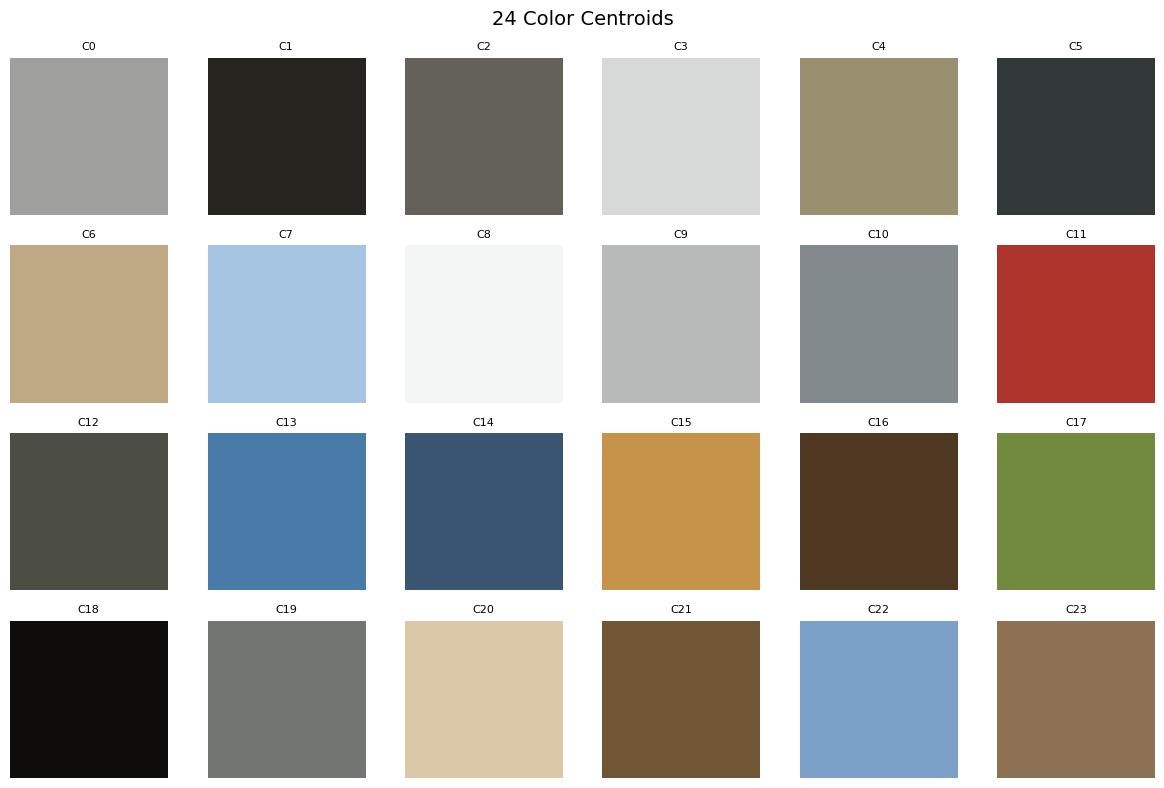

In [2]:
# Load color centroids
color_centroids = np.load('/kaggle/input/color-centroids/color_centroids.npy')
print(f"Color centroids shape: {color_centroids.shape}")
print(f"Color centroids range: [{color_centroids.min():.2f}, {color_centroids.max():.2f}]")

# Visualize the 24 color centroids
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axes = axes.flatten()

for i in range(24):
    # Create a small square with the centroid color
    color_square = np.ones((10, 10, 3)) * color_centroids[i] / 255.0
    axes[i].imshow(color_square)
    axes[i].set_title(f'C{i}', fontsize=8)
    axes[i].axis('off')

plt.suptitle('24 Color Centroids', fontsize=14)
plt.tight_layout()
plt.show()

In [3]:
def rgb_to_grayscale(rgb_image):
    """
    Convert RGB image to grayscale using standard weights
    Args:
        rgb_image: numpy array of shape (H, W, 3) with values in [0, 255]
    Returns:
        grayscale_image: numpy array of shape (H, W) with values in [0, 255]
    """
    # Standard RGB to grayscale conversion weights
    weights = np.array([0.33, 0.33, 0.33])
    grayscale = np.dot(rgb_image, weights)
    return grayscale.astype(np.uint8)

def assign_color_labels(rgb_image, centroids):
    """
    Assign each pixel to the nearest color centroid
    Args:
        rgb_image: numpy array of shape (H, W, 3) with values in [0, 255]
        centroids: numpy array of shape (24, 3) with color centroids
    Returns:
        labels: numpy array of shape (H, W) with values in {0, ..., 23}
    """
    H, W, _ = rgb_image.shape
    # Reshape image to (H*W, 3) for efficient distance computation
    pixels = rgb_image.reshape(-1, 3).astype(np.float32)
    
    # Compute distances to all centroids for all pixels
    # pixels: (H*W, 3), centroids: (24, 3)
    # distances: (H*W, 24)
    distances = np.linalg.norm(pixels[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    
    # Find nearest centroid for each pixel
    labels = np.argmin(distances, axis=1)
    
    # Reshape back to (H, W)
    return labels.reshape(H, W)

# Test the functions with a sample
print("Testing color assignment functions...")
test_rgb = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8)
test_gray = rgb_to_grayscale(test_rgb)
test_labels = assign_color_labels(test_rgb, color_centroids)

print(f"Test RGB shape: {test_rgb.shape}")
print(f"Test grayscale shape: {test_gray.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Label range: [{test_labels.min()}, {test_labels.max()}]")

Testing color assignment functions...
Test RGB shape: (32, 32, 3)
Test grayscale shape: (32, 32)
Test labels shape: (32, 32)
Label range: [0, 23]


In [4]:
class CIFAR10ColorizationDataset(Dataset):
    """
    Custom dataset for CIFAR-10 colorization task
    """
    def __init__(self, cifar_dataset, color_centroids, transform=None):
        """
        Args:
            cifar_dataset: Original CIFAR-10 dataset
            color_centroids: numpy array of shape (24, 3) with color centroids
            transform: Optional transform to be applied on the grayscale input
        """
        self.cifar_dataset = cifar_dataset
        self.color_centroids = color_centroids
        self.transform = transform
        
    def __len__(self):
        return len(self.cifar_dataset)
    
    def __getitem__(self, idx):
        # Get original RGB image and class (we ignore the class for colorization)
        rgb_image, _ = self.cifar_dataset[idx]
        
        # Convert PIL Image to numpy array if needed
        if hasattr(rgb_image, 'numpy'):
            rgb_array = rgb_image.numpy().transpose(1, 2, 0)  # CHW to HWC
        else:
            rgb_array = np.array(rgb_image)
        
        # Ensure values are in [0, 255] range
        if rgb_array.max() <= 1.0:
            rgb_array = (rgb_array * 255).astype(np.uint8)
        
        # Convert to grayscale
        grayscale = rgb_to_grayscale(rgb_array)
        
        # Assign color labels
        color_labels = assign_color_labels(rgb_array, self.color_centroids)
        
        # Convert to tensors
        # Grayscale: normalize to [0, 1] and add channel dimension
        grayscale_tensor = torch.from_numpy(grayscale).float() / 255.0
        grayscale_tensor = grayscale_tensor.unsqueeze(0)  # Add channel dimension: (1, H, W)
        
        # Color labels: keep as long tensor for cross-entropy loss
        labels_tensor = torch.from_numpy(color_labels).long()  # (H, W)
        
        # Apply transform to grayscale input if provided
        if self.transform:
            grayscale_tensor = self.transform(grayscale_tensor)
        
        return grayscale_tensor, labels_tensor

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")

# Define transforms (minimal for now, can be expanded later)
train_transform = transforms.Compose([
    transforms.ToTensor(),  # This will be applied to the original RGB, but we'll handle conversion manually
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load original CIFAR-10 datasets
cifar_train = datasets.CIFAR10(root='/kaggle/input/cifar-dataaset', train=True, download=True, transform=None)
cifar_test = datasets.CIFAR10(root='/kaggle/input/cifar-dataaset', train=False, download=True, transform=None)

print(f"CIFAR-10 train size: {len(cifar_train)}")
print(f"CIFAR-10 test size: {len(cifar_test)}")

# Create colorization datasets
train_dataset = CIFAR10ColorizationDataset(cifar_train, color_centroids)
test_dataset = CIFAR10ColorizationDataset(cifar_test, color_centroids)

print(f"Colorization train dataset size: {len(train_dataset)}")
print(f"Colorization test dataset size: {len(test_dataset)}")

Loading CIFAR-10 dataset...
CIFAR-10 train size: 50000
CIFAR-10 test size: 10000
Colorization train dataset size: 50000
Colorization test dataset size: 10000


Testing dataset and visualization...
Grayscale batch shape: torch.Size([8, 1, 32, 32])
Labels batch shape: torch.Size([8, 32, 32])
Grayscale range: [0.004, 0.988]
Labels range: [0, 23]


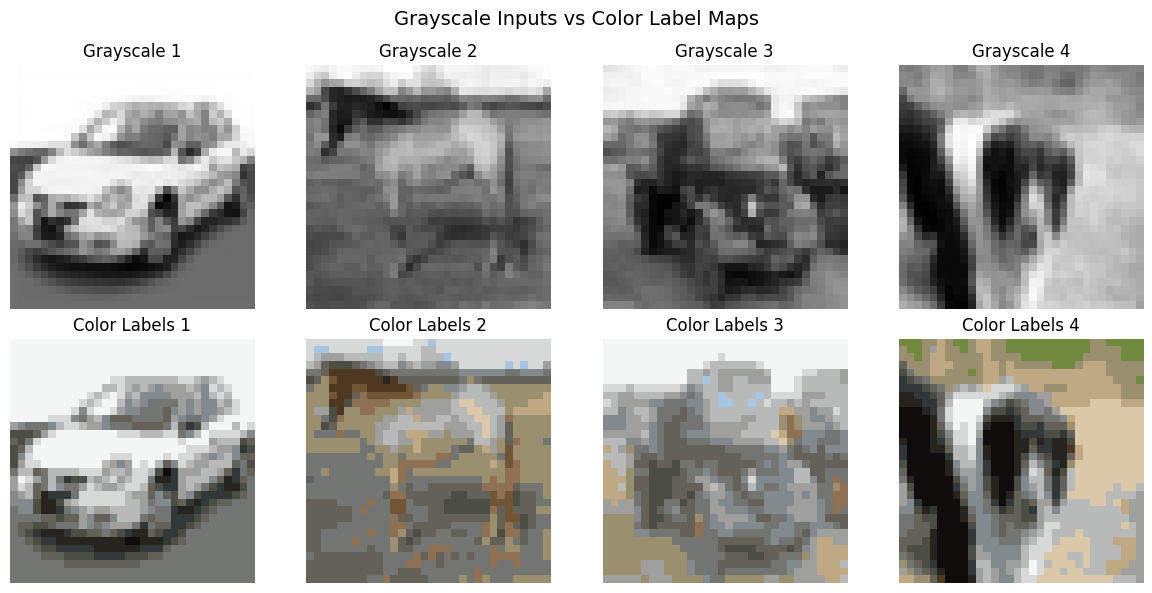

In [5]:
# Test the dataset and visualize some samples
print("Testing dataset and visualization...")

# Create a small subset for testing
test_indices = np.random.choice(len(train_dataset), 8, replace=False)
test_subset = Subset(train_dataset, test_indices)
test_loader = DataLoader(test_subset, batch_size=8, shuffle=False)

# Get a batch
grayscale_batch, labels_batch = next(iter(test_loader))

print(f"Grayscale batch shape: {grayscale_batch.shape}")  # Should be [8, 1, 32, 32]
print(f"Labels batch shape: {labels_batch.shape}")       # Should be [8, 32, 32]
print(f"Grayscale range: [{grayscale_batch.min():.3f}, {grayscale_batch.max():.3f}]")
print(f"Labels range: [{labels_batch.min()}, {labels_batch.max()}]")

# Visualize samples
def visualize_colorization_samples(grayscale_batch, labels_batch, color_centroids, num_samples=4):
    """Visualize grayscale inputs and their corresponding color label maps"""
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    
    for i in range(num_samples):
        # Grayscale input
        gray_img = grayscale_batch[i, 0].numpy()  # Remove channel dimension
        axes[0, i].imshow(gray_img, cmap='gray')
        axes[0, i].set_title(f'Grayscale {i+1}')
        axes[0, i].axis('off')
        
        # Color label map - convert labels back to RGB for visualization
        labels = labels_batch[i].numpy()
        rgb_reconstruction = color_centroids[labels] / 255.0  # Convert to [0,1] for display
        axes[1, i].imshow(rgb_reconstruction)
        axes[1, i].set_title(f'Color Labels {i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle('Grayscale Inputs vs Color Label Maps', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_colorization_samples(grayscale_batch, labels_batch, color_centroids)

In [6]:
# Create train/validation split
print("Creating train/validation split...")

# Split training data into train and validation (80/20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size], 
                                       generator=torch.Generator().manual_seed(42))

print(f"Train subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 64  # Can be adjusted based on GPU memory

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Verify data shapes
sample_gray, sample_labels = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"Input (grayscale): {sample_gray.shape}")   # Should be [batch_size, 1, 32, 32]
print(f"Target (labels): {sample_labels.shape}")   # Should be [batch_size, 32, 32]

Creating train/validation split...
Train subset size: 40000
Validation subset size: 10000
Test dataset size: 10000
Number of training batches: 625
Number of validation batches: 157
Number of test batches: 157

Sample batch shapes:
Input (grayscale): torch.Size([64, 1, 32, 32])
Target (labels): torch.Size([64, 32, 32])


## Model Architecture

In [7]:

class Model(nn.Module):

    def __init__(self, num__filter, num_input_channel, kernel_size, number_of_classes=24):
        super().__init__()
        
        # --- FIX: Padding is only for the encoder ---
        # (kernel_size=3 -> enc_padding=1)
        # (kernel_size=5 -> enc_padding=2)
        enc_padding = (kernel_size - 1) // 2

        ##### ENCODER (Correctly uses variable kernel_size)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=num_input_channel, out_channels=num__filter, kernel_size=kernel_size, padding=enc_padding),
            nn.BatchNorm2d(num__filter),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels=num__filter, out_channels=num__filter*2, kernel_size=kernel_size, padding=enc_padding),
            nn.BatchNorm2d(num__filter*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels=num__filter*2, out_channels=num__filter*4, kernel_size=kernel_size, padding=enc_padding),
            nn.BatchNorm2d(num__filter*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        ##### DECODER (FIXED: Hard-coded to match diagram)

        self.dc1 = nn.Sequential(
            # Diagram specifies kernel=2, stride=2. No padding needed.
            nn.ConvTranspose2d(in_channels=num__filter*4, out_channels=num__filter*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(num__filter*2),
            nn.ReLU()
        )

        self.dc2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=num__filter*2, out_channels=num__filter, kernel_size=2, stride=2),  
            nn.BatchNorm2d(num__filter),
            nn.ReLU()
        )

        self.dc3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=num__filter, out_channels=number_of_classes, kernel_size=2, stride=2),
            nn.BatchNorm2d(number_of_classes),
            nn.ReLU()
        )

        ### CLASSIFIER (Correct, matches diagram)
        self.classifier = nn.Conv2d(in_channels=number_of_classes, out_channels=number_of_classes, kernel_size=1)
        
    def forward(self, x):
        # --- ADDED: The required forward pass ---
        
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # Decoder
        d1 = self.dc1(e3)
        d2 = self.dc2(d1)
        d3 = self.dc3(d2)
        
        # Classifier
        output = self.classifier(d3)
        
        # Output is [B, NC, 32, 32]
        return output

In [8]:
os.environ["WANDB_API_KEY"] = "014cdbdae7d21a9038c83eef896d1726d5ab057a"

In [9]:
print(os.environ["WANDB_API_KEY"])

014cdbdae7d21a9038c83eef896d1726d5ab057a


## Training and Evaluation

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import wandb
import numpy as np # <-- Needed for image conversion

# --- Helper function to create RGB images from labels ---
# This converts your label map back into a viewable color image
def labels_to_rgb(label_map, centroids):
    """Converts a [H, W] label map to a [H, W, 3] RGB image."""
    # .cpu().numpy() is important if the map is on the GPU
    label_map = label_map.cpu().numpy()
    rgb_image = centroids[label_map]
    return rgb_image.astype(np.uint8)

# --- Helper function to make grayscale viewable ---
def grayscale_to_rgb(gray_tensor):
    """Converts a [1, H, W] grayscale tensor to a [H, W, 3] RGB image."""
    gray_np = gray_tensor.squeeze(0).cpu().numpy() # Squeeze to [H, W]
    rgb_image = np.stack([gray_np, gray_np, gray_np], axis=-1)
    return (rgb_image * 255).astype(np.uint8)
# --------------------------------------------------------

config = {
    "learning_rate": 0.01,
    "batch_size": 64, 
    "num_epochs": 25,
    "num_filters": 16,
    "kernel_size": 3,
    "optimizer": "Adam"
}

wandb.init(
    project="q2-cifar_usingKaggle",
    name="ye_basic_h",
    config=config 
)

model = Model(
    num__filter=config["num_filters"], 
    num_input_channel=1, 
    kernel_size=config["kernel_size"], 
    number_of_classes=24
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

optim = optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()
num_epochs = config["num_epochs"]

best_val_loss = float('inf')
save_path = 'checkpoints/basic_model.pth'

os.makedirs(os.path.dirname(save_path), exist_ok=True)
print(f"Checkpoints will be saved to {save_path}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "validation_loss": avg_val_loss
    })

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved to {save_path} (Val Loss: {avg_val_loss:.4f})")

print("\nFinished Training.")

print("Generating example colorizations...")

model.load_state_dict(torch.load(save_path))
model.eval() 
# Get one batch of validation data
with torch.no_grad():
    inputs, labels = next(iter(val_loader)) # Get a batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs) 
    
    # Convert logits to final class predictions
    # We take the argmax along the channel (dim=1)
    predicted_labels = torch.argmax(outputs, dim=1) # Shape [B, 32, 32]

# [cite_start]Log the first 10 images from the batch [cite: 224]
example_images = []
for i in range(10):
    # Get the i-th image/label from the batch
    gray_input = inputs[i]
    ground_truth_labels = labels[i]
    pred_labels = predicted_labels[i]

    # Convert all three to RGB numpy arrays
    gray_rgb = grayscale_to_rgb(gray_input)
    truth_rgb = labels_to_rgb(ground_truth_labels, color_centroids)
    pred_rgb = labels_to_rgb(pred_labels, color_centroids)
    
    # Add to list for wandb
    example_images.append(wandb.Image(
        gray_rgb, 
        caption=f"Image {i}: Input Grayscale"
    ))
    example_images.append(wandb.Image(
        pred_rgb, 
        caption=f"Image {i}: Predicted Color"
    ))
    example_images.append(wandb.Image(
        truth_rgb, 
        caption=f"Image {i}: Ground Truth"
    ))

# Log the list of images to wandb under the key "Colorization Examples"
wandb.log({"Colorization Examples": example_images})
print("Logged 10 example images to wandb.")

# --- 4. SAVE BEST MODEL AND FINISH ---
wandb.save(save_path)
print(f"Best model {save_path} saved to wandb.")

wandb.finish()

wandb: Currently logged in as: nidhish-jain (nidhish-jain-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda
Checkpoints will be saved to checkpoints/basic_model.pth


Epoch 1/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.33it/s]



Epoch [1/25], Train Loss: 2.0237, Val Loss: 1.8952
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.8952)


Epoch 2/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.65it/s]



Epoch [2/25], Train Loss: 1.8525, Val Loss: 1.8060
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.8060)


Epoch 3/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.72it/s]



Epoch [3/25], Train Loss: 1.8167, Val Loss: 1.8025
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.8025)


Epoch 4/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.93it/s]



Epoch [4/25], Train Loss: 1.7893, Val Loss: 1.8889


Epoch 5/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s]



Epoch [5/25], Train Loss: 1.7802, Val Loss: 1.7484
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.7484)


Epoch 6/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.03it/s]



Epoch [6/25], Train Loss: 1.7673, Val Loss: 1.8640


Epoch 7/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.35it/s]



Epoch [7/25], Train Loss: 1.7566, Val Loss: 1.7322
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.7322)


Epoch 8/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.03it/s]



Epoch [8/25], Train Loss: 1.7501, Val Loss: 1.7166
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.7166)


Epoch 9/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.67it/s]



Epoch [9/25], Train Loss: 1.7389, Val Loss: 1.7658


Epoch 10/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.11it/s]



Epoch [10/25], Train Loss: 1.7361, Val Loss: 1.7208


Epoch 11/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.70it/s]



Epoch [11/25], Train Loss: 1.7309, Val Loss: 1.6959
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6959)


Epoch 12/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.25it/s]



Epoch [12/25], Train Loss: 1.7296, Val Loss: 1.6888
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6888)


Epoch 13/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s]



Epoch [13/25], Train Loss: 1.7256, Val Loss: 1.6937


Epoch 14/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.28it/s]



Epoch [14/25], Train Loss: 1.7220, Val Loss: 1.7722


Epoch 15/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.03it/s]



Epoch [15/25], Train Loss: 1.7198, Val Loss: 1.7113


Epoch 16/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.55it/s]



Epoch [16/25], Train Loss: 1.7197, Val Loss: 1.6701
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6701)


Epoch 17/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.96it/s]



Epoch [17/25], Train Loss: 1.7155, Val Loss: 1.7065


Epoch 18/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.85it/s]



Epoch [18/25], Train Loss: 1.7079, Val Loss: 1.7008


Epoch 19/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.82it/s]



Epoch [19/25], Train Loss: 1.7075, Val Loss: 1.7640


Epoch 20/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.73it/s]



Epoch [20/25], Train Loss: 1.7060, Val Loss: 1.6856


Epoch 21/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.81it/s]



Epoch [21/25], Train Loss: 1.7008, Val Loss: 1.6919


Epoch 22/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.53it/s]



Epoch [22/25], Train Loss: 1.7006, Val Loss: 1.7399


Epoch 23/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.79it/s]



Epoch [23/25], Train Loss: 1.6995, Val Loss: 1.7630


Epoch 24/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.78it/s]



Epoch [24/25], Train Loss: 1.6965, Val Loss: 1.6733


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s]


Epoch [25/25], Train Loss: 1.6948, Val Loss: 1.7036

Finished Training.
Generating example colorizations...


Logged 10 example images to wandb.
Best model checkpoints/basic_model.pth saved to wandb.


## Analytical Questions

## Hyperparameter Tuning

In [ ]:
os.environ["WANDB_API_KEY"] = ""#### had put api keyyy no issues over here removing for github warnings ig 

In [20]:
   import torch.optim as optim


--- Defining Sweep Configuration ---
Create sweep with ID: omt9rfa1
Sweep URL: https://wandb.ai/nidhish-jain-iiit-hyderabad/q2-cifar/sweeps/omt9rfa1

Sweep initialized. SWEEP_ID: omt9rfa1
--- You can now run Cell 2 to start the agent ---

--- Starting Wandb Agent for Sweep omt9rfa1 ---
This will run 20 times. You can stop this cell at any time.


wandb: Agent Starting Run: iia0qczu with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks5_lr0.0001_nf16_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 5, 'learning_rate': 0.0001, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks5_lr0.0001_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.52it/s]



Finished Training for bs64_ks5_lr0.0001_nf16_optSGD. Best Val Loss: 2.5879
Generating example colorizations...


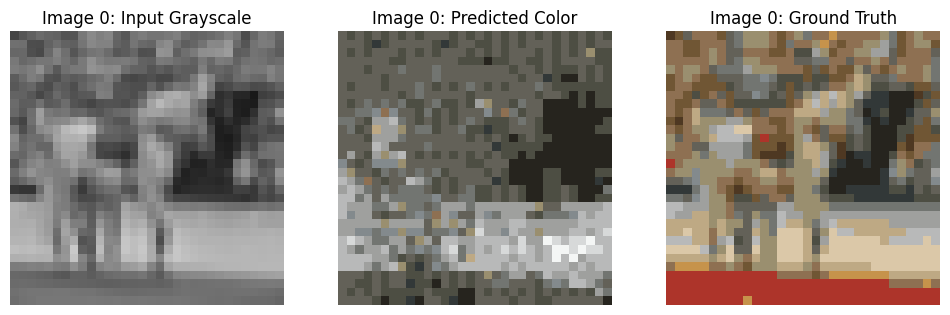

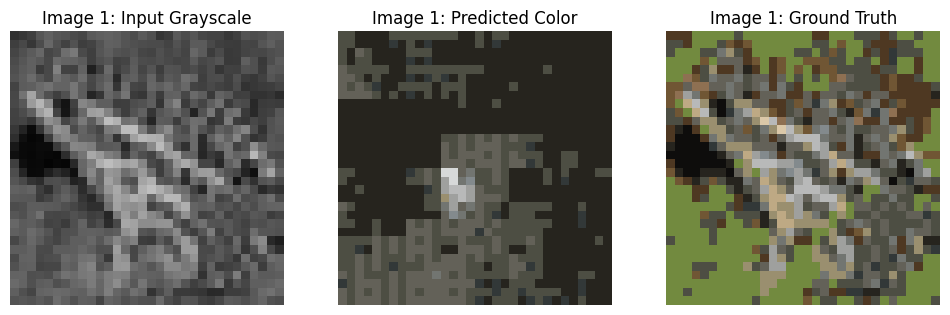

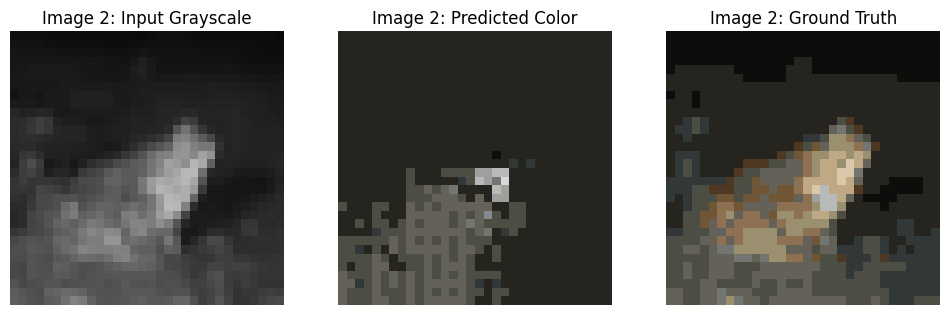

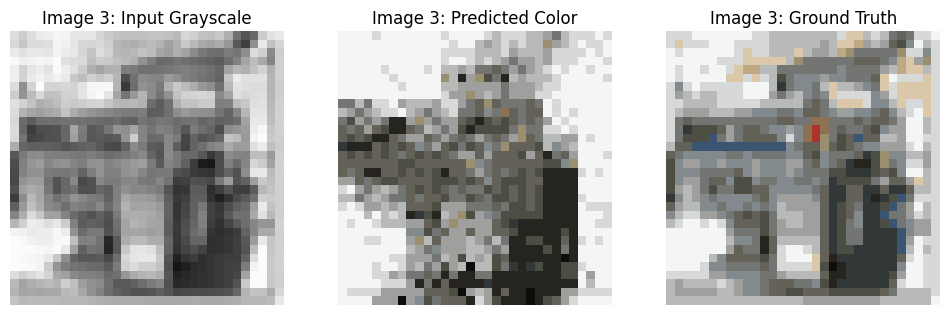

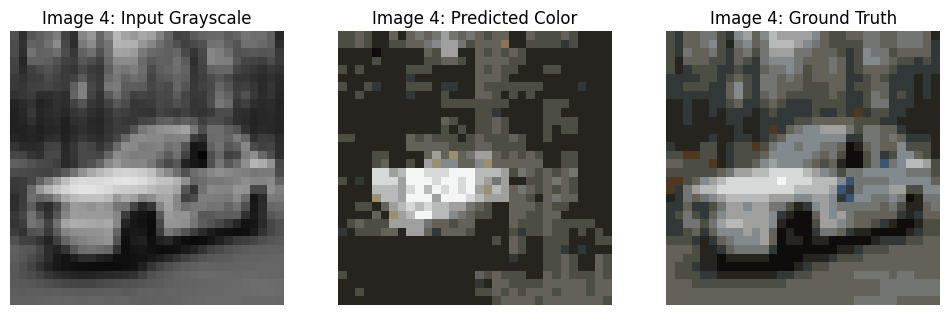

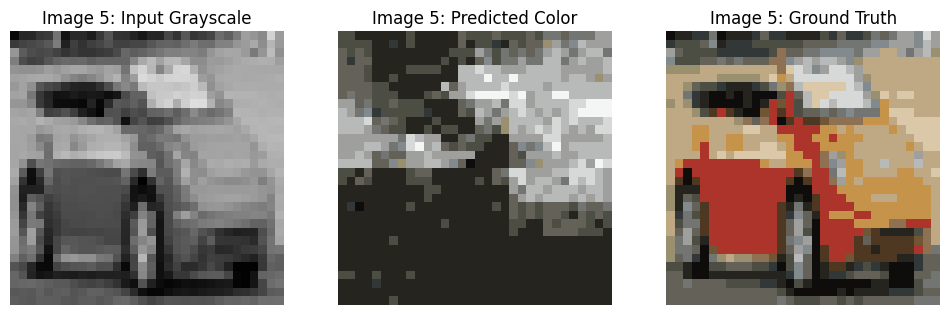

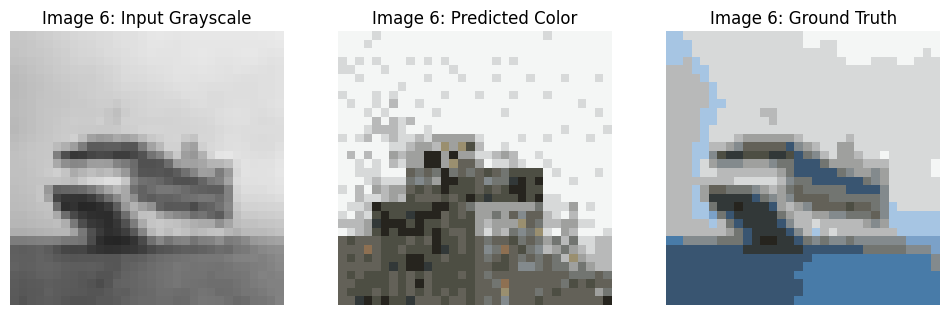

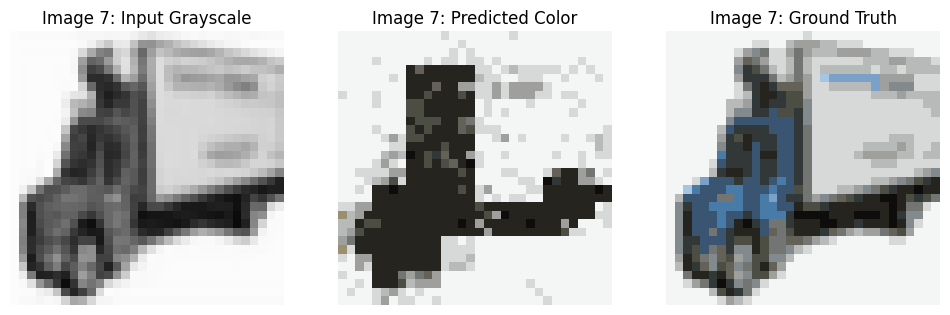

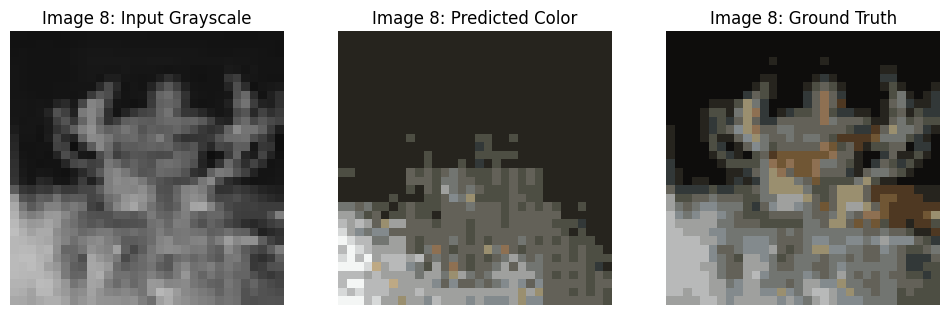

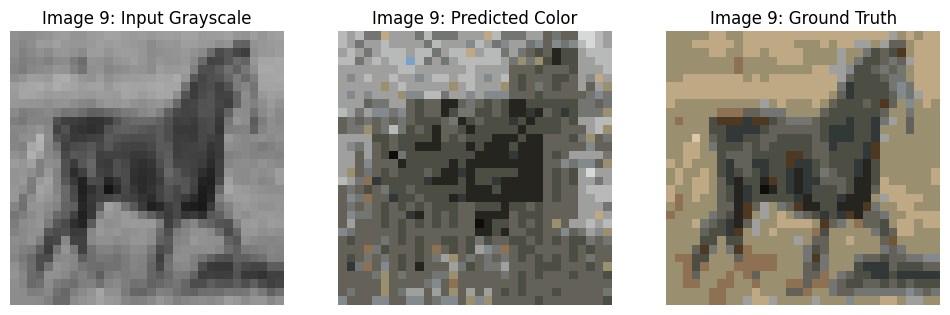

Logged example images.
Best model checkpoints/bs64_ks5_lr0.0001_nf16_optSGD.pth saved to wandb.


wandb: Agent Starting Run: kc0qbocv with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	num_filters: 8
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks5_lr0.0003_nf8_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 5, 'learning_rate': 0.0003, 'num_filters': 8, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks5_lr0.0003_nf8_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.86it/s]


Finished Training for bs64_ks5_lr0.0003_nf8_optSGD. Best Val Loss: 2.1836
Generating example colorizations...


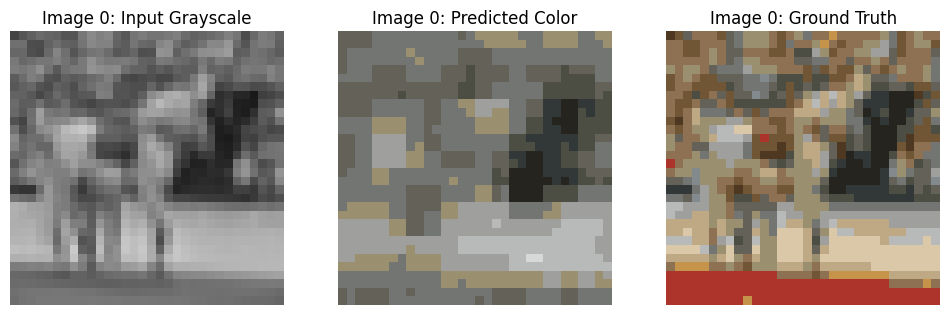

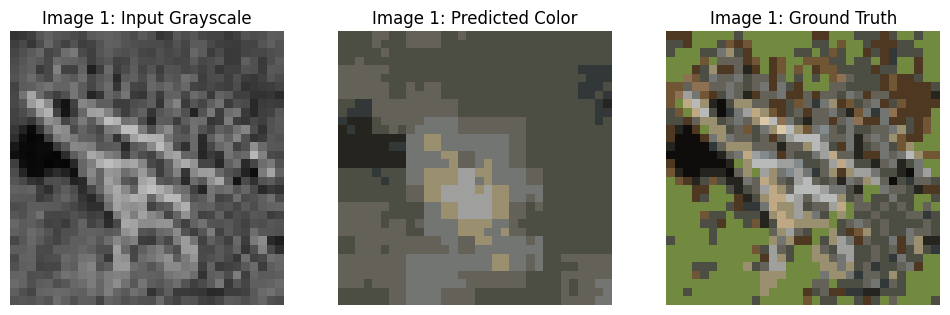

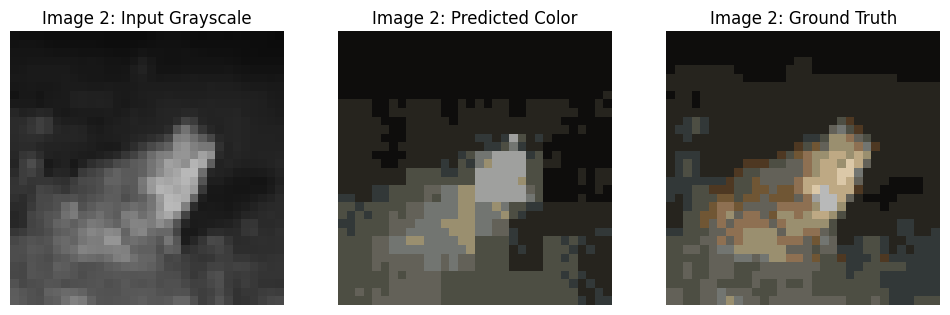

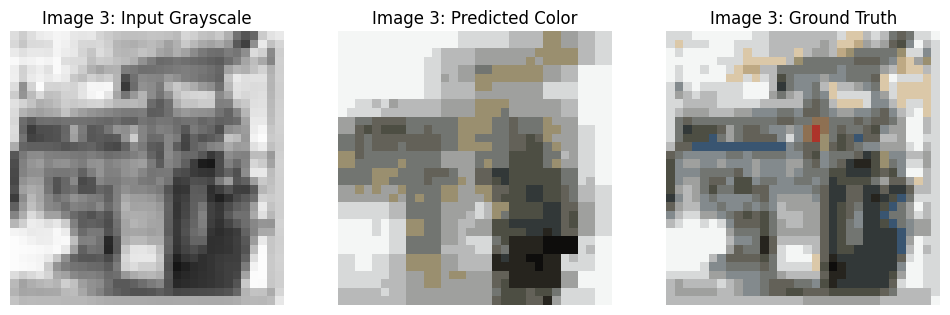

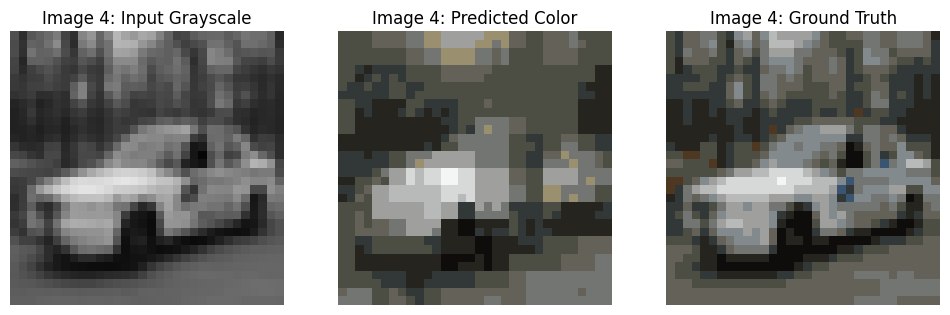

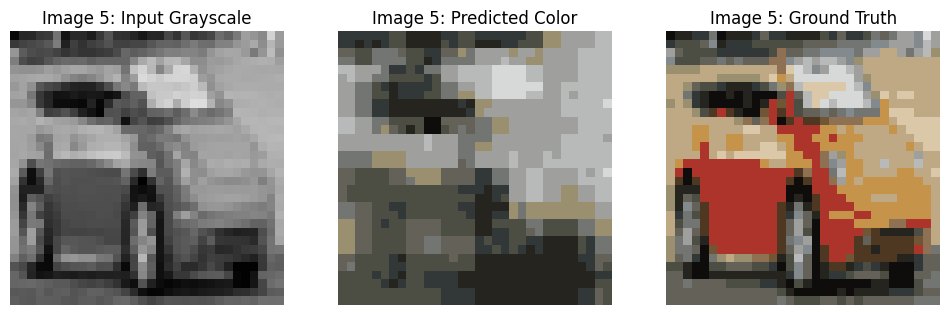

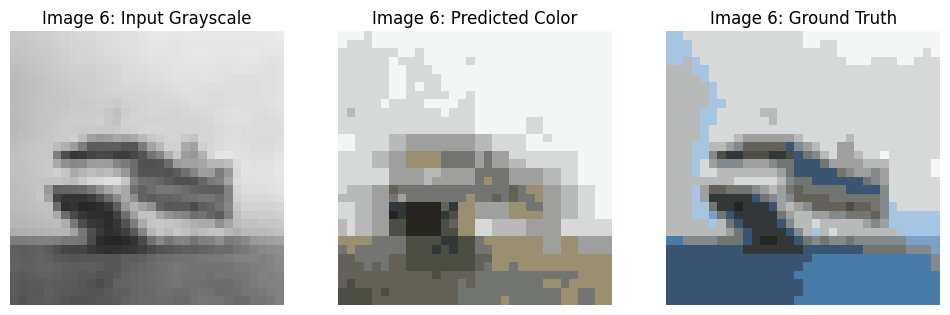

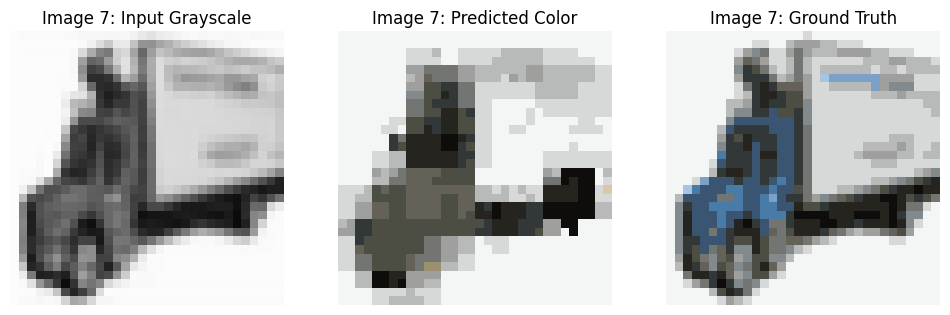

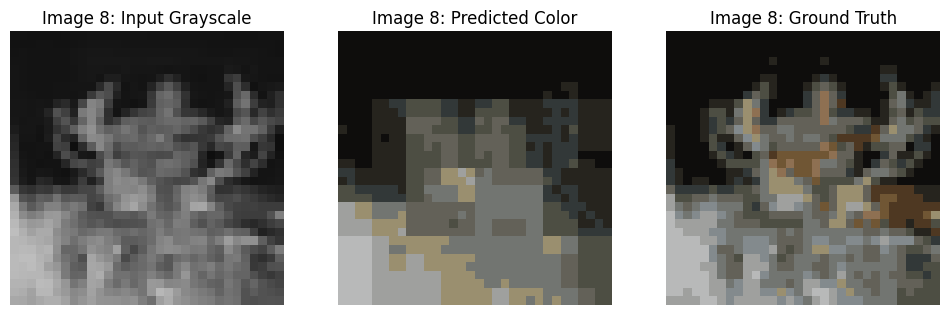

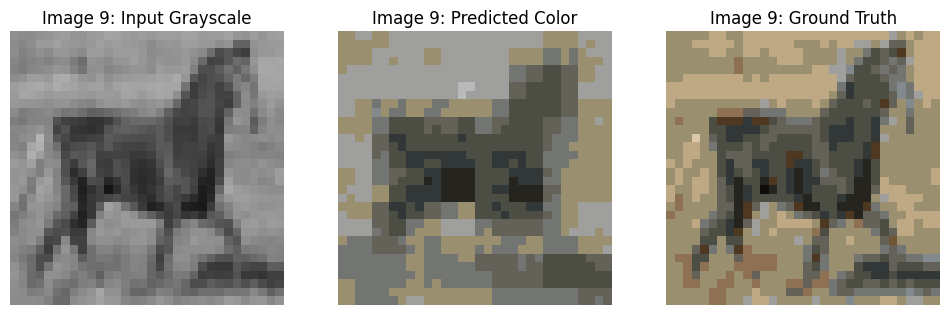

Logged example images.
Best model checkpoints/bs64_ks5_lr0.0003_nf8_optSGD.pth saved to wandb.


wandb: Agent Starting Run: he5fc3pn with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 32
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks3_lr0.003_nf32_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 32, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks3_lr0.003_nf32_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.01it/s]


Finished Training for bs64_ks3_lr0.003_nf32_optSGD. Best Val Loss: 1.6540
Generating example colorizations...


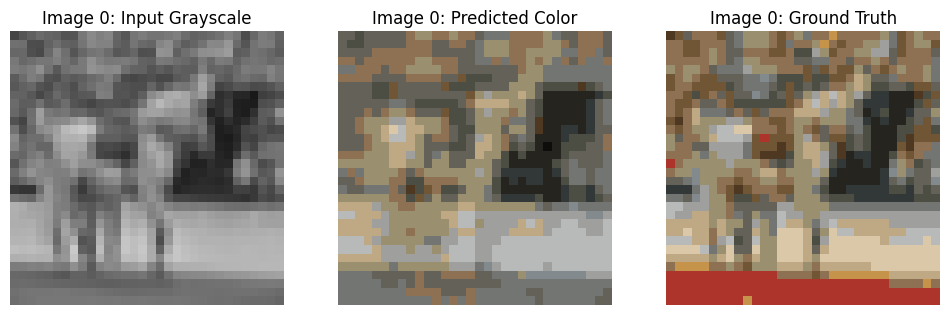

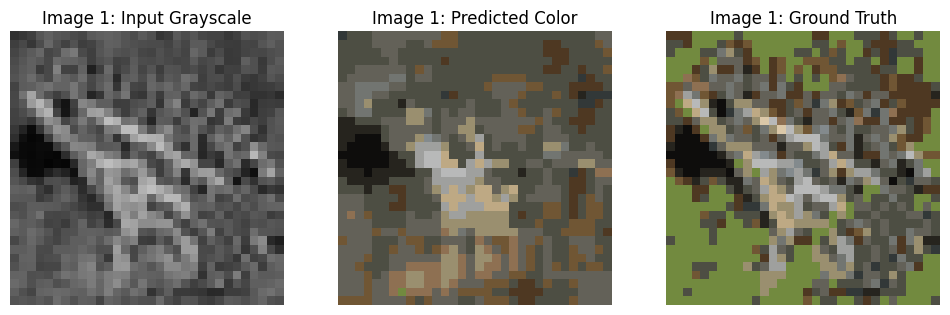

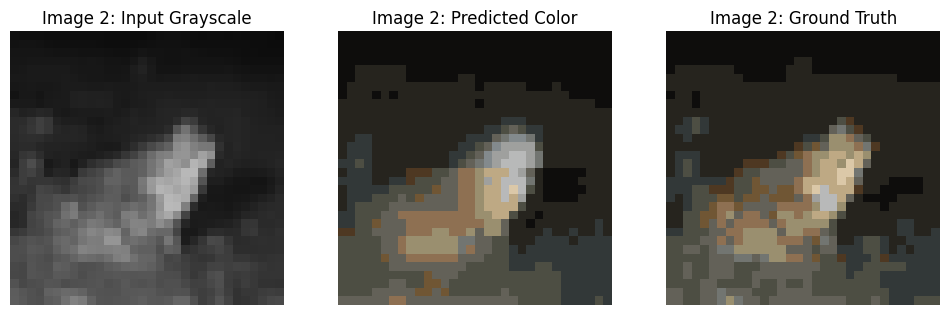

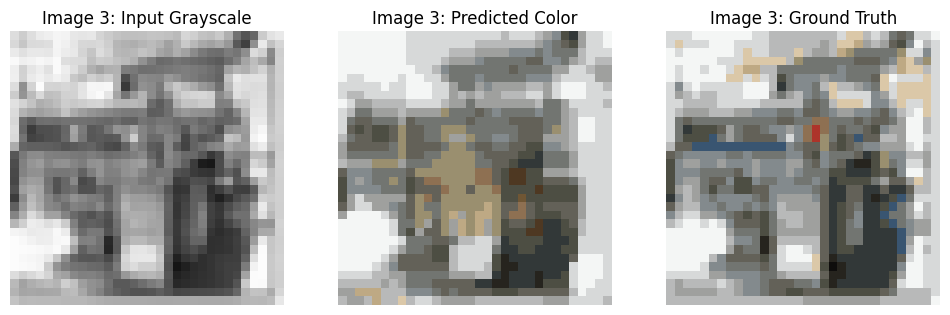

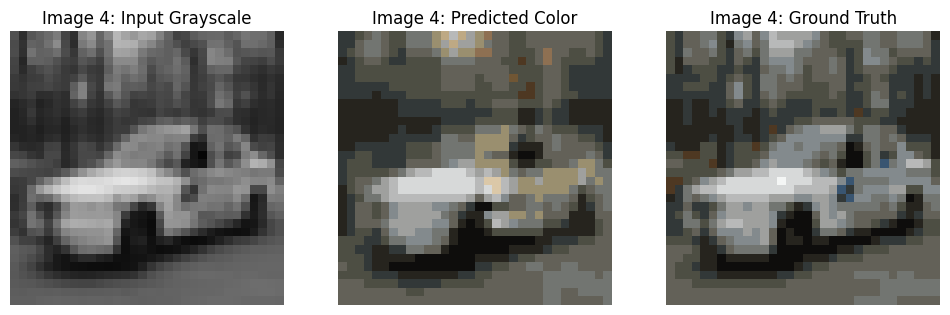

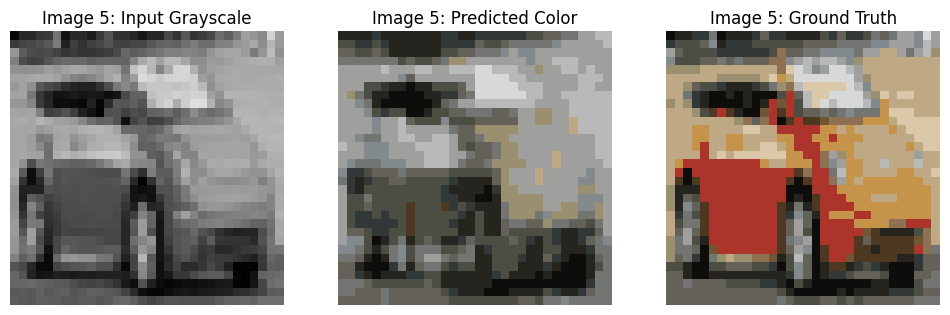

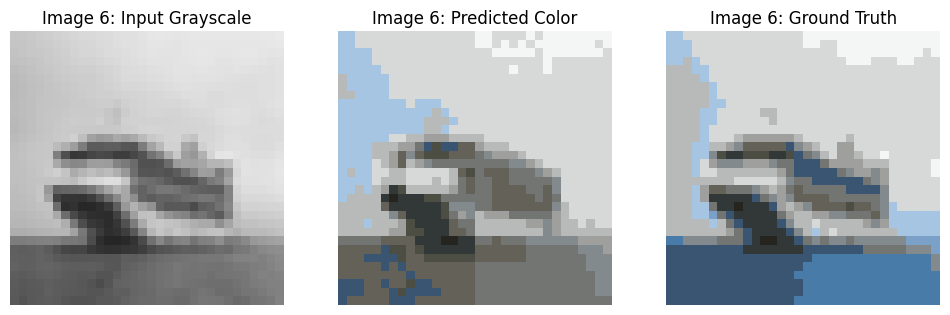

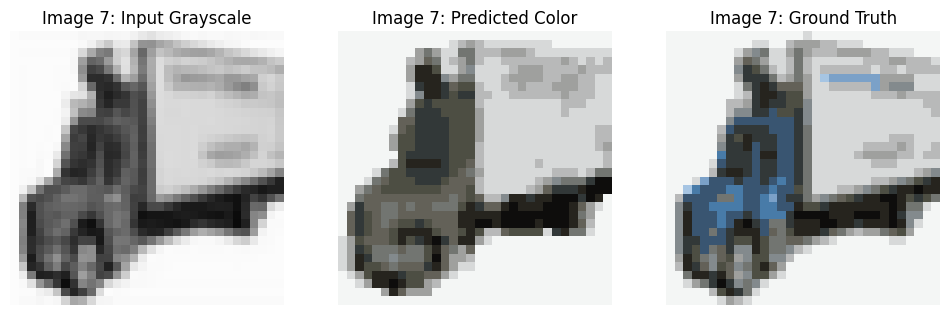

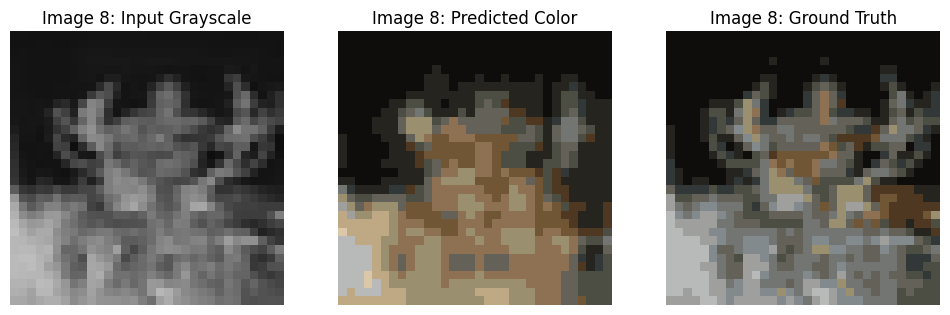

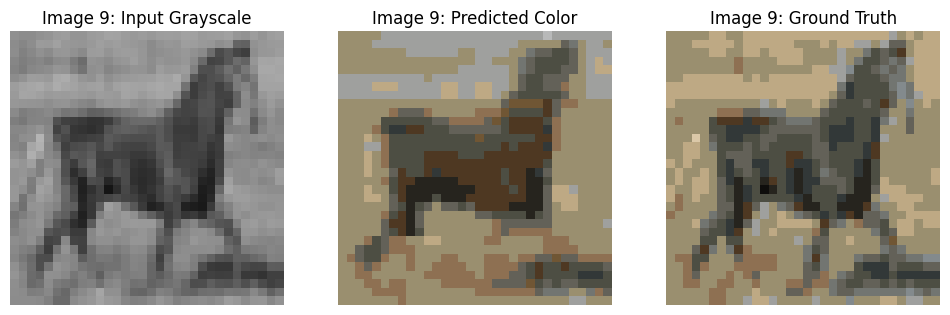

Logged example images.
Best model checkpoints/bs64_ks3_lr0.003_nf32_optSGD.pth saved to wandb.


wandb: Agent Starting Run: r7x5jhnw with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 8
wandb: 	optimizer: Adam


--- Starting Run: bs64_ks3_lr0.003_nf8_optAdam ---
Config: {'batch_size': 64, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 8, 'optimizer': 'Adam'}
Checkpoints will be saved to checkpoints/bs64_ks3_lr0.003_nf8_optAdam.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.13it/s]


Finished Training for bs64_ks3_lr0.003_nf8_optAdam. Best Val Loss: 1.8072
Generating example colorizations...


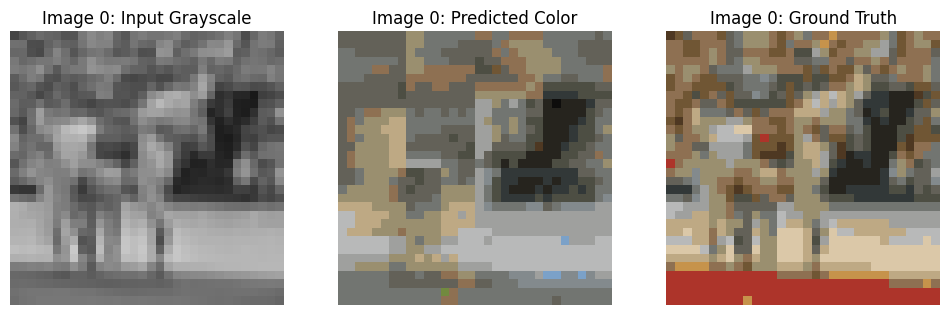

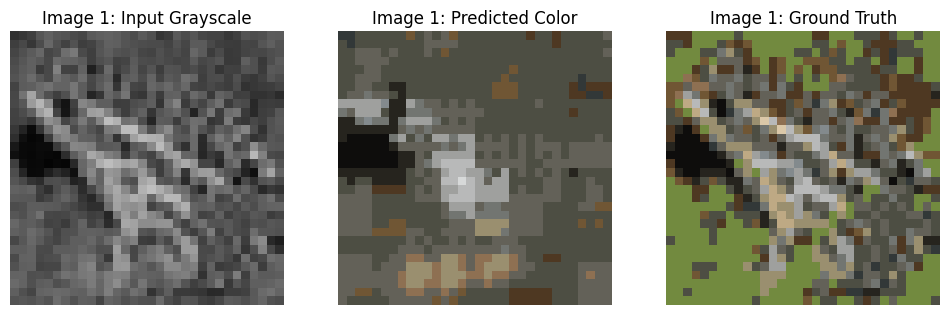

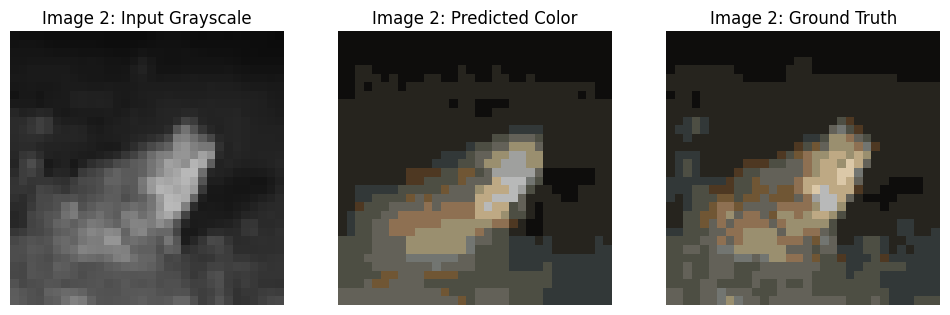

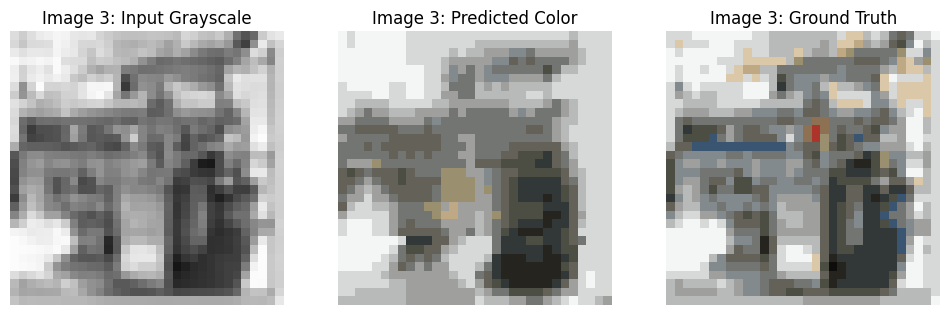

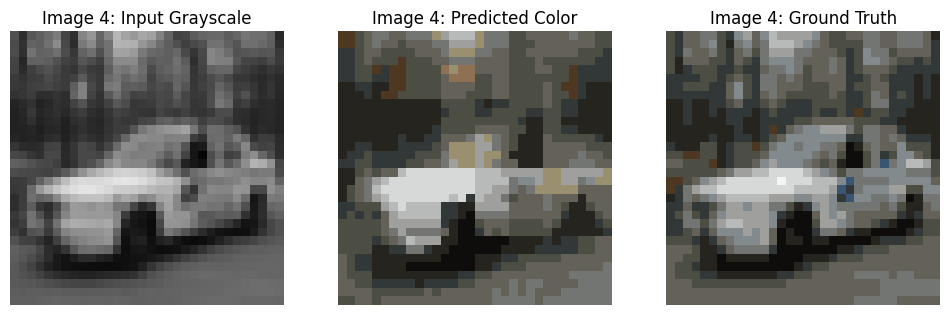

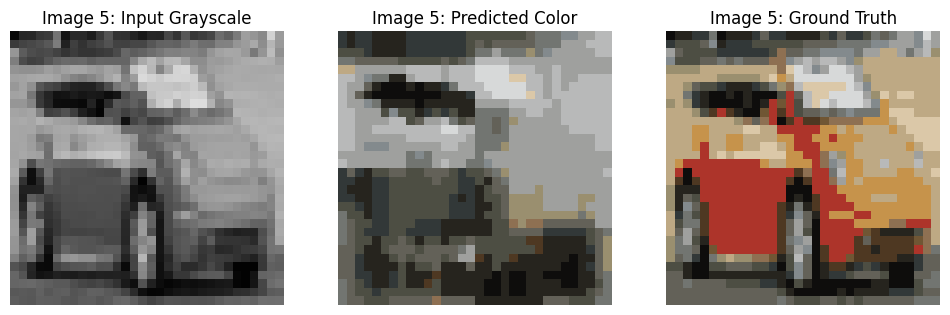

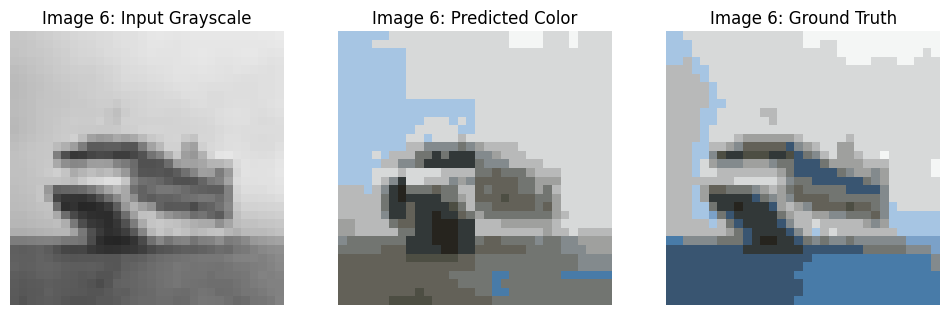

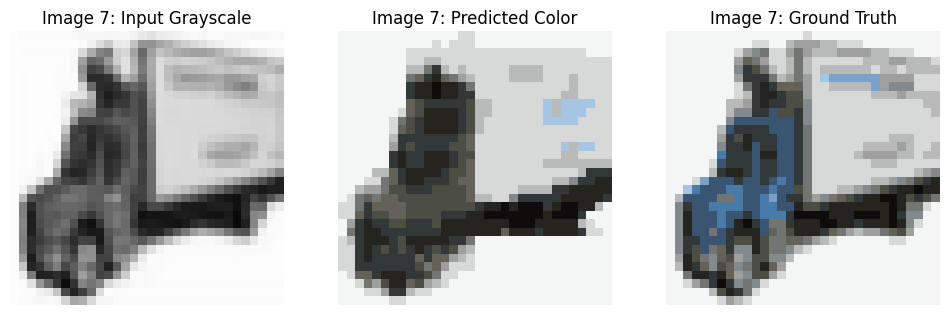

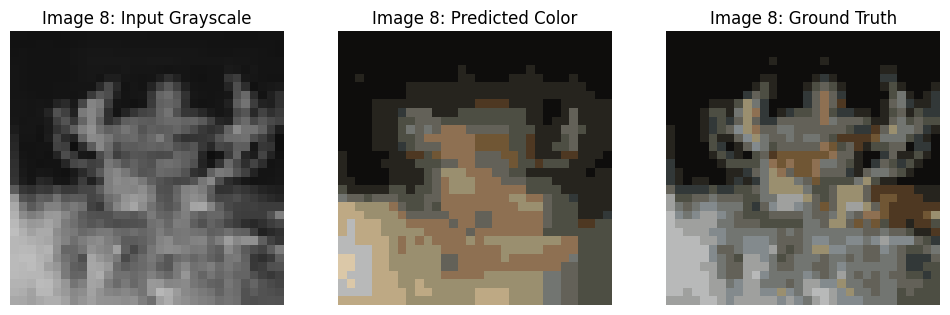

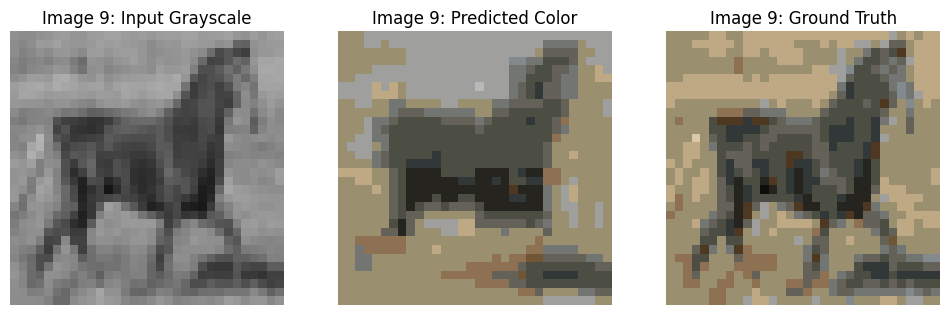

Logged example images.
Best model checkpoints/bs64_ks3_lr0.003_nf8_optAdam.pth saved to wandb.


wandb: Agent Starting Run: x30uxrua with config:
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0003
wandb: 	num_filters: 16
wandb: 	optimizer: Adam


--- Starting Run: bs128_ks3_lr0.0003_nf16_optAdam ---
Config: {'batch_size': 128, 'kernel_size': 3, 'learning_rate': 0.0003, 'num_filters': 16, 'optimizer': 'Adam'}
Checkpoints will be saved to checkpoints/bs128_ks3_lr0.0003_nf16_optAdam.pth


Epoch 25/25 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 13.91it/s]


Finished Training for bs128_ks3_lr0.0003_nf16_optAdam. Best Val Loss: 1.7129
Generating example colorizations...


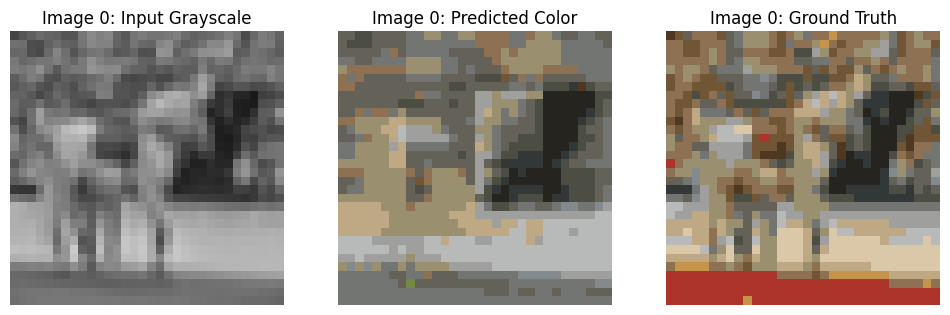

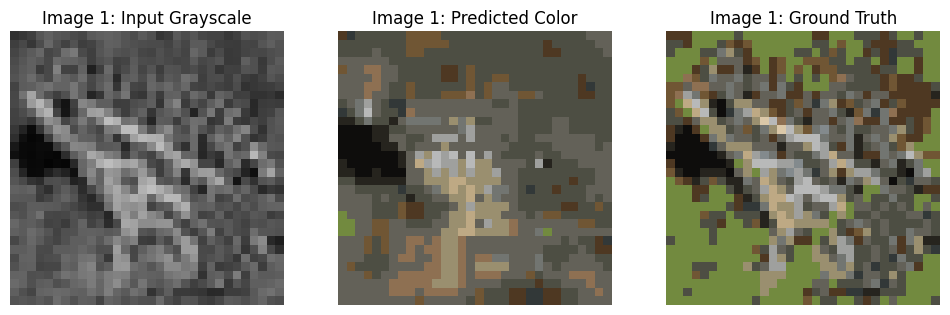

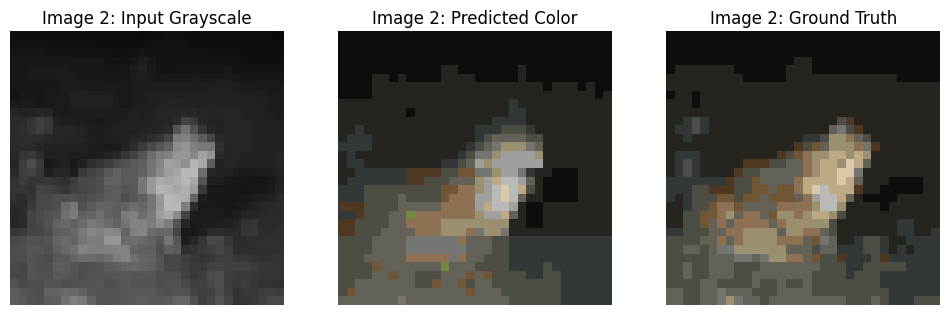

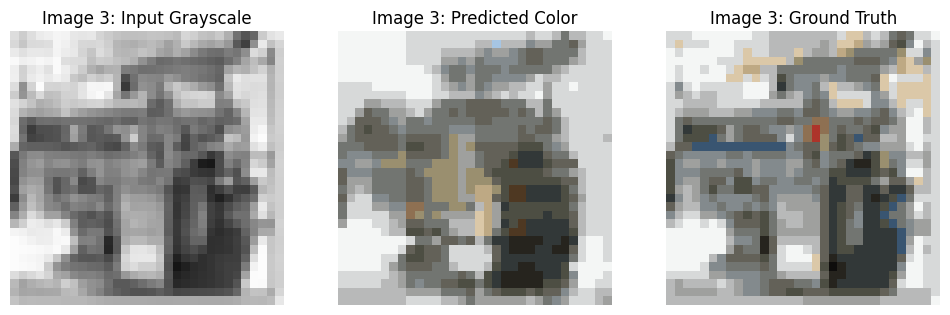

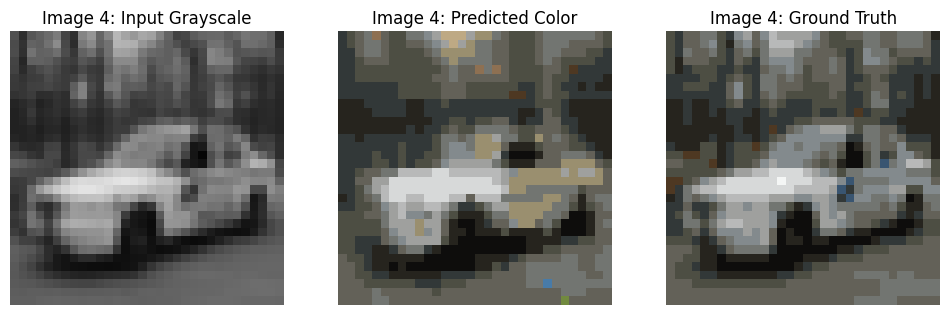

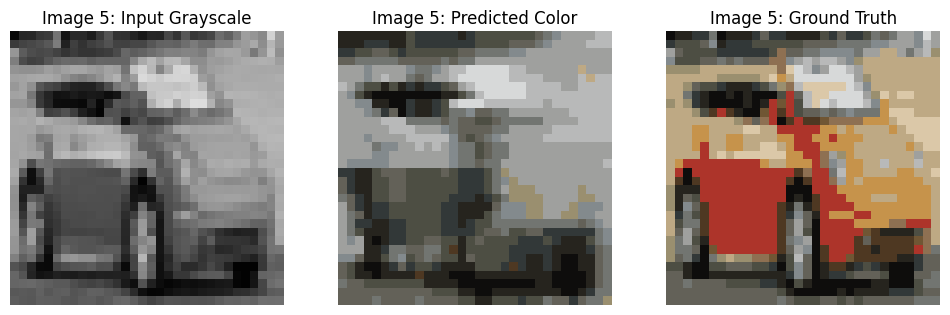

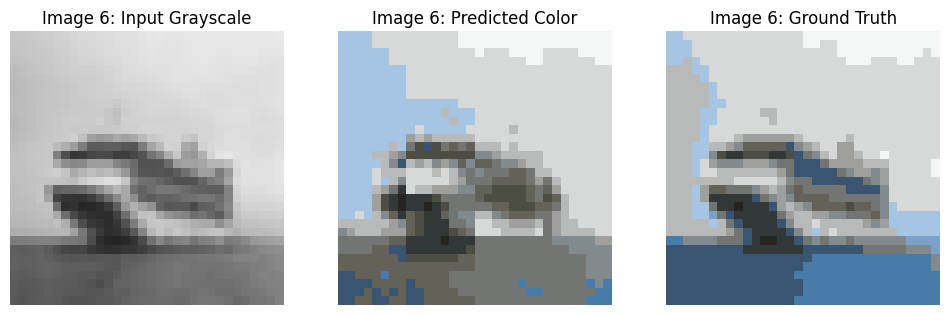

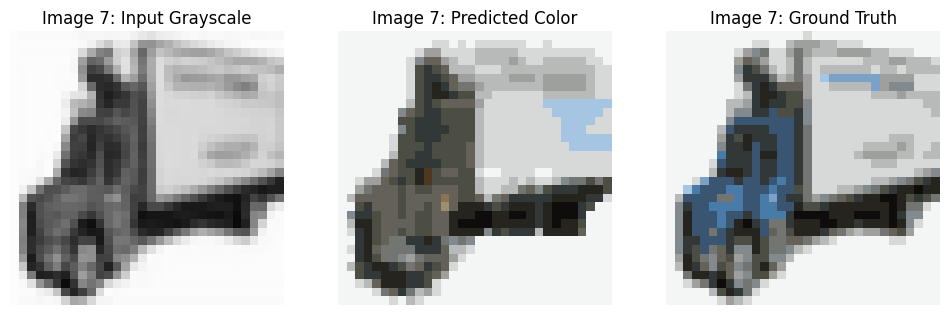

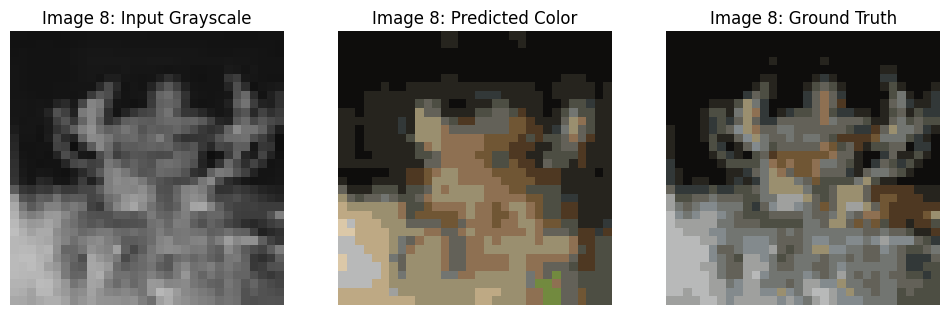

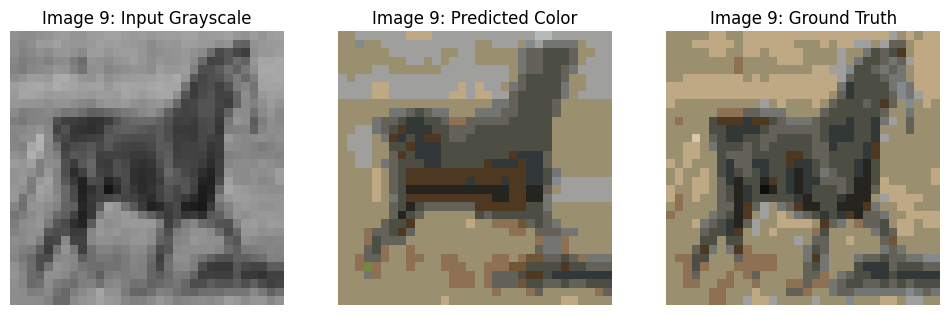

Logged example images.
Best model checkpoints/bs128_ks3_lr0.0003_nf16_optAdam.pth saved to wandb.


wandb: Agent Starting Run: 8y5qlj0p with config:
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs128_ks3_lr0.003_nf16_optSGD ---
Config: {'batch_size': 128, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs128_ks3_lr0.003_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Finished Training for bs128_ks3_lr0.003_nf16_optSGD. Best Val Loss: 1.8238
Generating example colorizations...


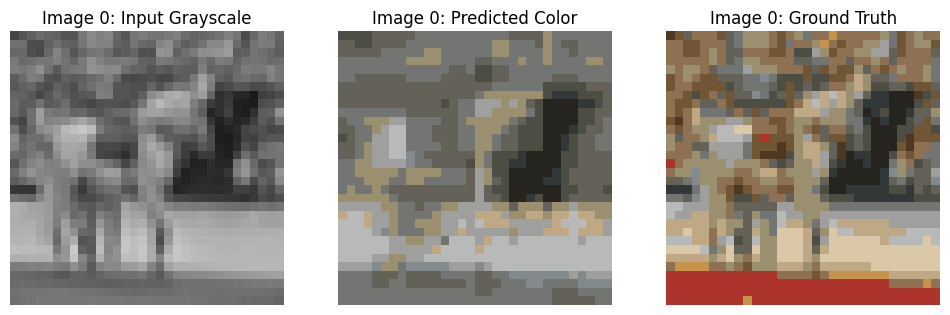

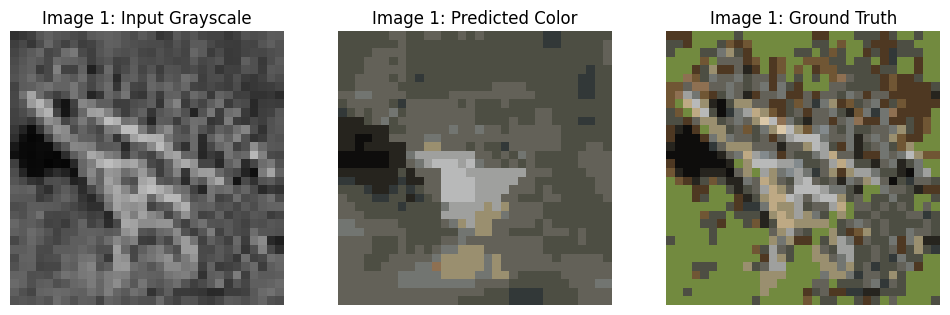

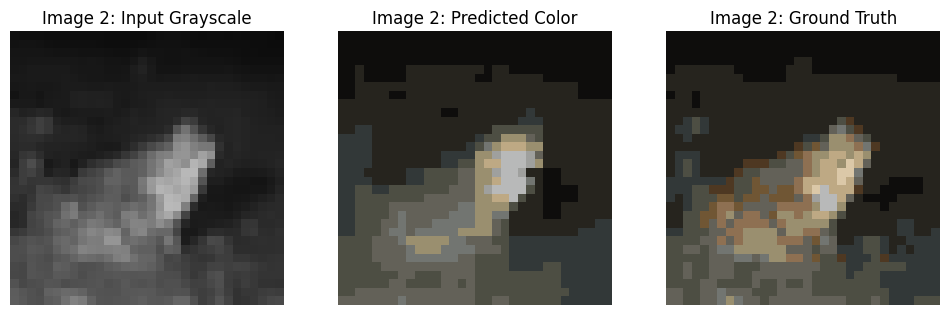

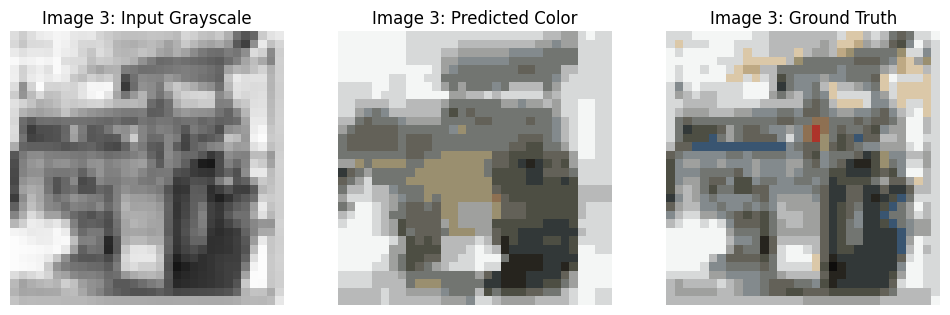

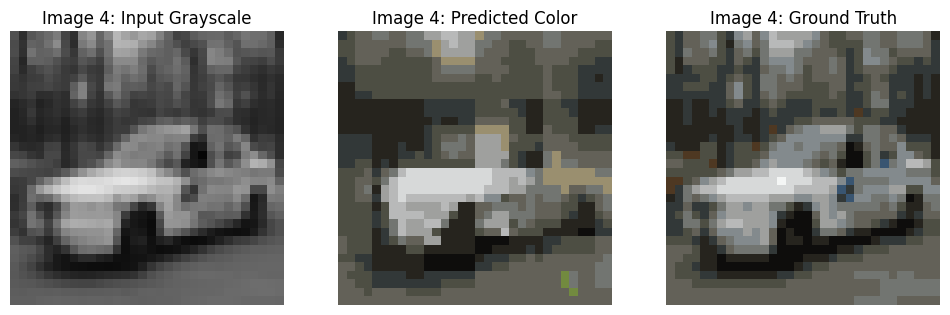

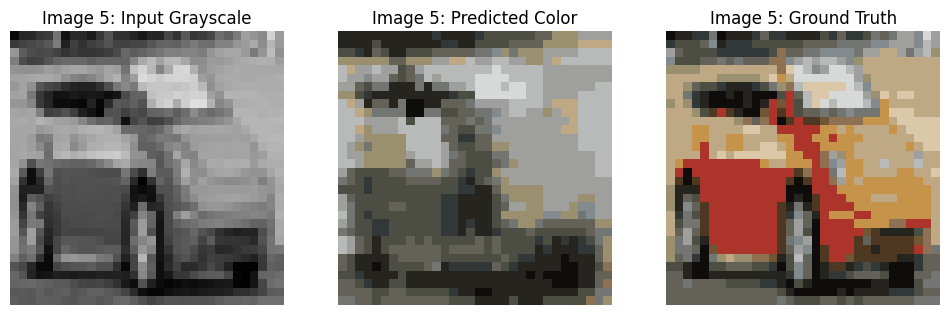

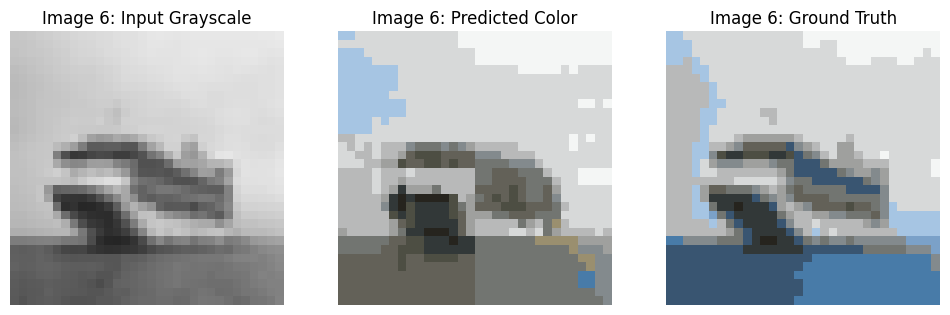

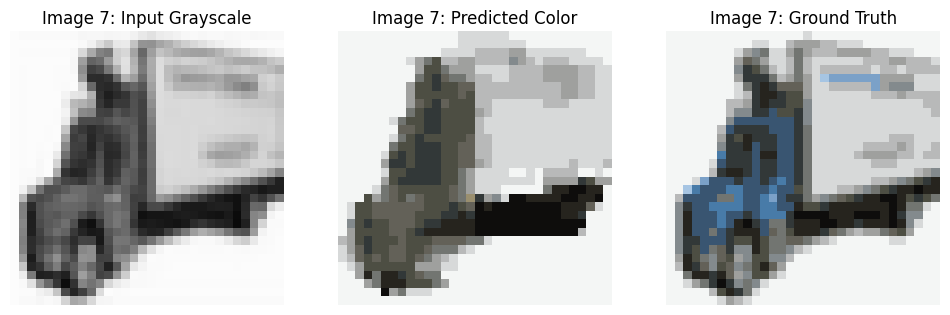

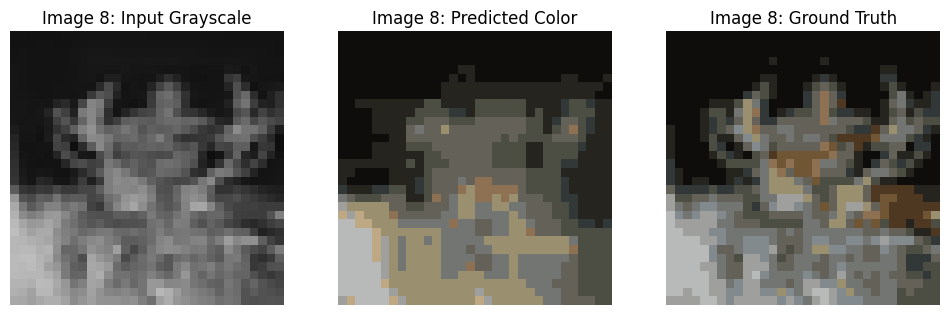

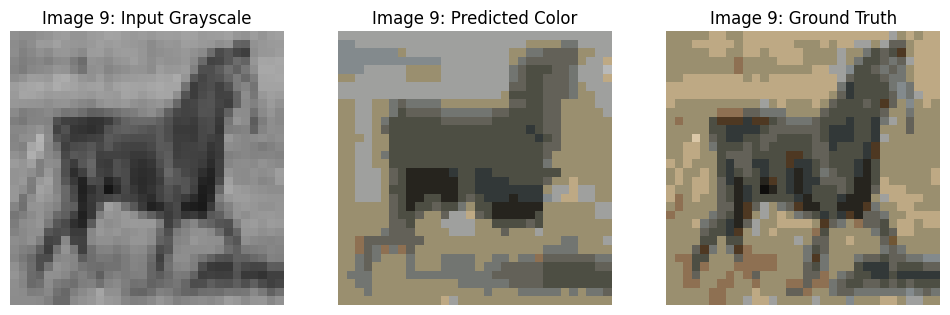

Logged example images.
Best model checkpoints/bs128_ks3_lr0.003_nf16_optSGD.pth saved to wandb.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e15y4zlb with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks3_lr0.003_nf16_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks3_lr0.003_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.51it/s]


Finished Training for bs64_ks3_lr0.003_nf16_optSGD. Best Val Loss: 1.7504
Generating example colorizations...


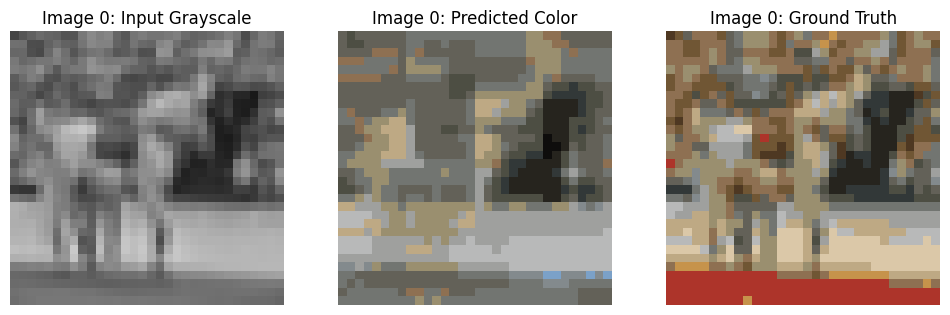

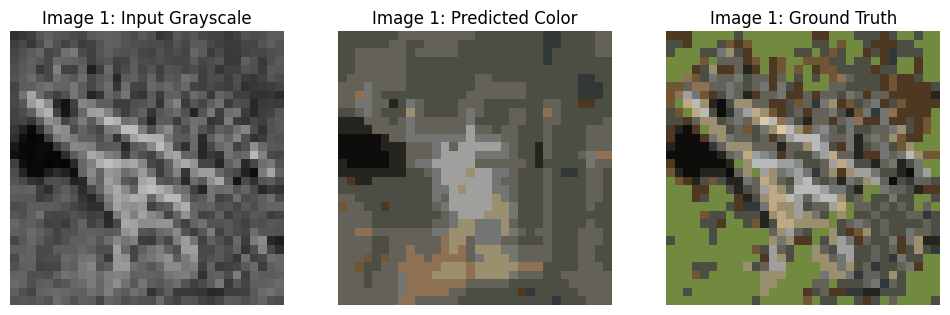

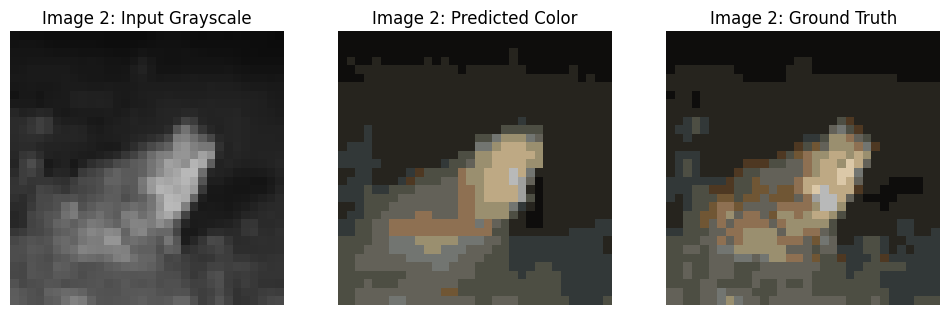

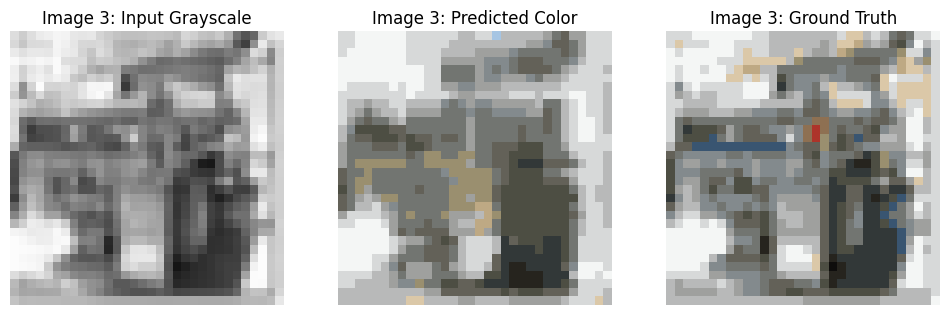

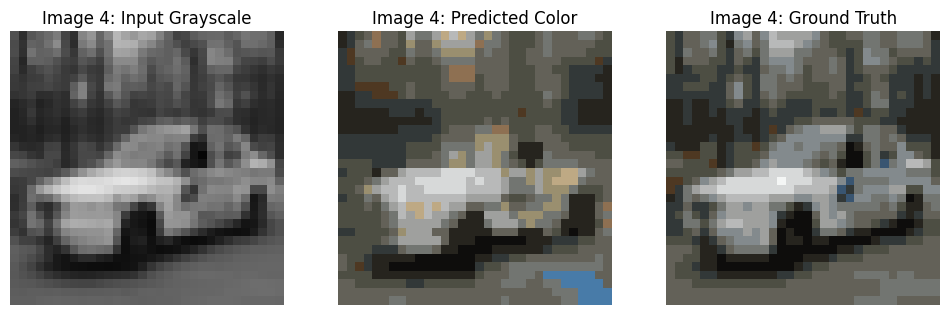

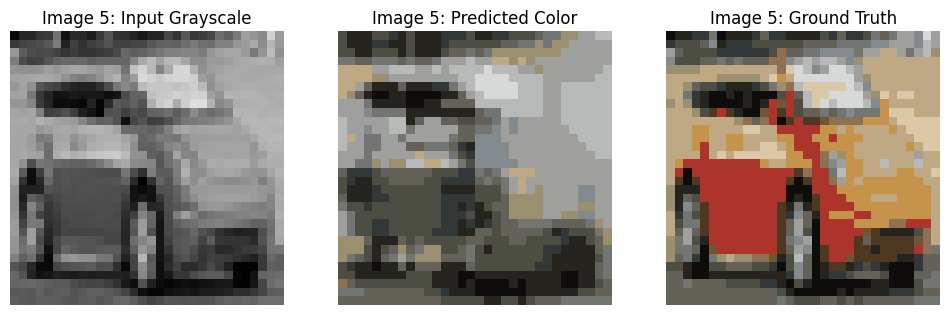

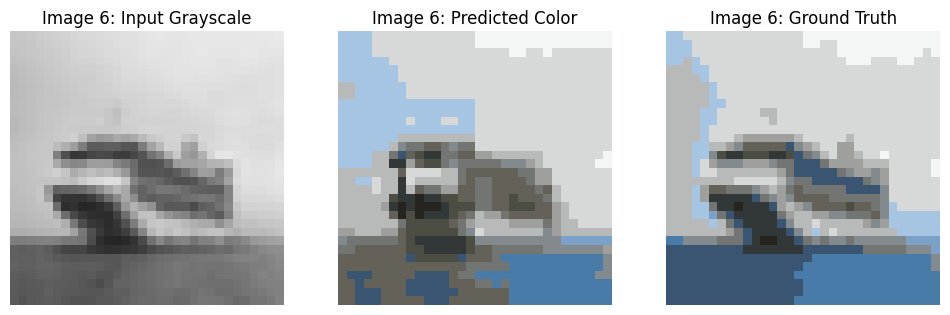

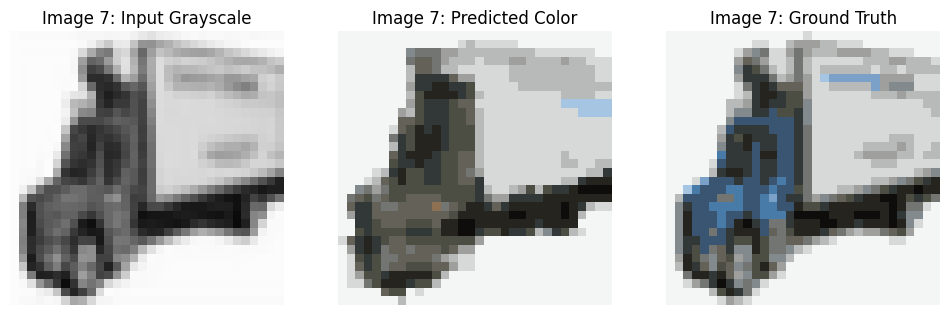

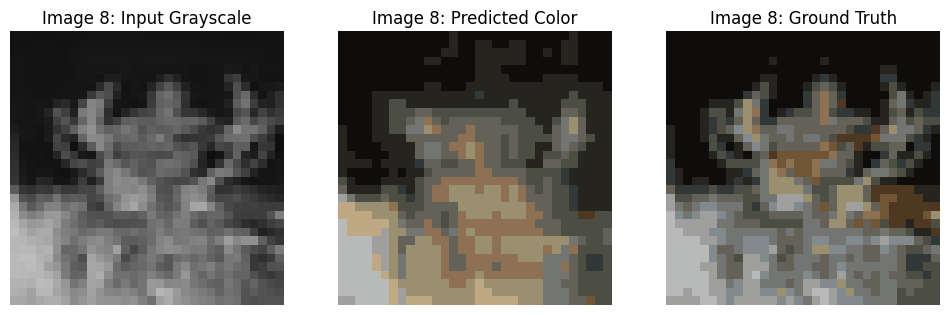

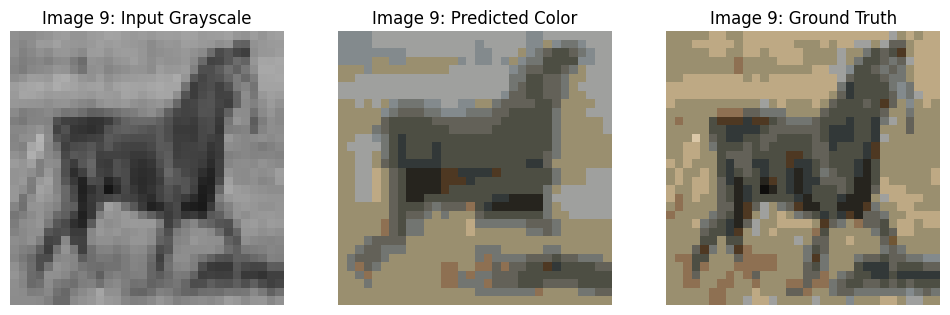

Logged example images.
Best model checkpoints/bs64_ks3_lr0.003_nf16_optSGD.pth saved to wandb.


wandb: Agent Starting Run: v3yt3f51 with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 8
wandb: 	optimizer: Adam


--- Starting Run: bs64_ks5_lr0.001_nf8_optAdam ---
Config: {'batch_size': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'num_filters': 8, 'optimizer': 'Adam'}
Checkpoints will be saved to checkpoints/bs64_ks5_lr0.001_nf8_optAdam.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s]


Finished Training for bs64_ks5_lr0.001_nf8_optAdam. Best Val Loss: 1.6299
Generating example colorizations...


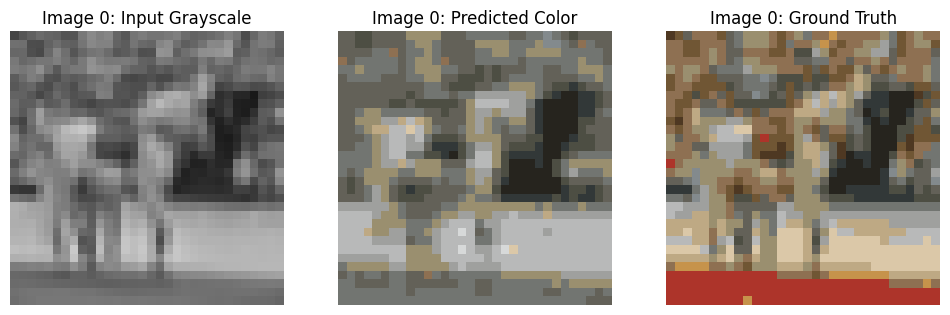

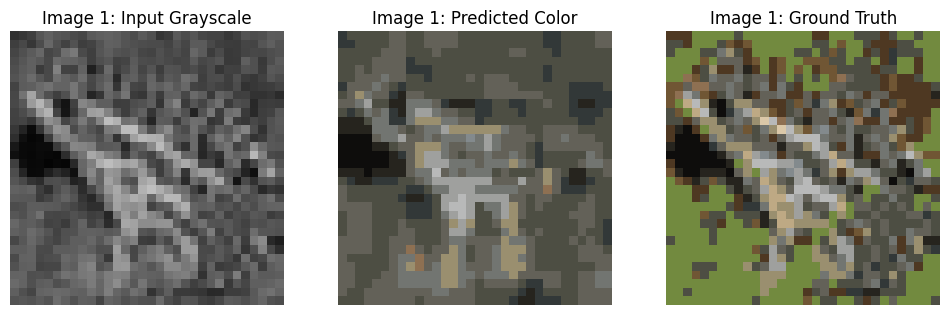

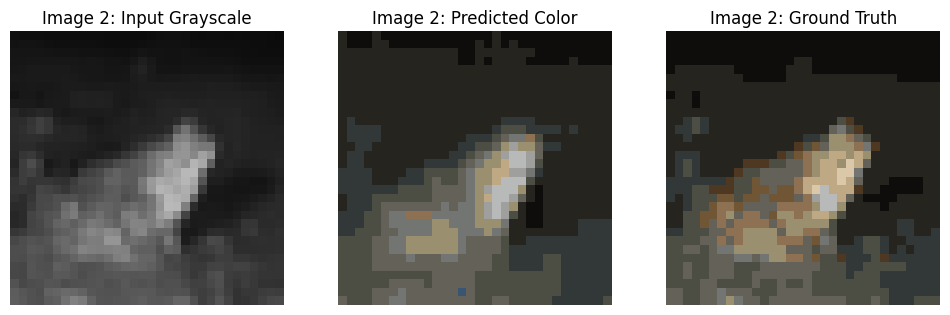

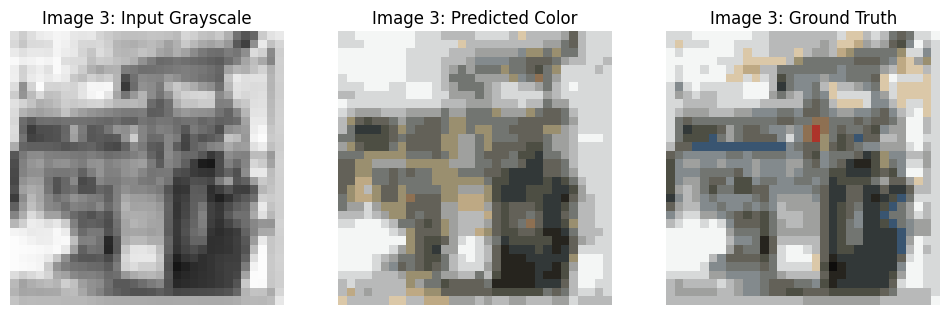

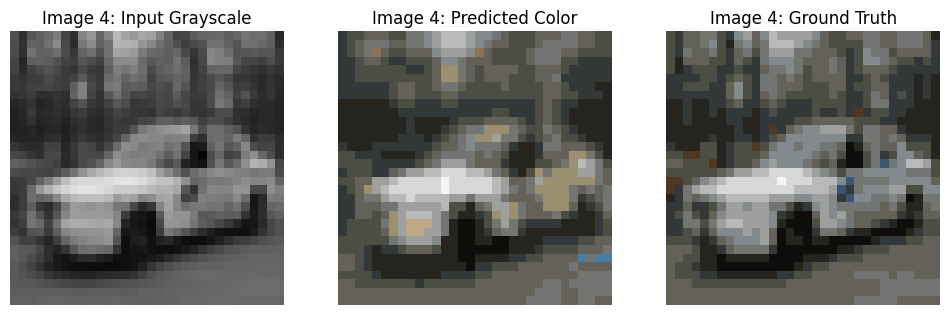

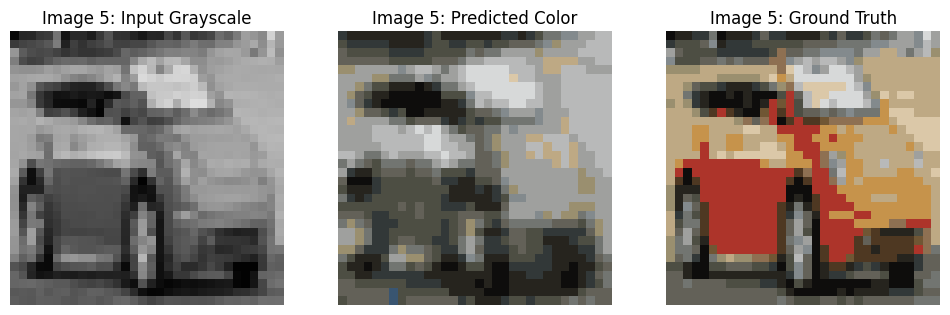

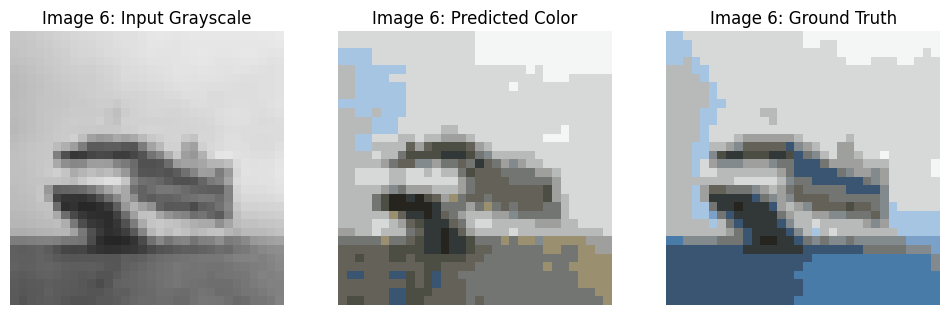

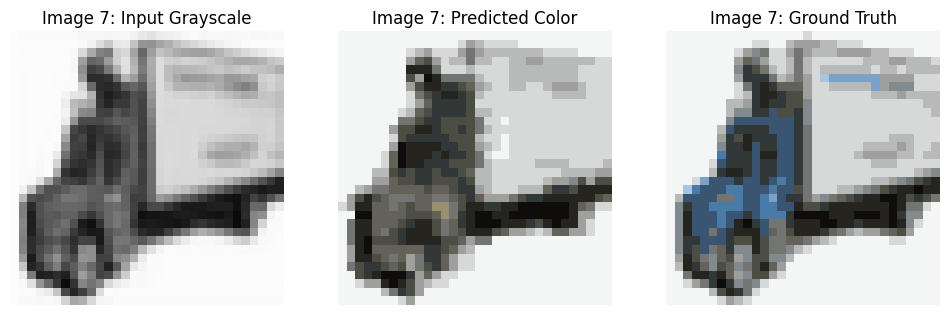

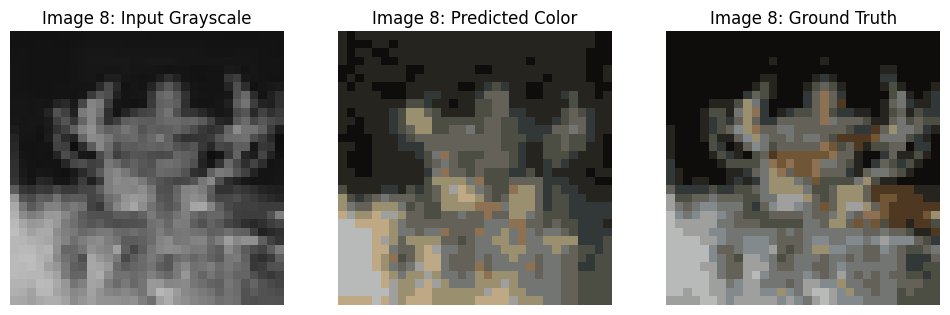

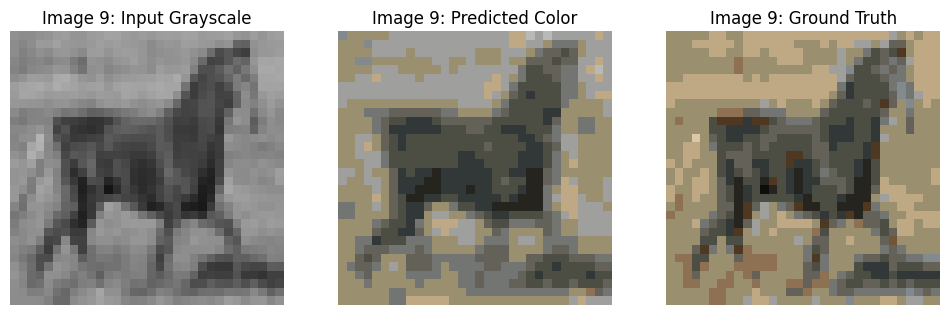

Logged example images.
Best model checkpoints/bs64_ks5_lr0.001_nf8_optAdam.pth saved to wandb.


wandb: Agent Starting Run: kse1j2wp with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 16
wandb: 	optimizer: Adam


--- Starting Run: bs64_ks3_lr0.0001_nf16_optAdam ---
Config: {'batch_size': 64, 'kernel_size': 3, 'learning_rate': 0.0001, 'num_filters': 16, 'optimizer': 'Adam'}
Checkpoints will be saved to checkpoints/bs64_ks3_lr0.0001_nf16_optAdam.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.04it/s]


Finished Training for bs64_ks3_lr0.0001_nf16_optAdam. Best Val Loss: 1.7573
Generating example colorizations...


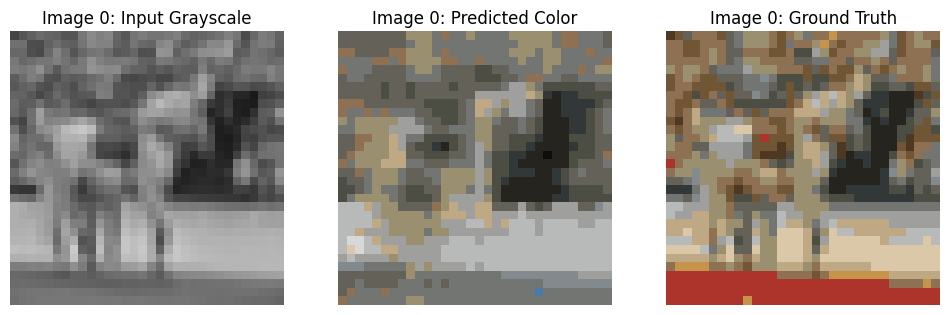

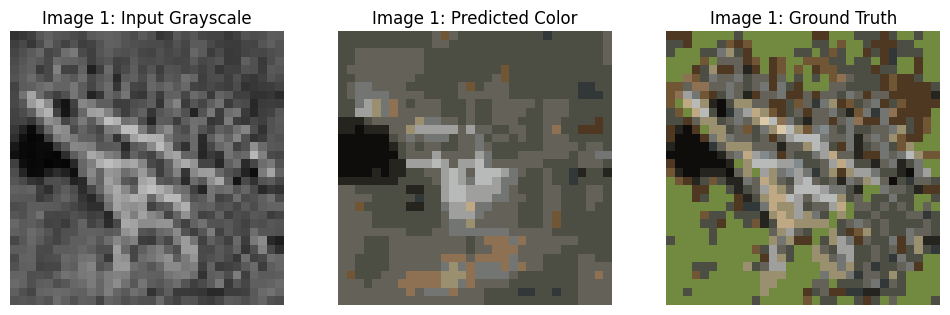

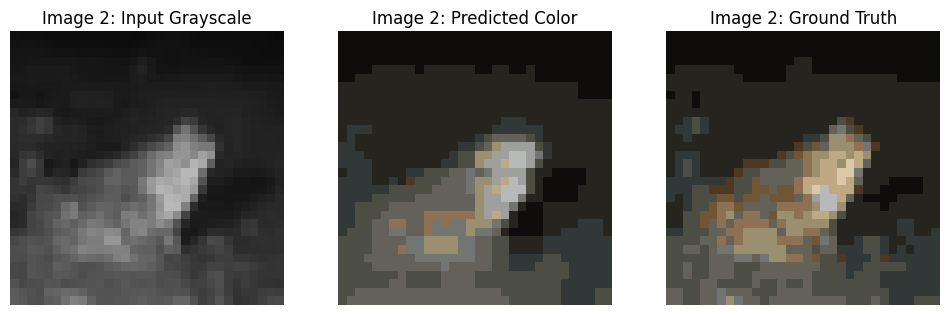

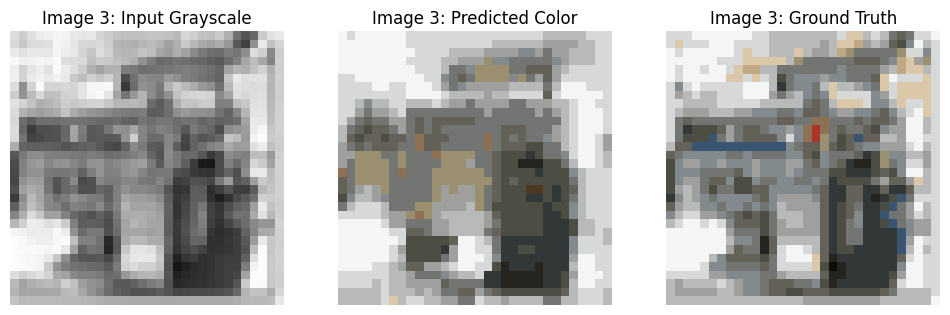

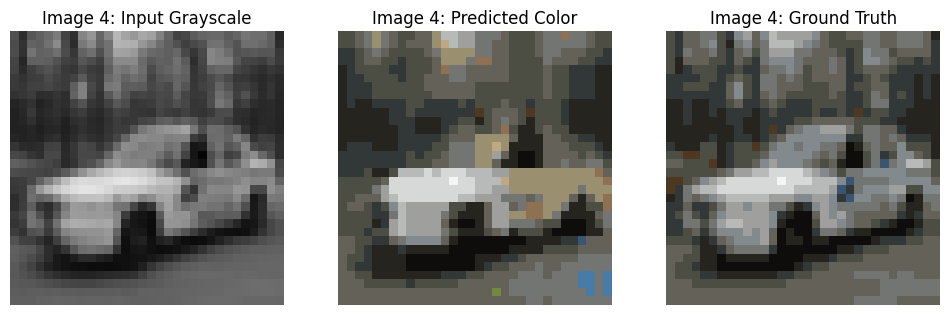

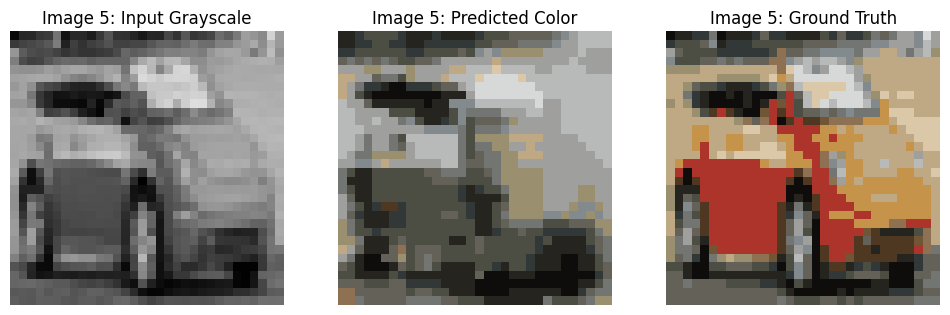

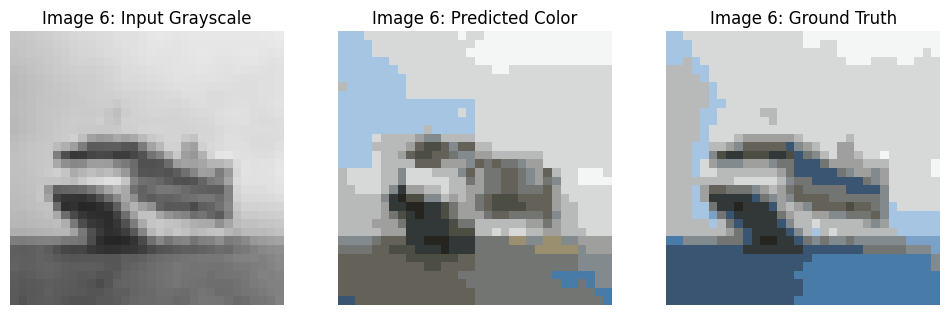

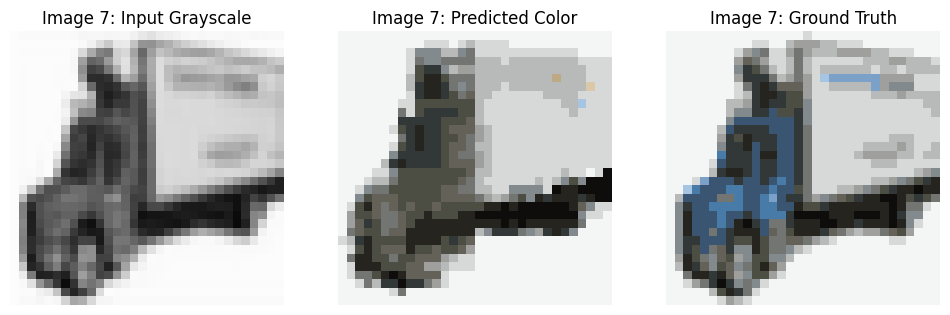

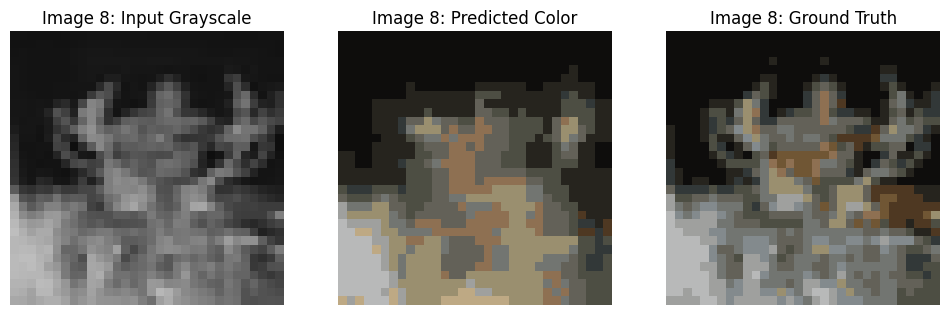

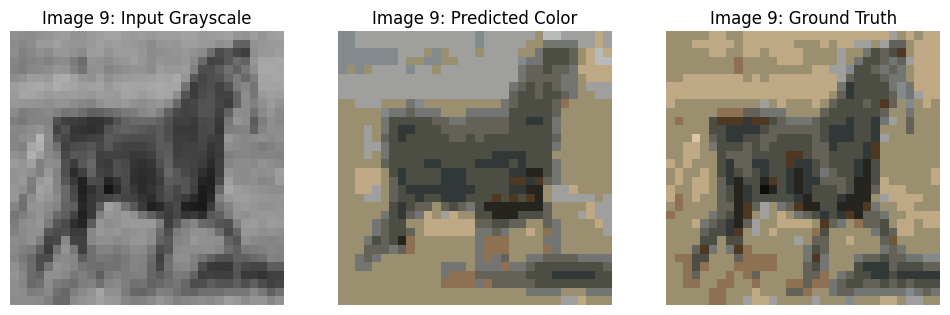

Logged example images.
Best model checkpoints/bs64_ks3_lr0.0001_nf16_optAdam.pth saved to wandb.


wandb: Agent Starting Run: 618yq5b1 with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 32
wandb: 	optimizer: Adam


--- Starting Run: bs32_ks5_lr0.003_nf32_optAdam ---
Config: {'batch_size': 32, 'kernel_size': 5, 'learning_rate': 0.003, 'num_filters': 32, 'optimizer': 'Adam'}
Checkpoints will be saved to checkpoints/bs32_ks5_lr0.003_nf32_optAdam.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 51.52it/s]


Finished Training for bs32_ks5_lr0.003_nf32_optAdam. Best Val Loss: 1.2794
Generating example colorizations...


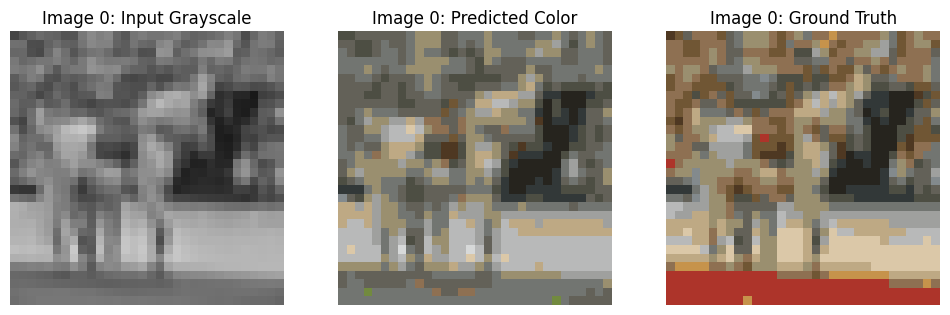

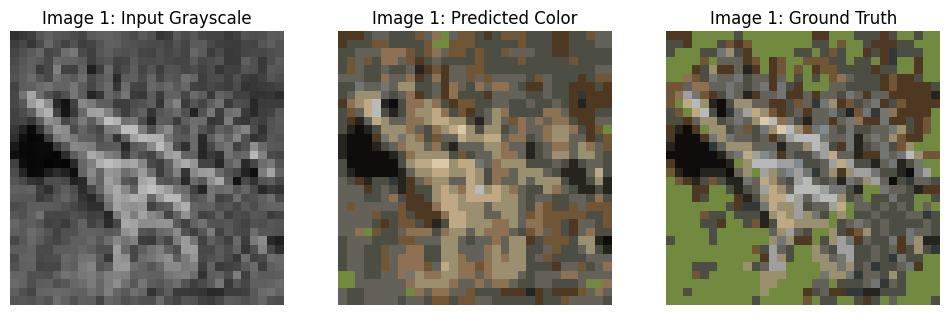

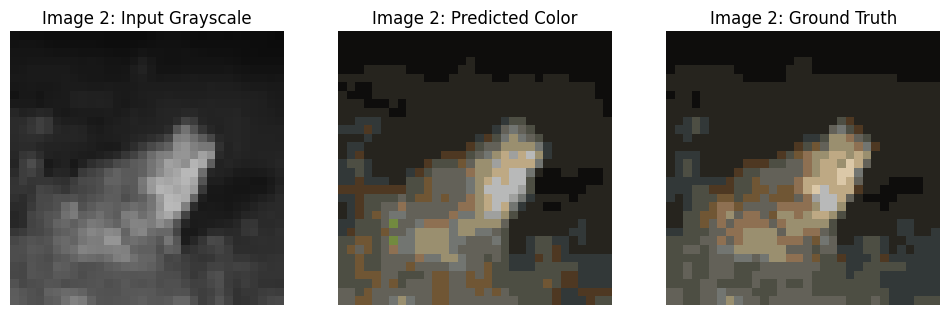

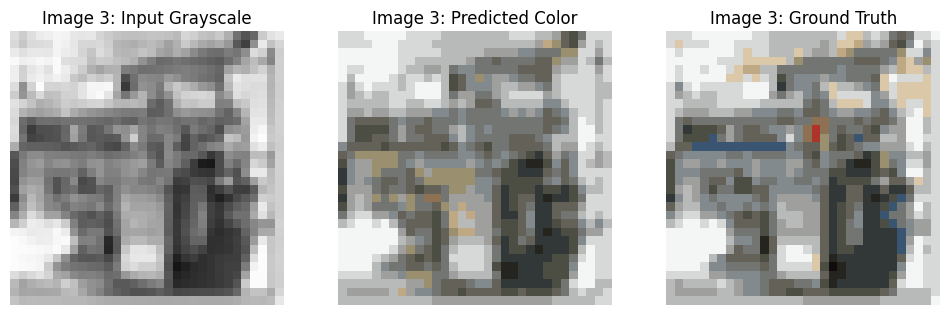

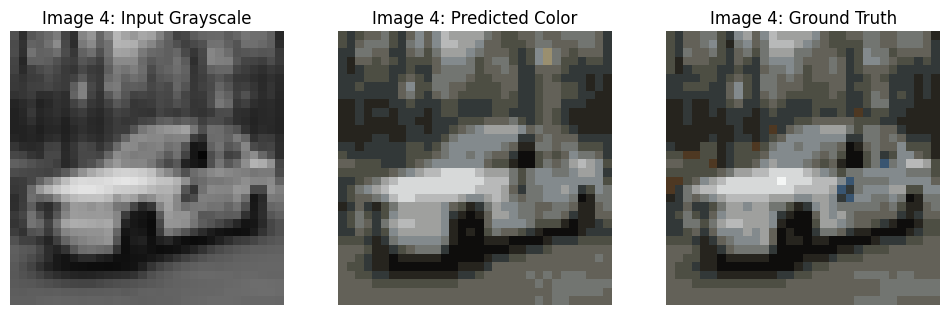

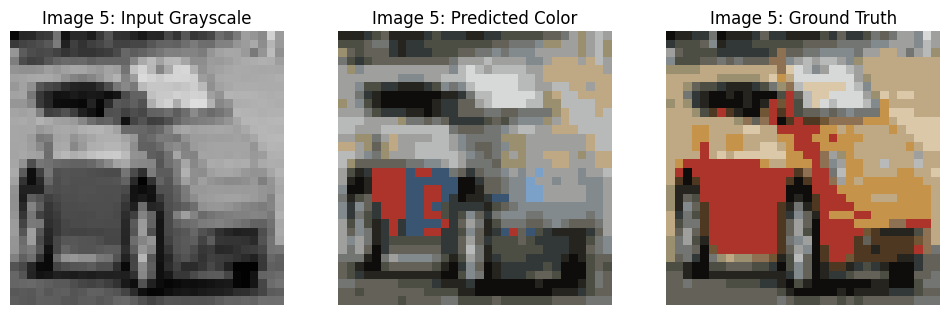

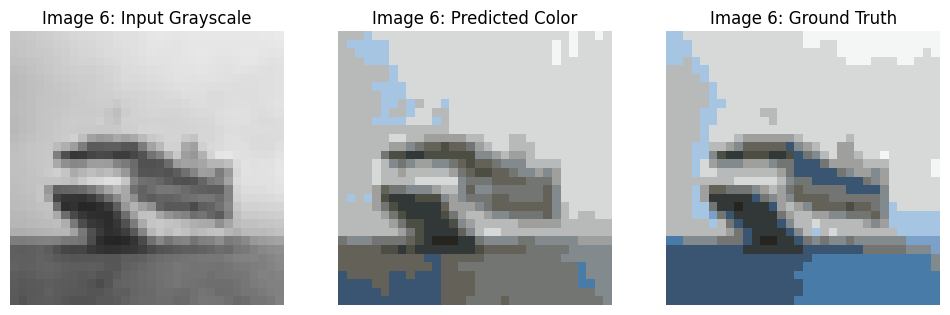

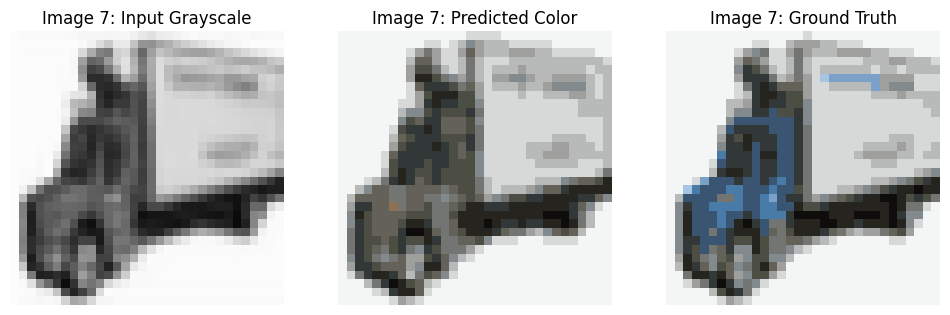

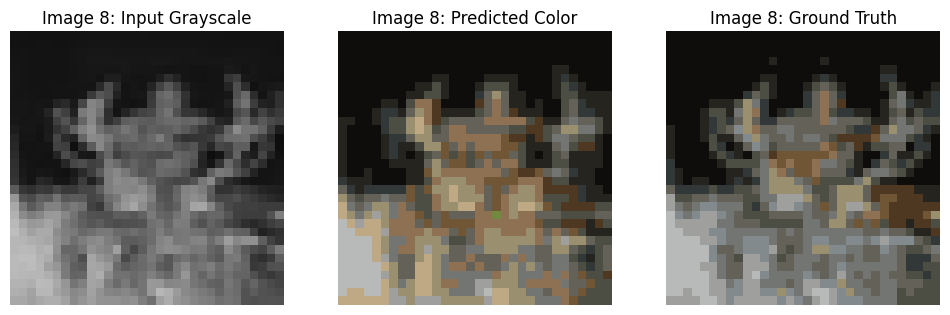

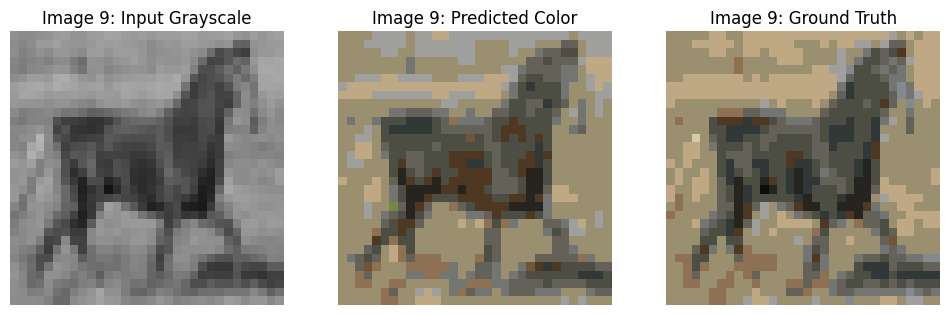

Logged example images.
Best model checkpoints/bs32_ks5_lr0.003_nf32_optAdam.pth saved to wandb.


wandb: Agent Starting Run: sz2wutmw with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks5_lr0.0003_nf16_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 5, 'learning_rate': 0.0003, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks5_lr0.0003_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.09it/s]


Finished Training for bs64_ks5_lr0.0003_nf16_optSGD. Best Val Loss: 2.0717
Generating example colorizations...


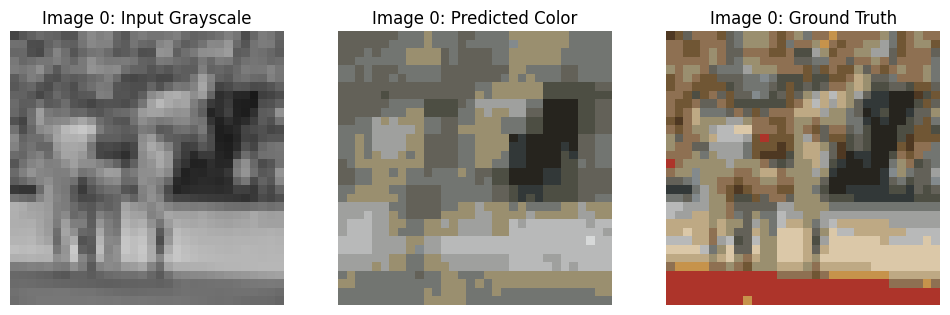

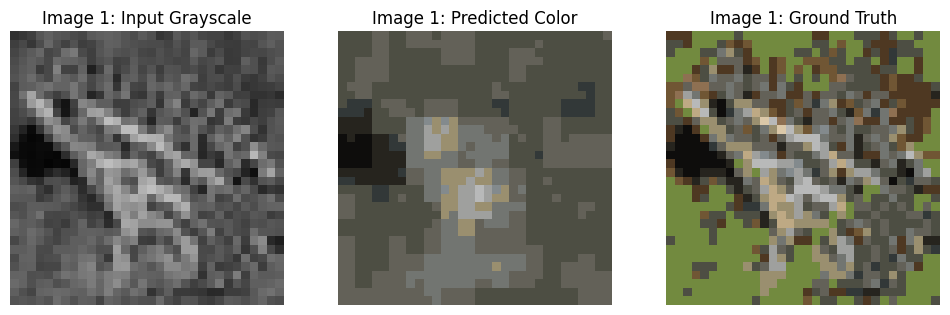

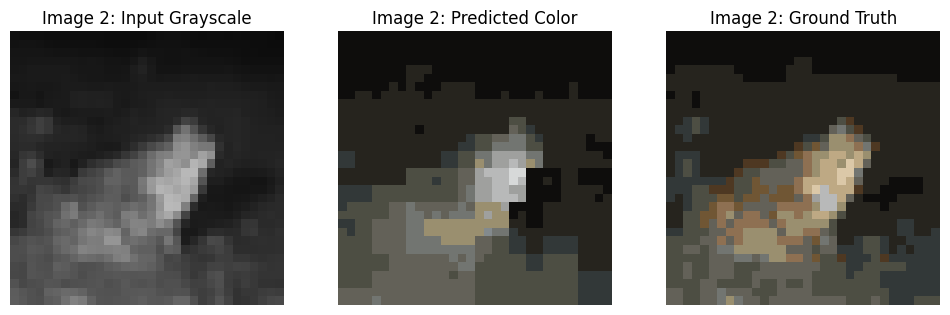

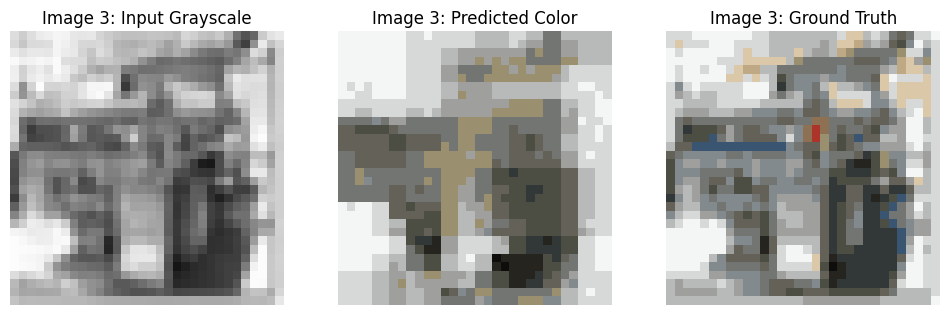

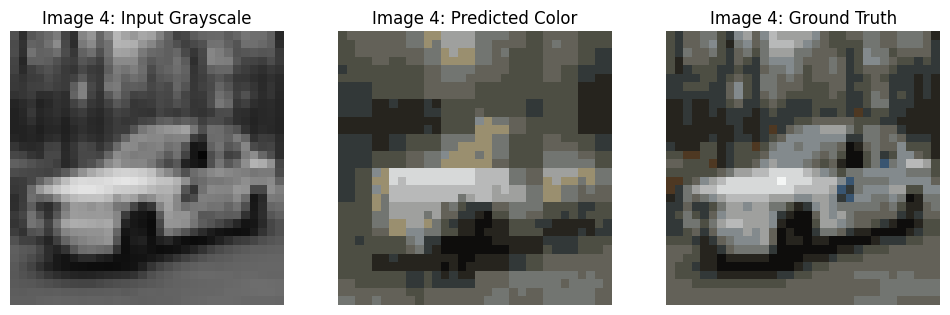

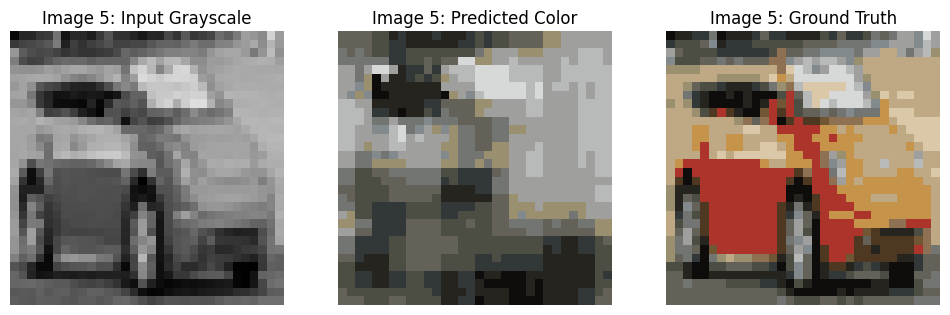

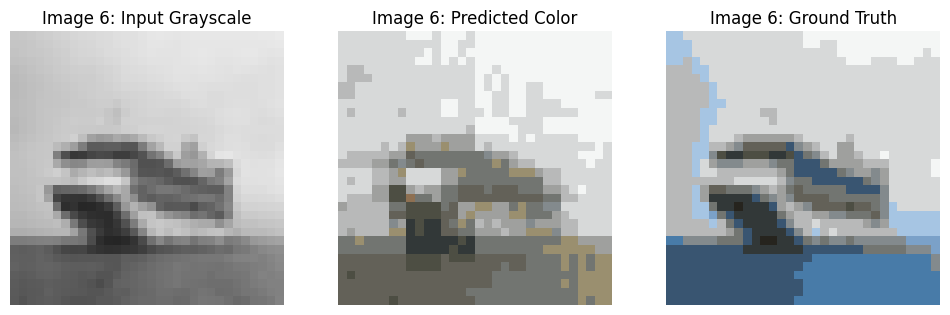

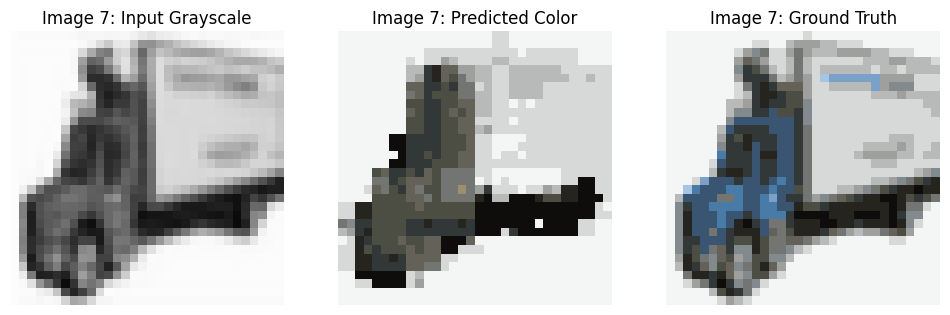

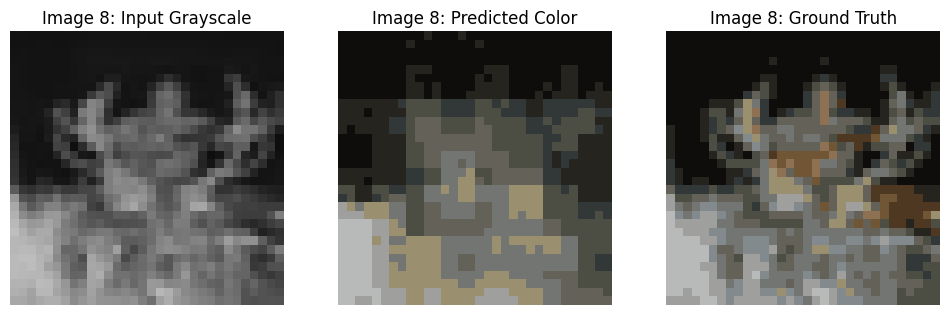

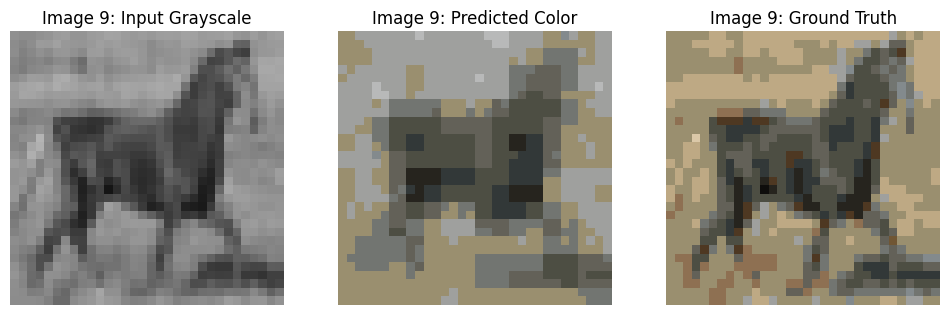

Logged example images.
Best model checkpoints/bs64_ks5_lr0.0003_nf16_optSGD.pth saved to wandb.


wandb: Agent Starting Run: hgix46bu with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs32_ks3_lr0.003_nf16_optSGD ---
Config: {'batch_size': 32, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs32_ks3_lr0.003_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 52.15it/s]


Finished Training for bs32_ks3_lr0.003_nf16_optSGD. Best Val Loss: 1.7256
Generating example colorizations...


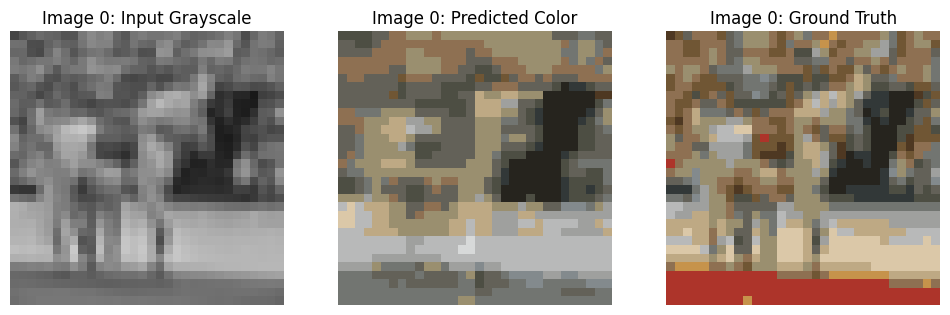

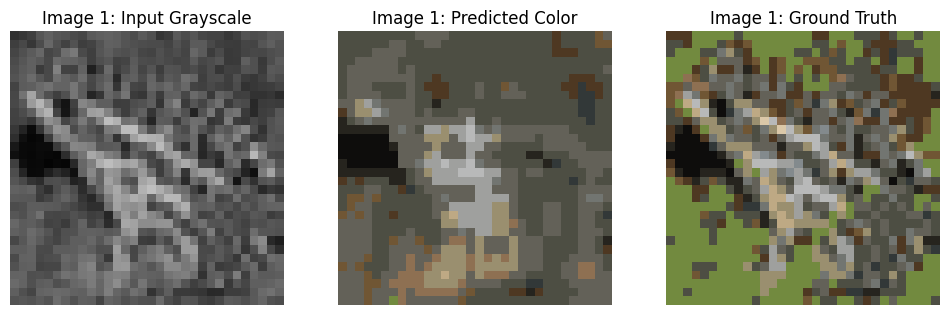

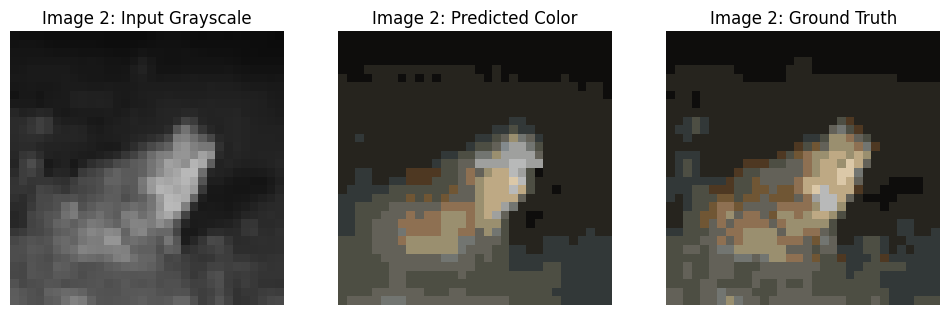

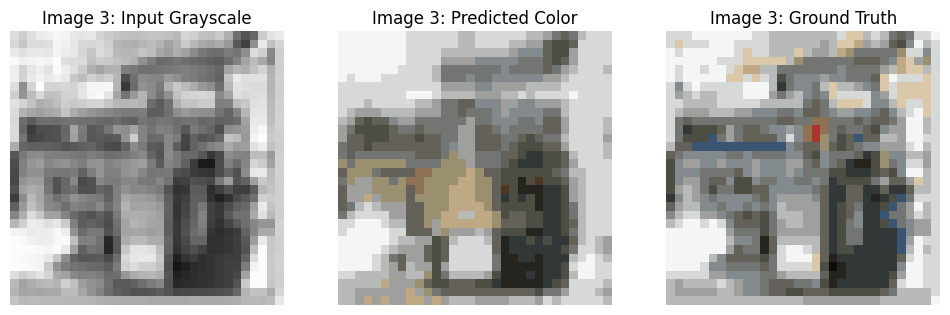

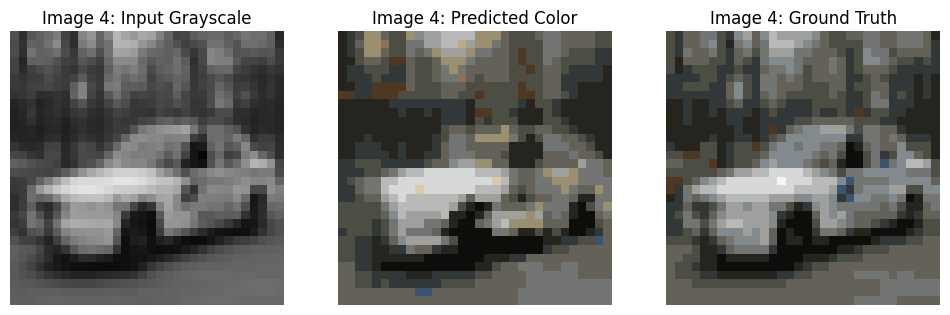

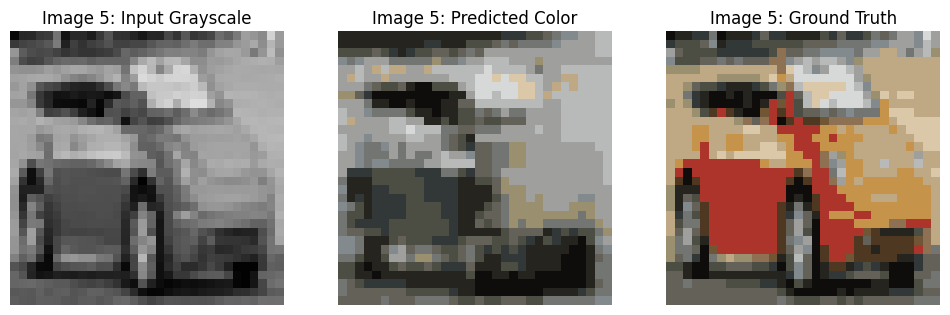

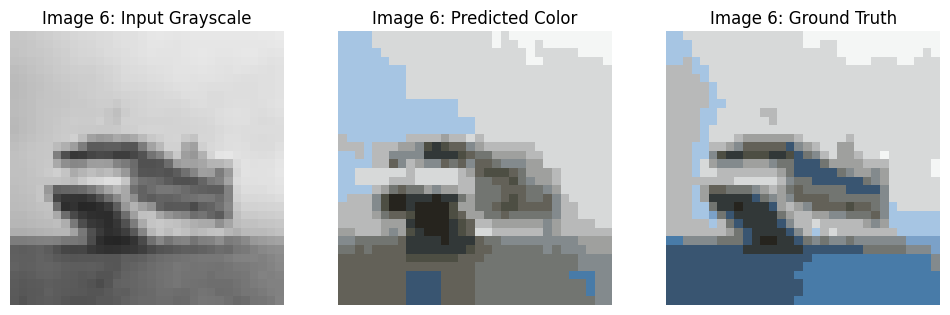

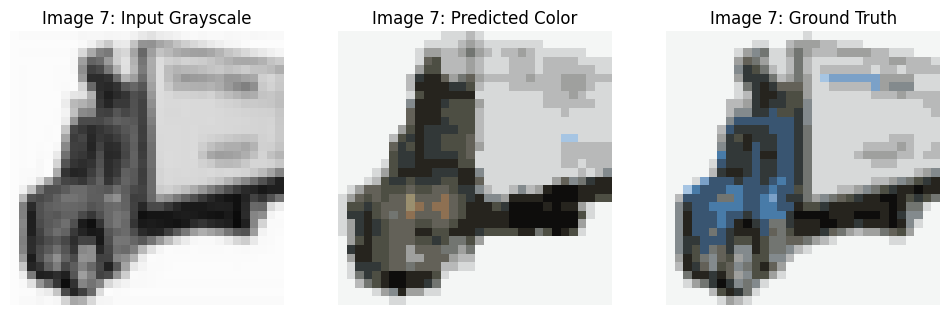

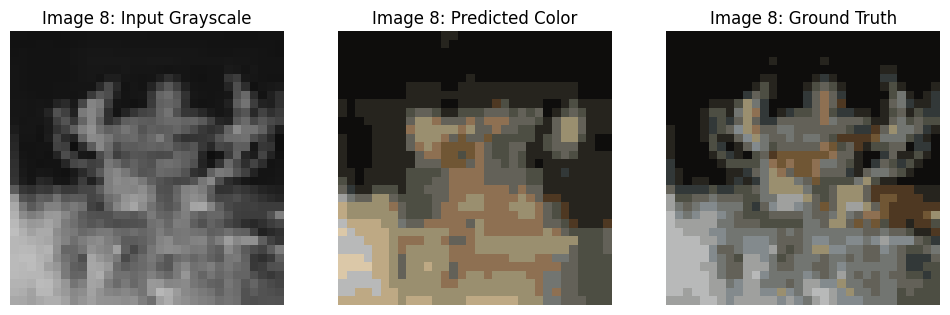

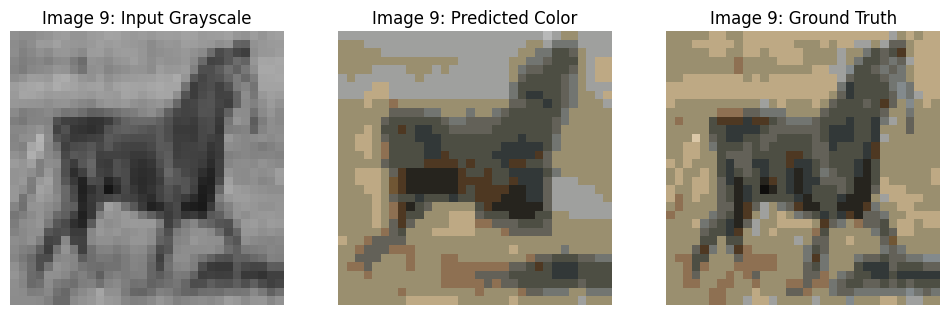

Logged example images.
Best model checkpoints/bs32_ks3_lr0.003_nf16_optSGD.pth saved to wandb.


wandb: Agent Starting Run: 080rypui with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 8
wandb: 	optimizer: SGD


--- Starting Run: bs32_ks3_lr0.003_nf8_optSGD ---
Config: {'batch_size': 32, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 8, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs32_ks3_lr0.003_nf8_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 51.03it/s]


Finished Training for bs32_ks3_lr0.003_nf8_optSGD. Best Val Loss: 1.8724
Generating example colorizations...


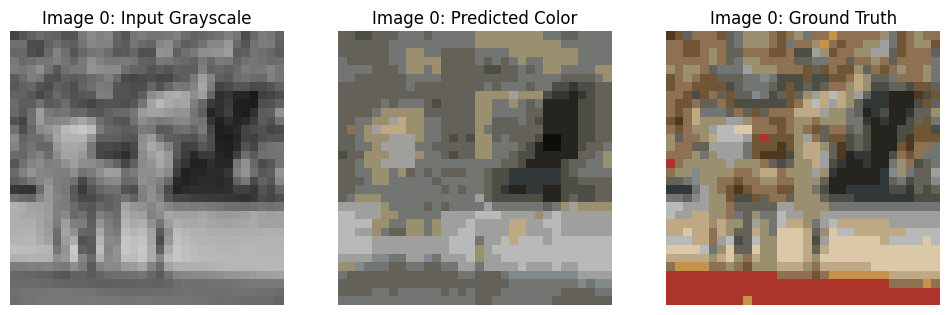

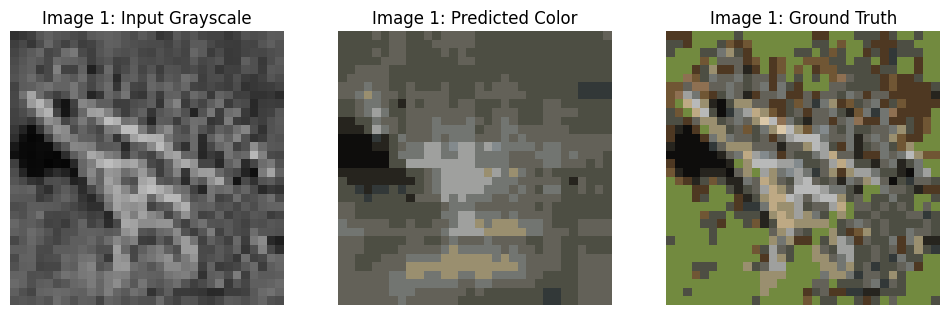

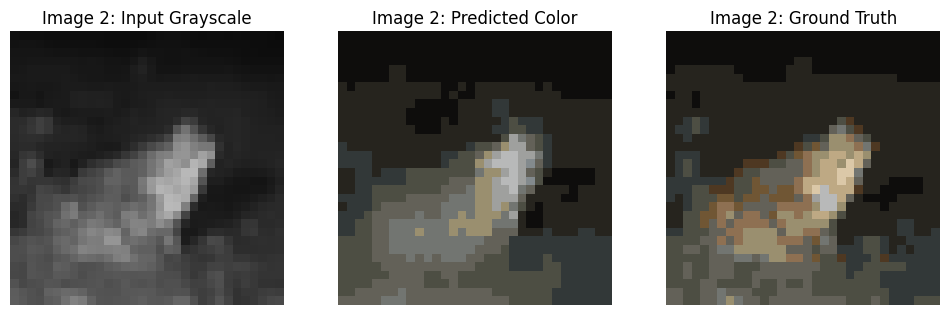

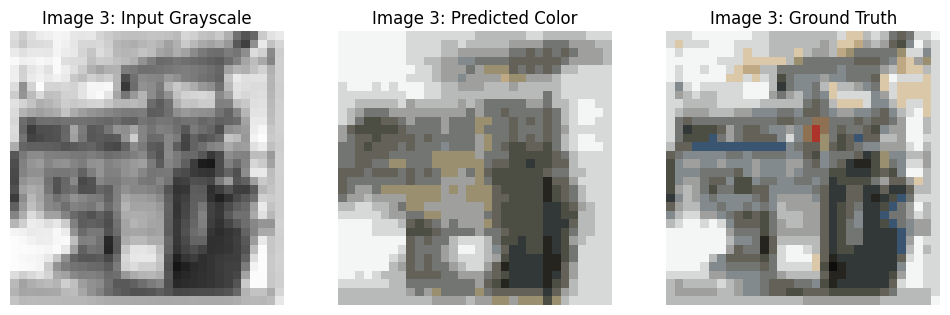

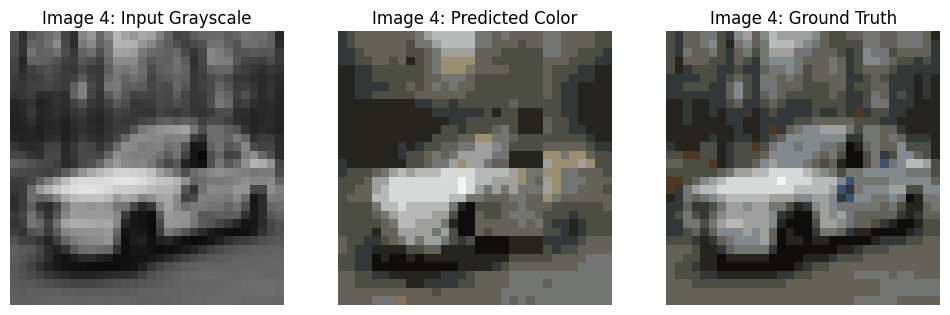

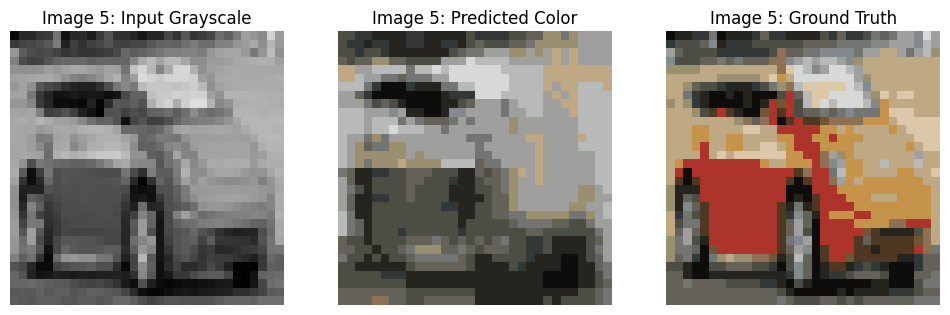

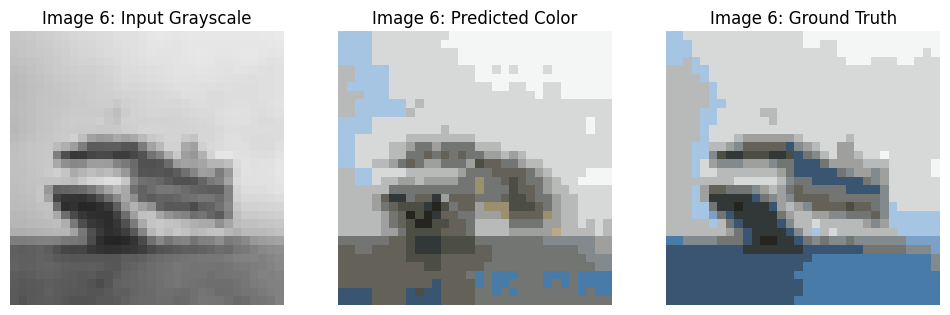

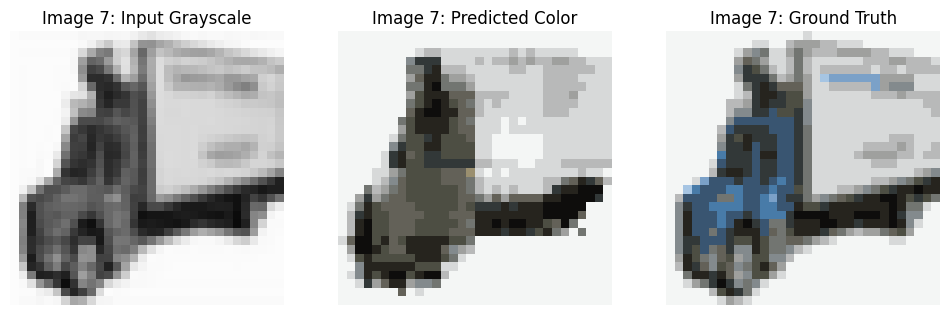

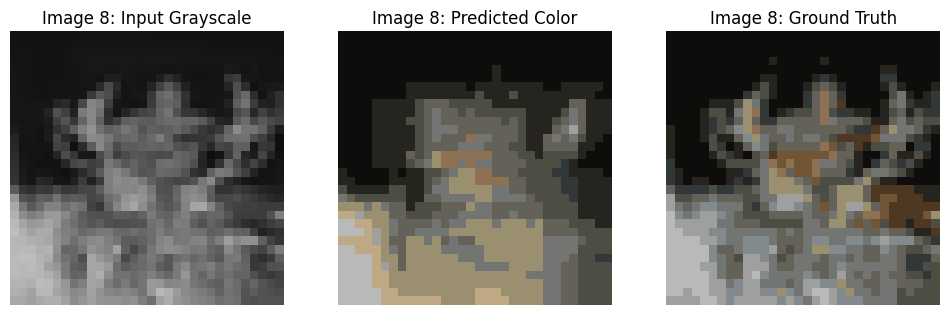

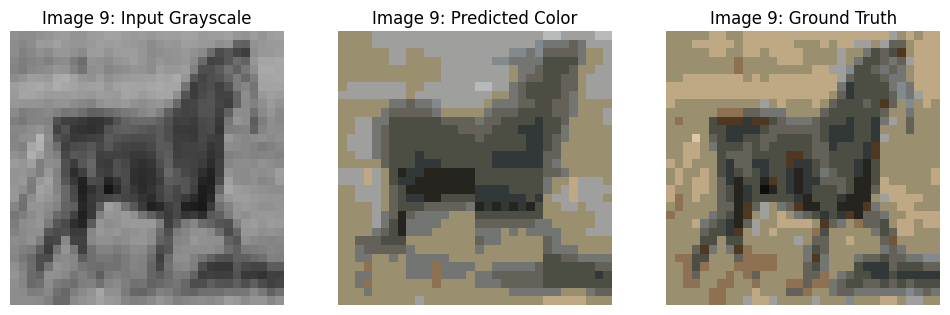

Logged example images.
Best model checkpoints/bs32_ks3_lr0.003_nf8_optSGD.pth saved to wandb.


wandb: Agent Starting Run: ayijs0j1 with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 32
wandb: 	optimizer: SGD


--- Starting Run: bs32_ks3_lr0.003_nf32_optSGD ---
Config: {'batch_size': 32, 'kernel_size': 3, 'learning_rate': 0.003, 'num_filters': 32, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs32_ks3_lr0.003_nf32_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 51.56it/s]


Finished Training for bs32_ks3_lr0.003_nf32_optSGD. Best Val Loss: 1.6204
Generating example colorizations...


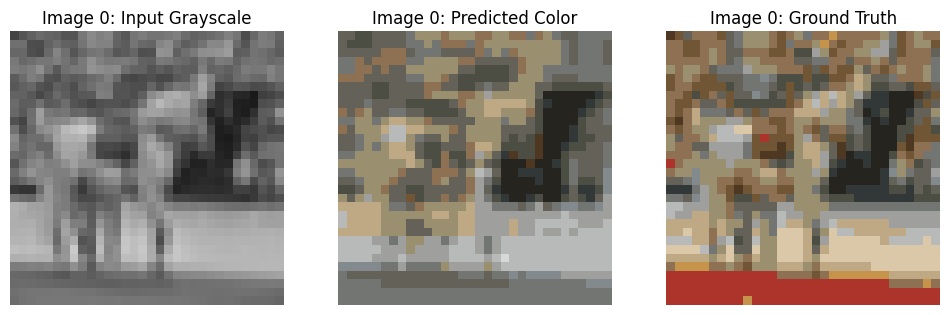

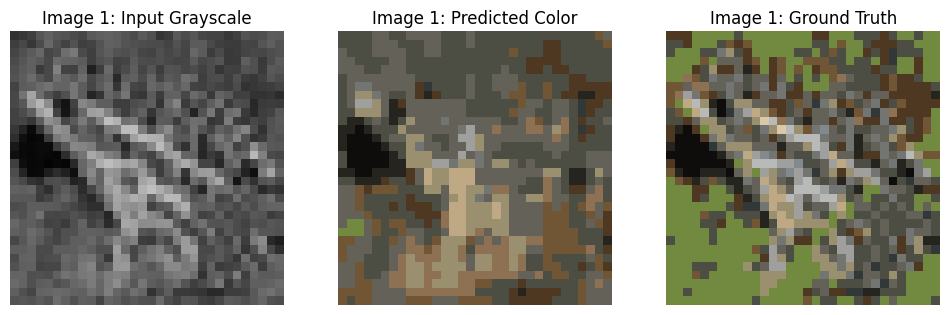

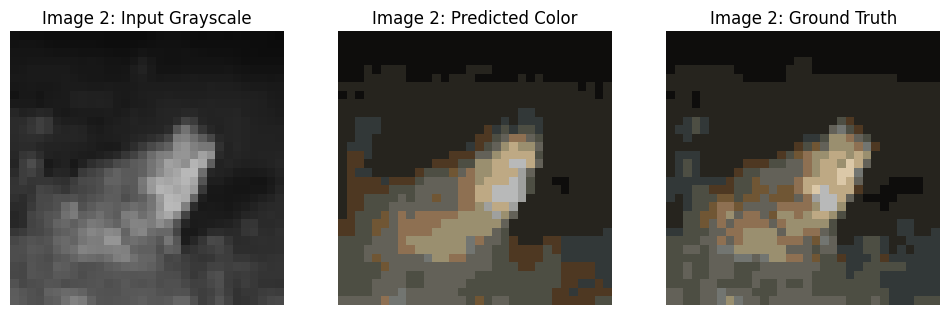

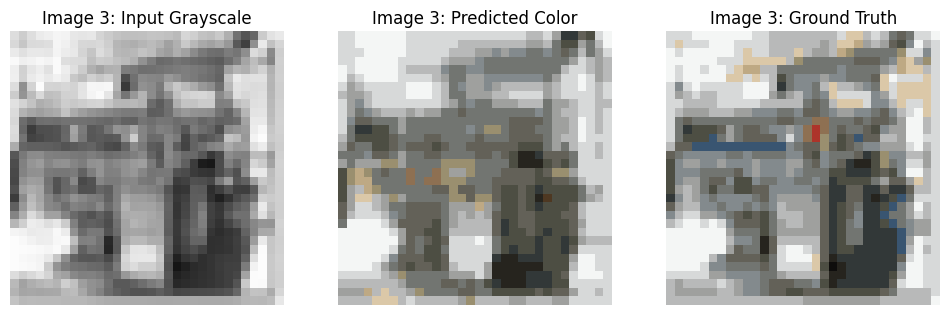

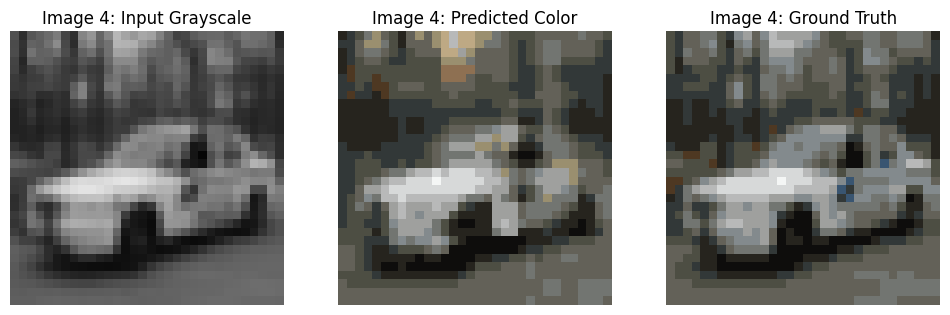

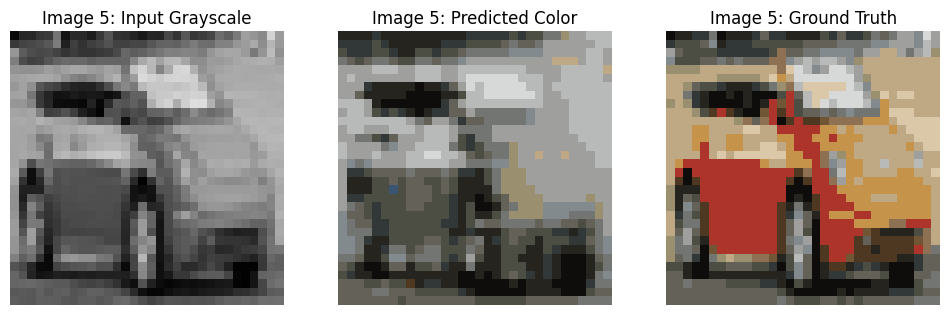

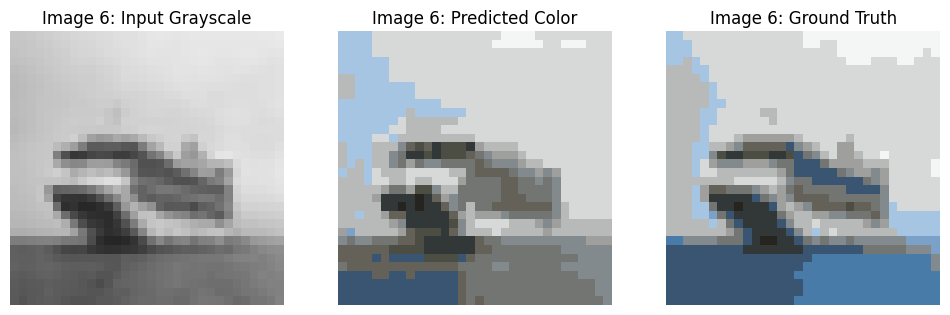

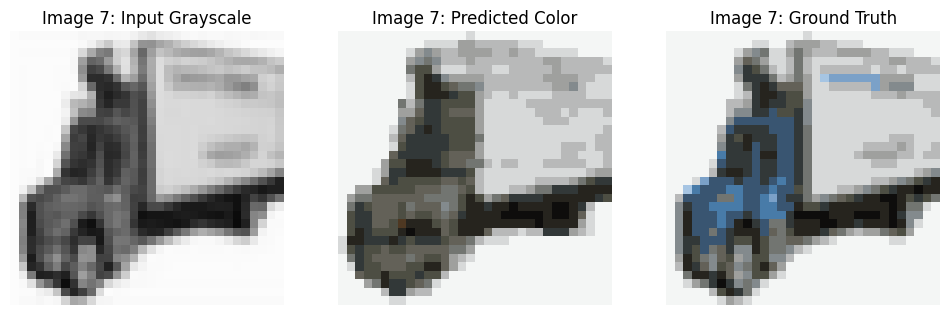

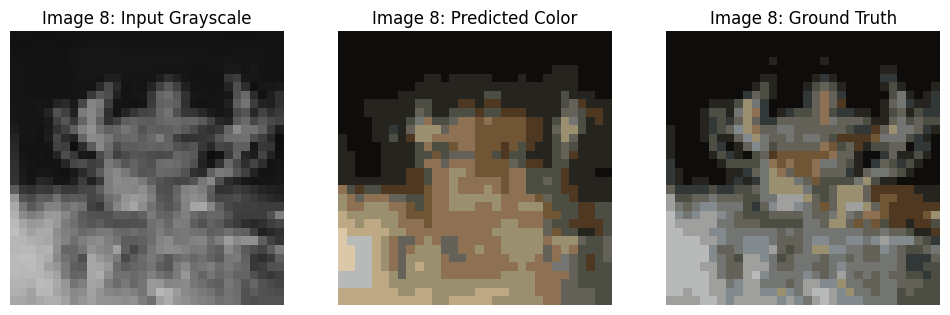

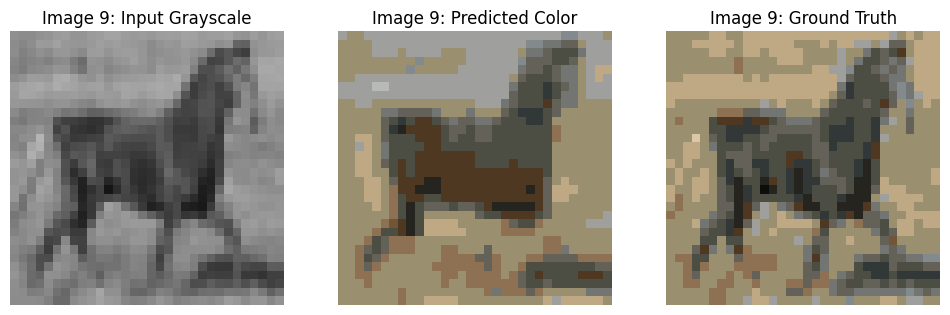

Logged example images.
Best model checkpoints/bs32_ks3_lr0.003_nf32_optSGD.pth saved to wandb.


wandb: Agent Starting Run: nx5lcbxm with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0003
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks3_lr0.0003_nf16_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 3, 'learning_rate': 0.0003, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks3_lr0.0003_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.75it/s]


Finished Training for bs64_ks3_lr0.0003_nf16_optSGD. Best Val Loss: 2.0804
Generating example colorizations...


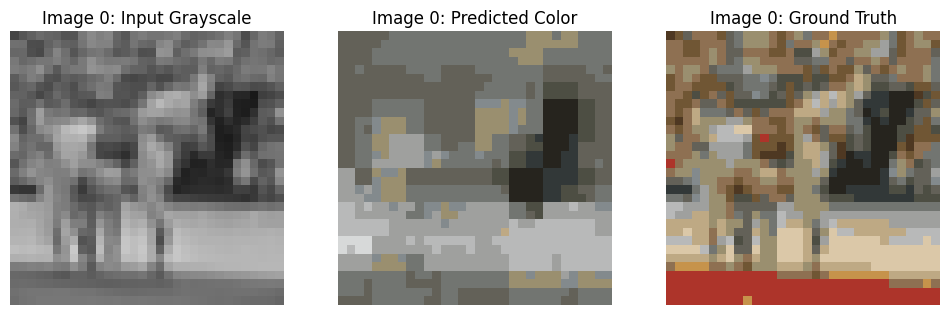

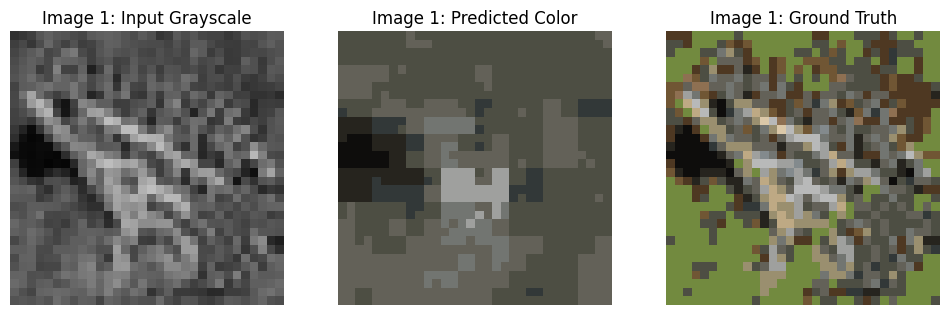

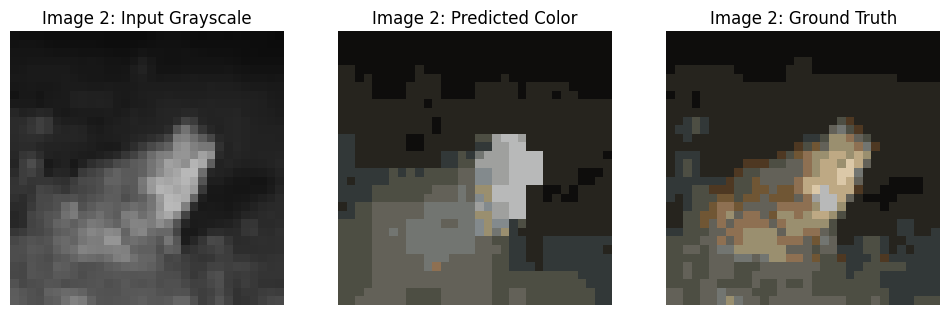

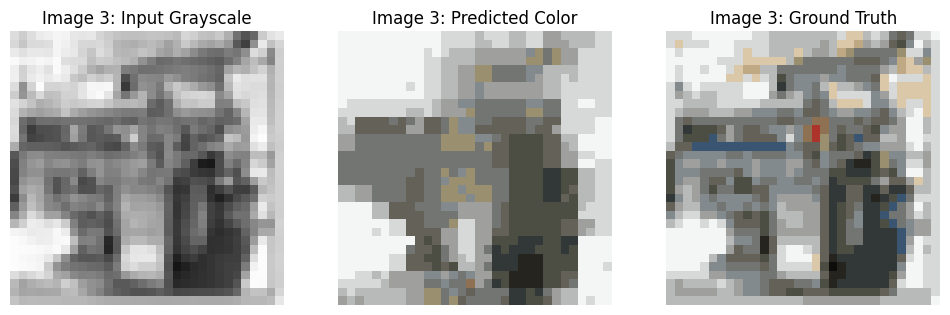

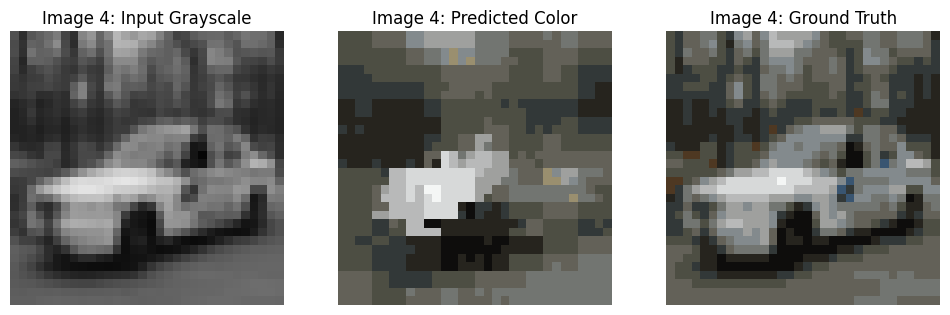

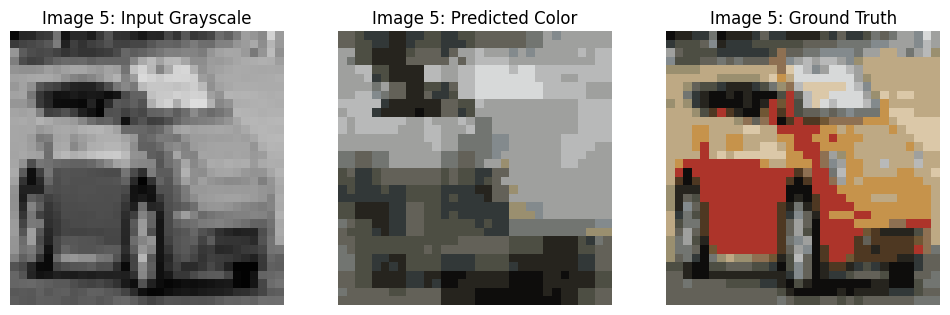

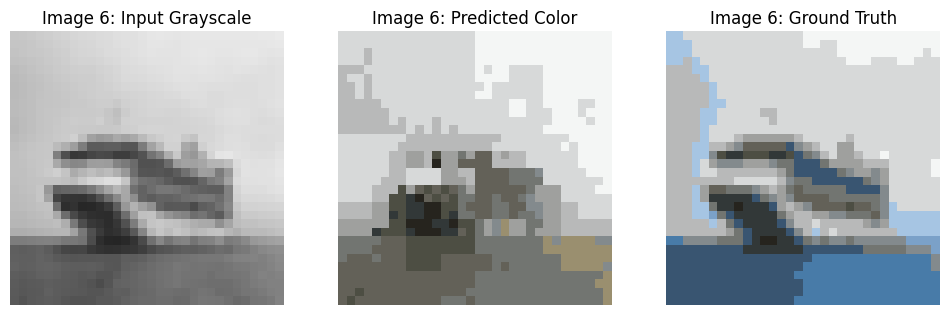

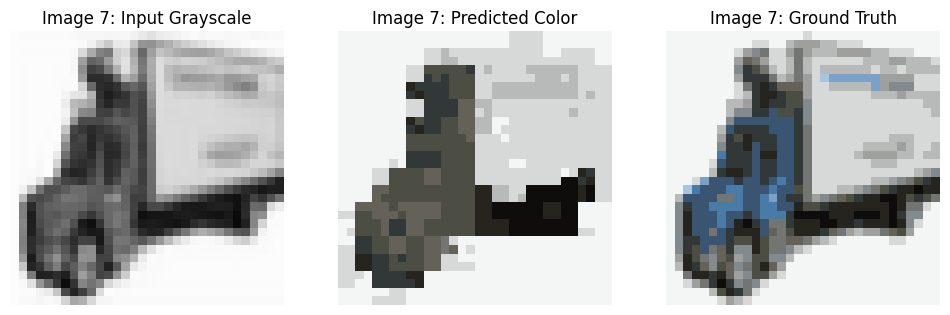

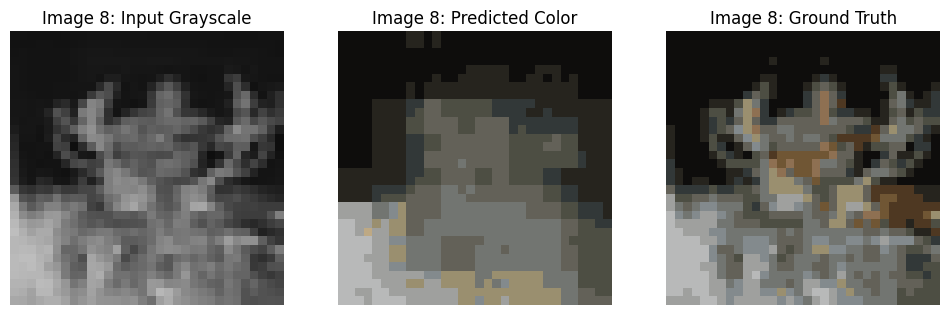

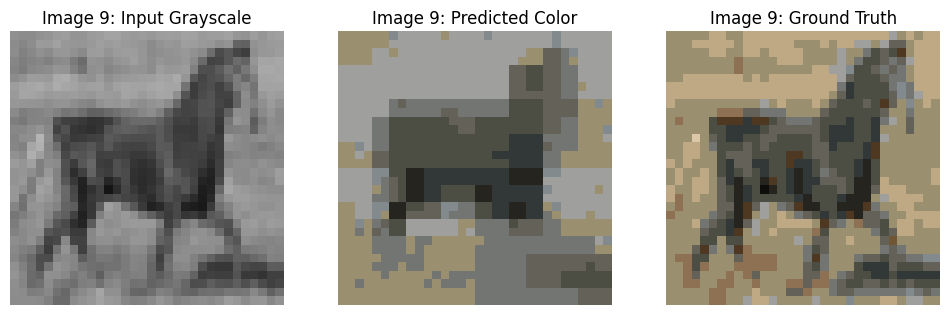

Logged example images.
Best model checkpoints/bs64_ks3_lr0.0003_nf16_optSGD.pth saved to wandb.


wandb: Agent Starting Run: laypbixr with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 32
wandb: 	optimizer: SGD


--- Starting Run: bs32_ks3_lr0.001_nf32_optSGD ---
Config: {'batch_size': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'num_filters': 32, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs32_ks3_lr0.001_nf32_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 49.93it/s]


Finished Training for bs32_ks3_lr0.001_nf32_optSGD. Best Val Loss: 1.6953
Generating example colorizations...


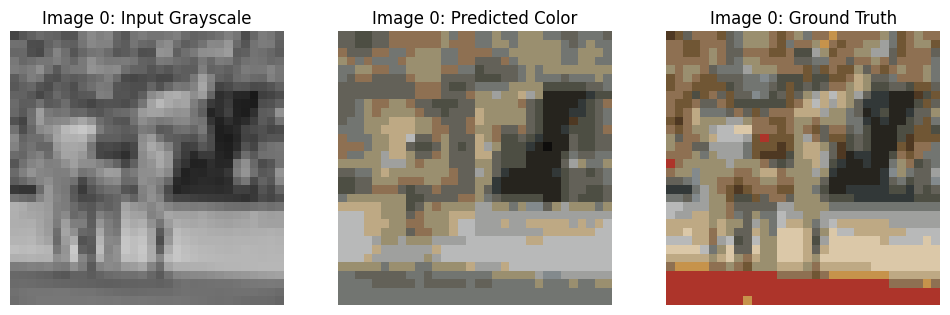

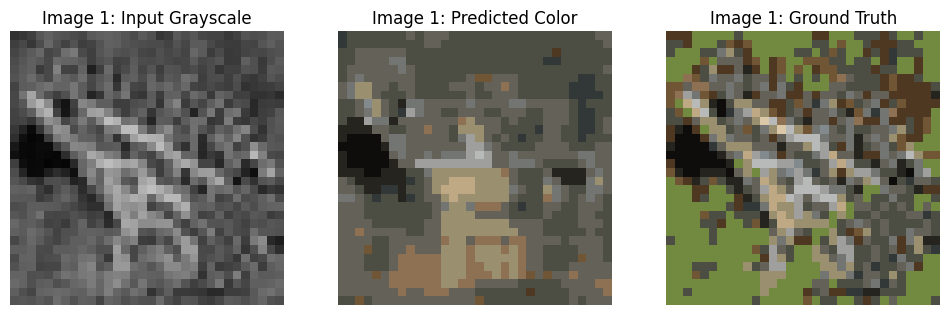

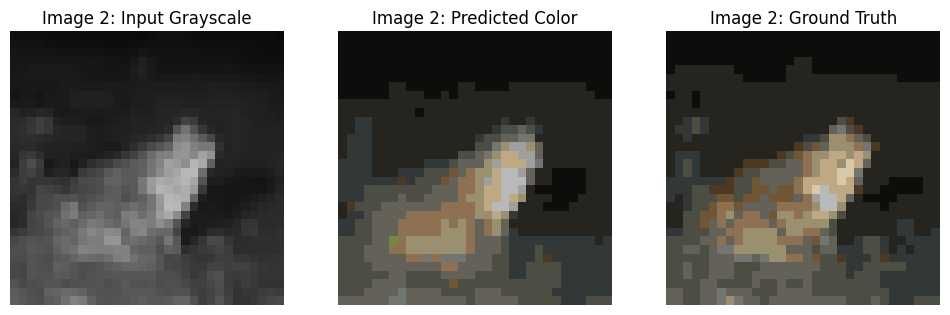

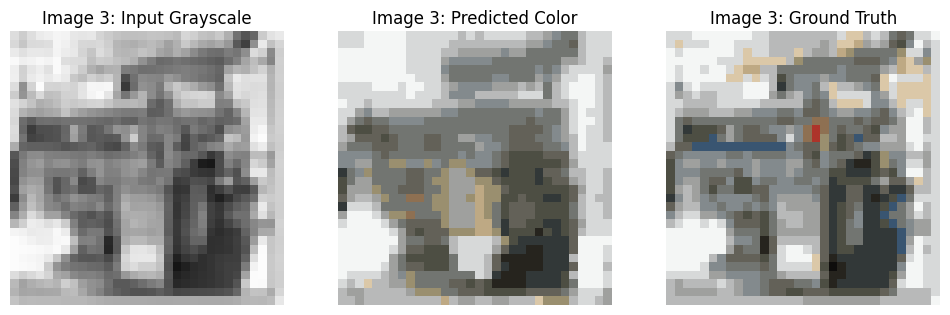

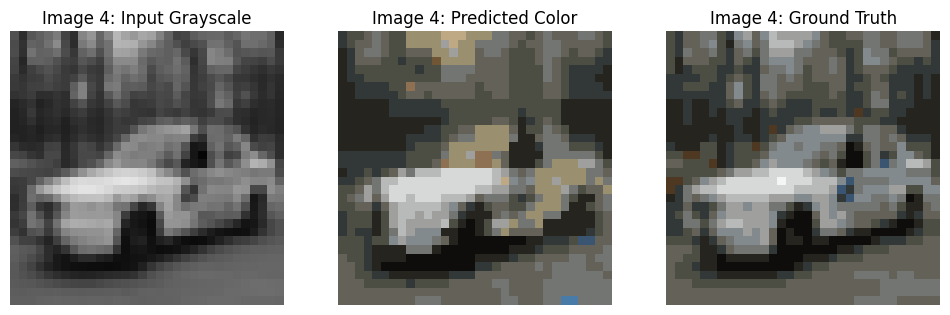

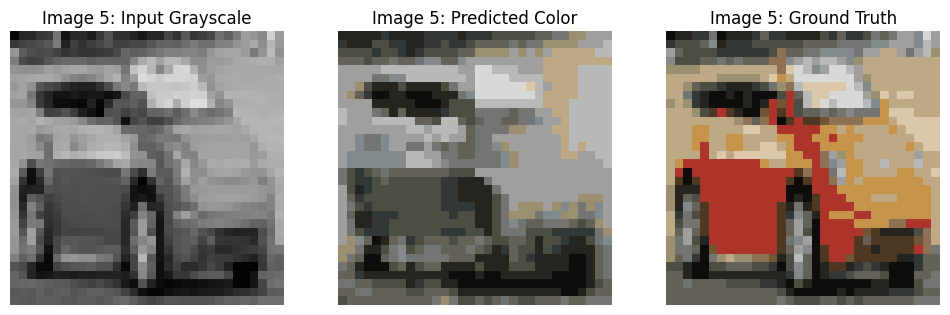

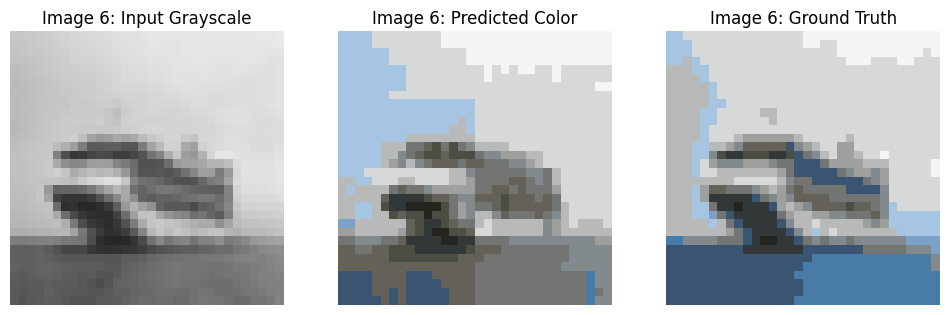

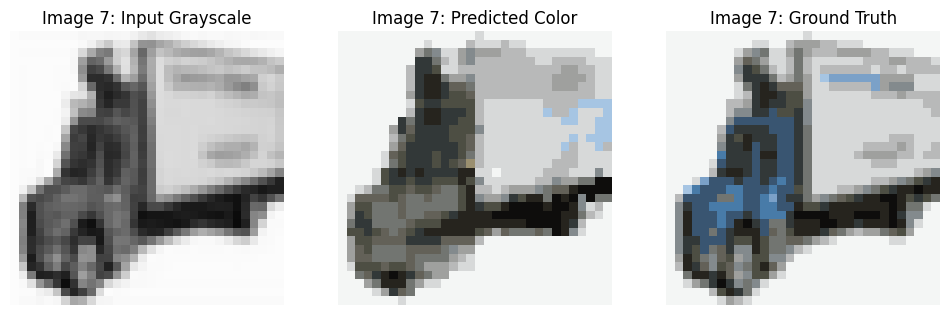

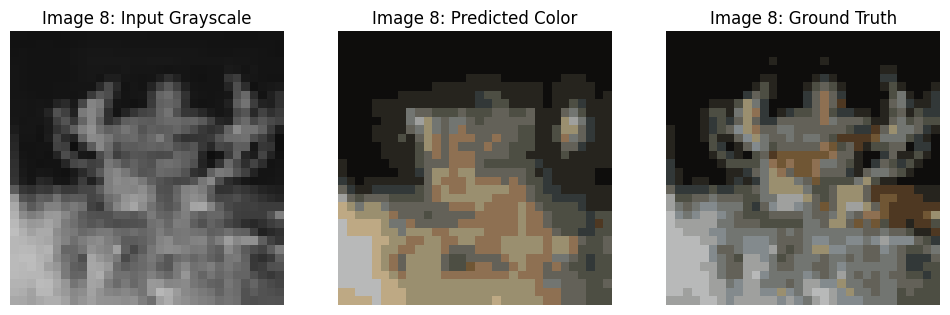

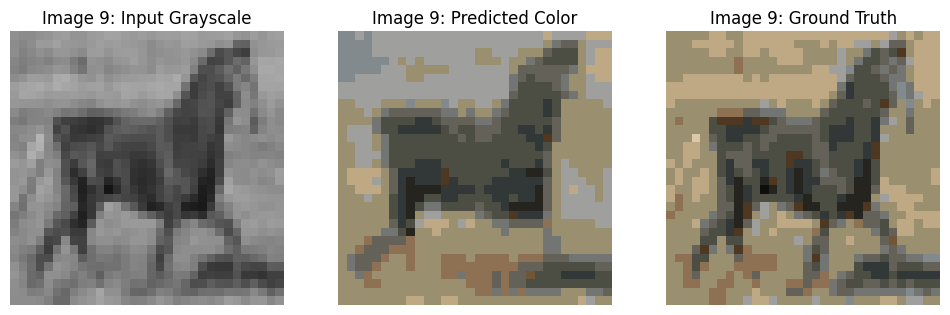

Logged example images.
Best model checkpoints/bs32_ks3_lr0.001_nf32_optSGD.pth saved to wandb.


wandb: Agent Starting Run: v0ao3v07 with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	optimizer: SGD


--- Starting Run: bs32_ks3_lr0.0001_nf32_optSGD ---
Config: {'batch_size': 32, 'kernel_size': 3, 'learning_rate': 0.0001, 'num_filters': 32, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs32_ks3_lr0.0001_nf32_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 50.22it/s]



Finished Training for bs32_ks3_lr0.0001_nf32_optSGD. Best Val Loss: 2.1386
Generating example colorizations...


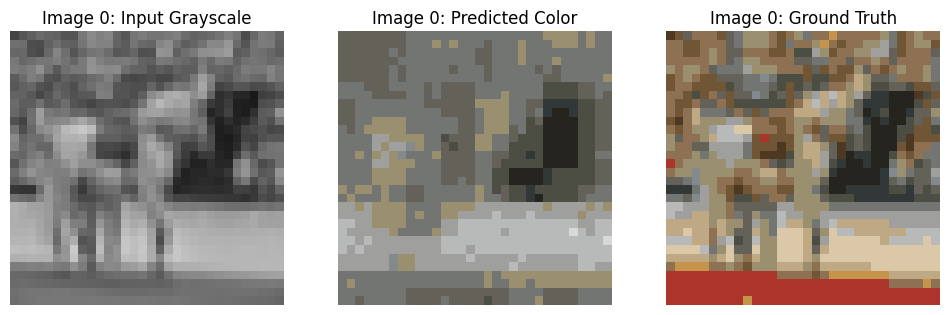

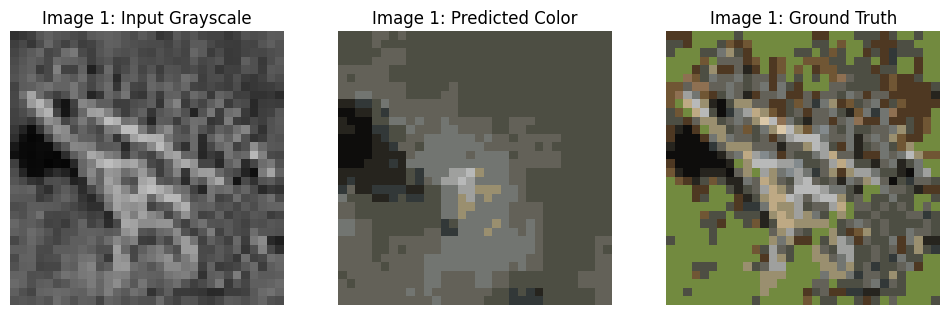

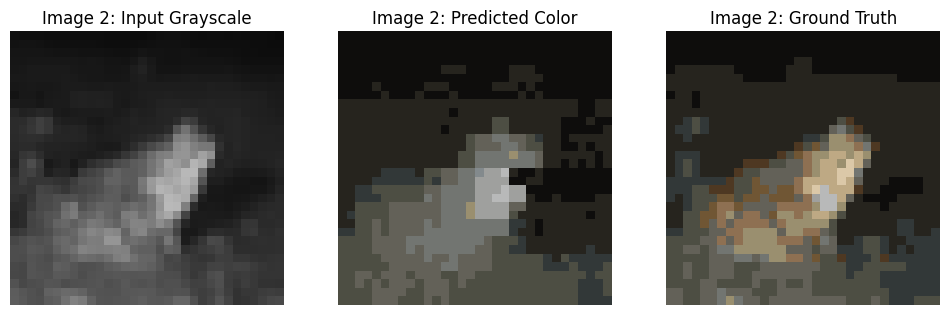

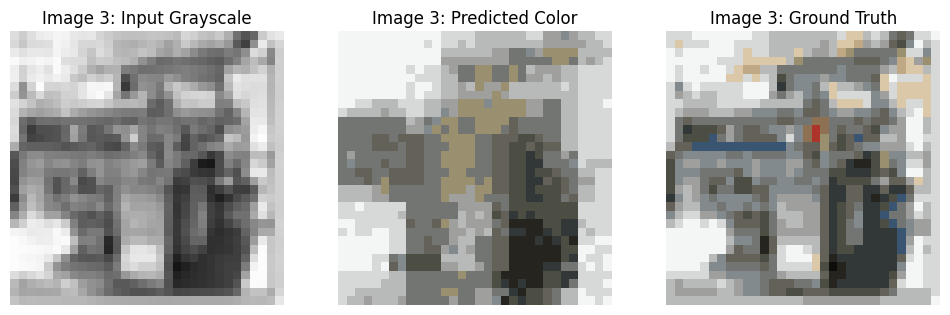

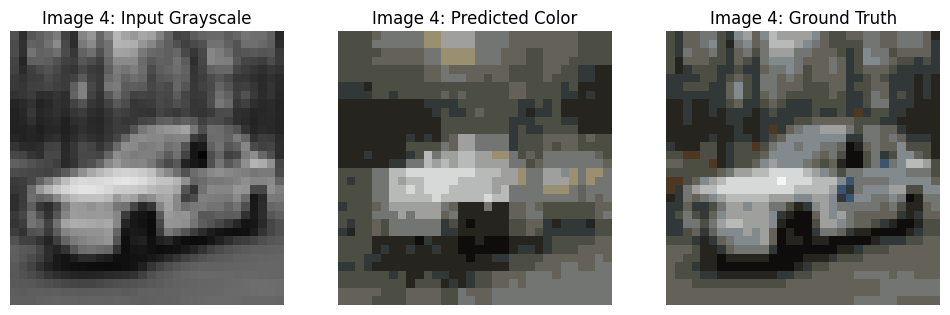

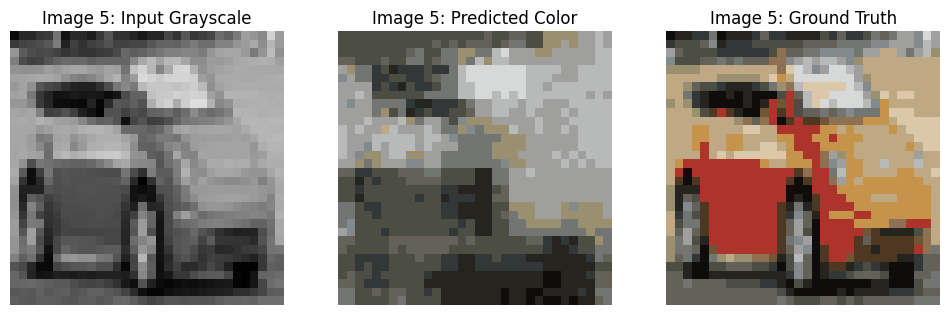

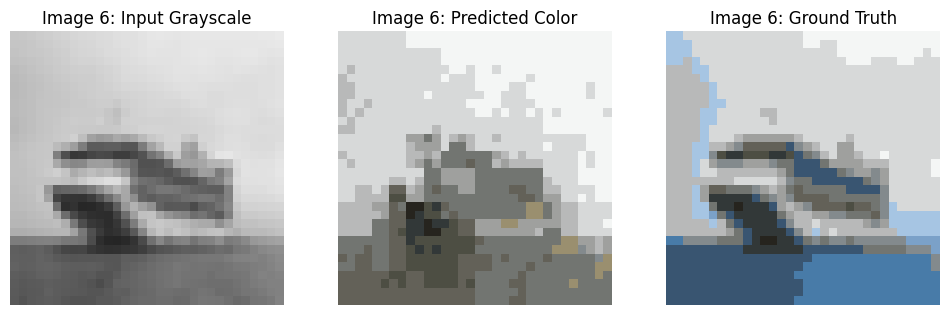

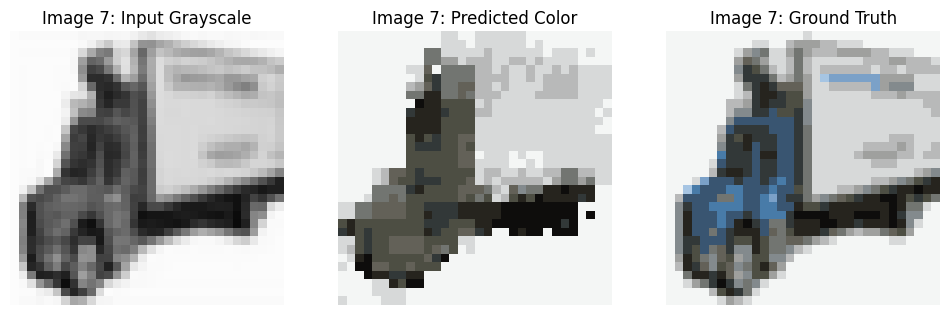

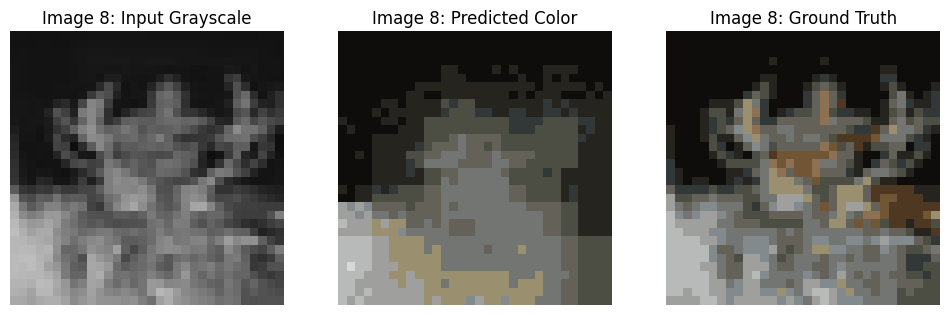

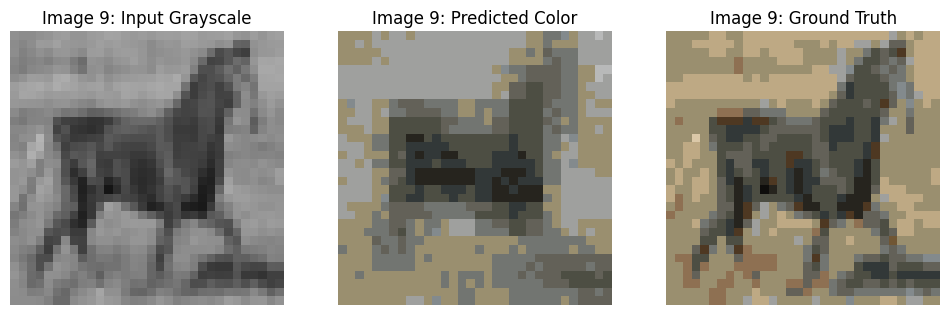

Logged example images.
Best model checkpoints/bs32_ks3_lr0.0001_nf32_optSGD.pth saved to wandb.


wandb: Agent Starting Run: ernkogao with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	num_filters: 16
wandb: 	optimizer: SGD


--- Starting Run: bs32_ks5_lr0.003_nf16_optSGD ---
Config: {'batch_size': 32, 'kernel_size': 5, 'learning_rate': 0.003, 'num_filters': 16, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs32_ks5_lr0.003_nf16_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 313/313 [00:06<00:00, 51.05it/s]


Finished Training for bs32_ks5_lr0.003_nf16_optSGD. Best Val Loss: 1.5042
Generating example colorizations...


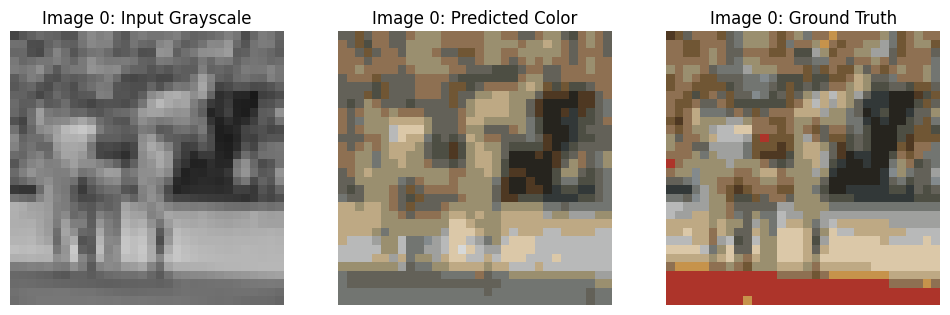

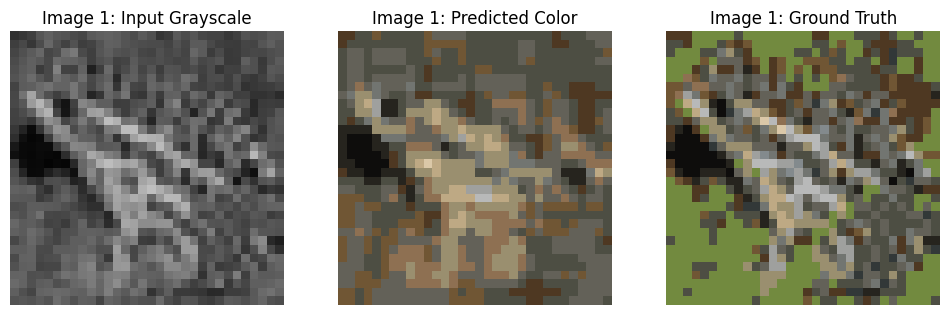

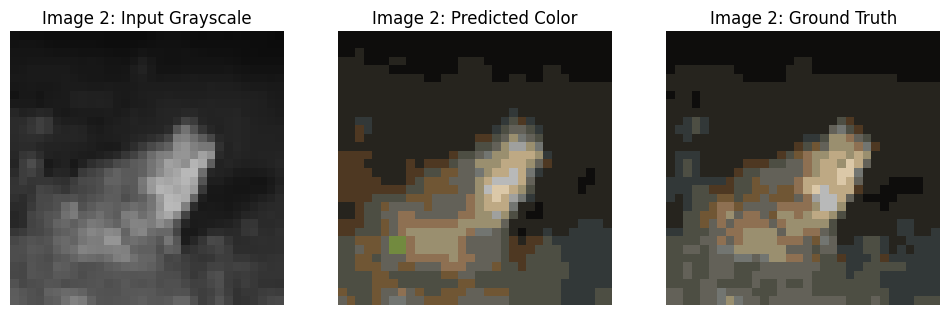

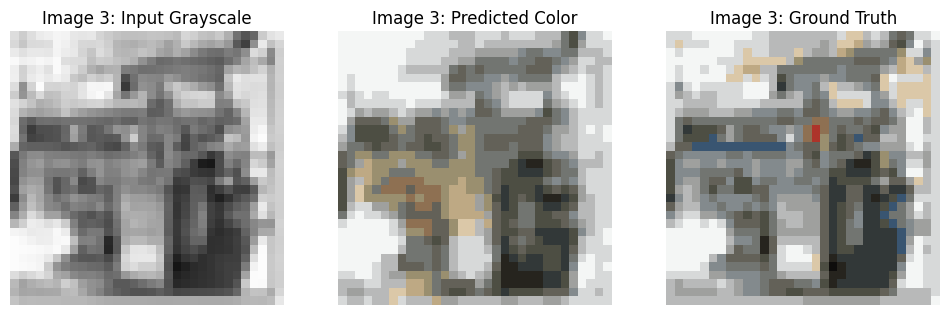

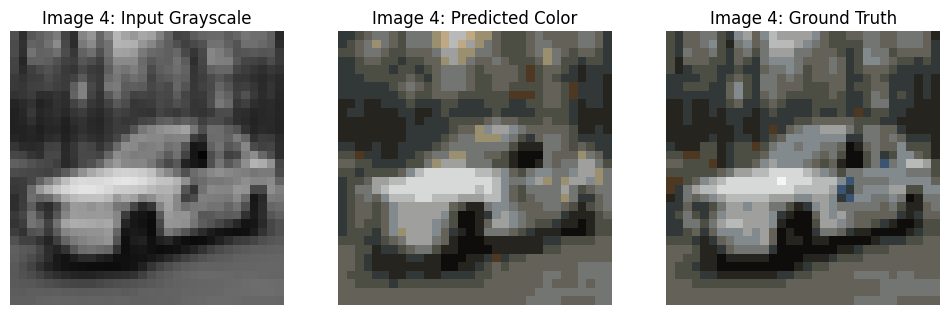

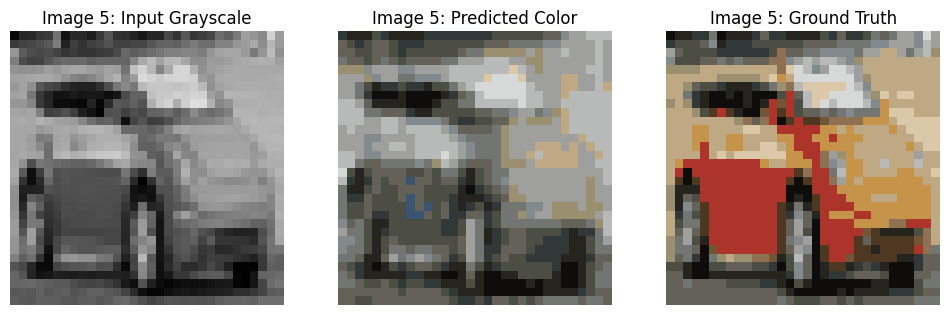

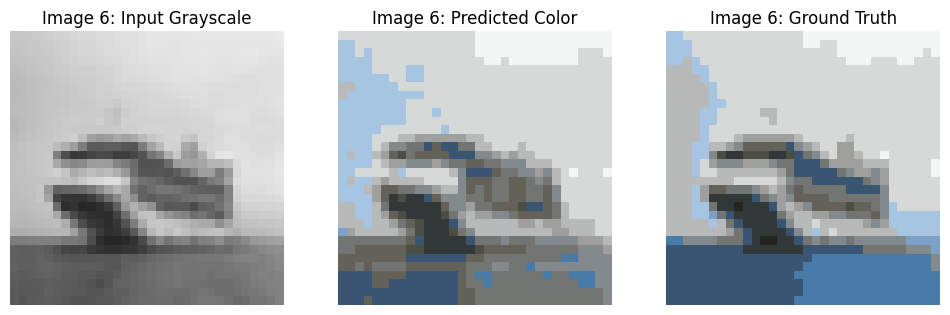

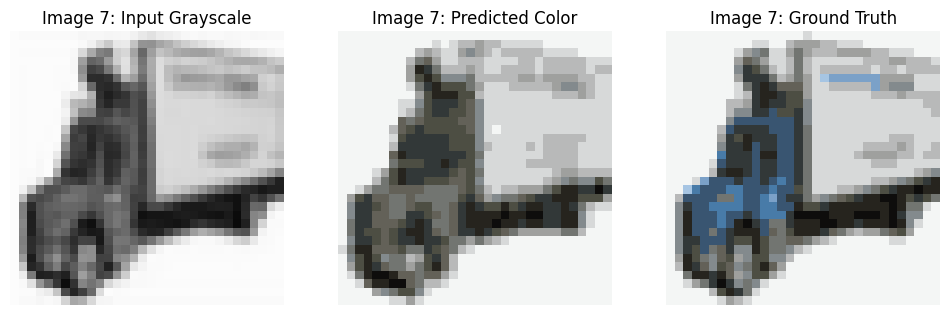

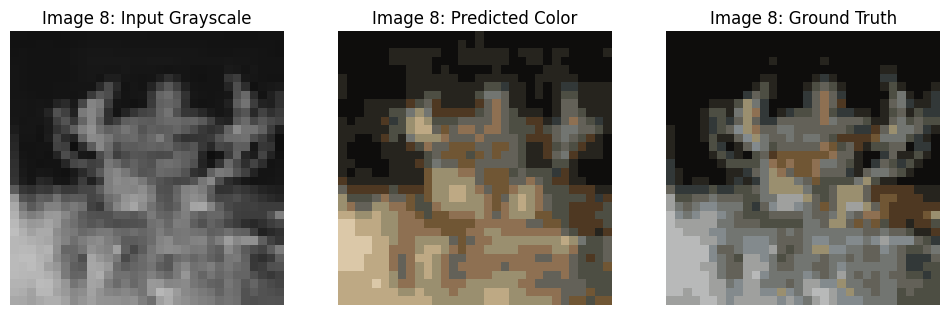

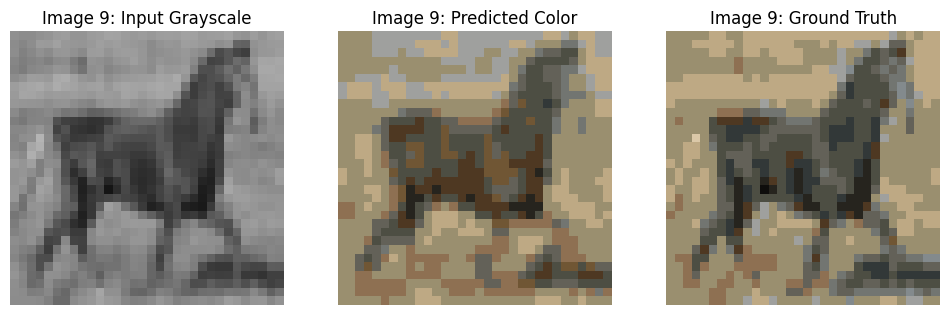

Logged example images.
Best model checkpoints/bs32_ks5_lr0.003_nf16_optSGD.pth saved to wandb.


wandb: Agent Starting Run: 5asx8msh with config:
wandb: 	batch_size: 128
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 32
wandb: 	optimizer: SGD


--- Starting Run: bs128_ks5_lr0.001_nf32_optSGD ---
Config: {'batch_size': 128, 'kernel_size': 5, 'learning_rate': 0.001, 'num_filters': 32, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs128_ks5_lr0.001_nf32_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Finished Training for bs128_ks5_lr0.001_nf32_optSGD. Best Val Loss: 1.7670
Generating example colorizations...


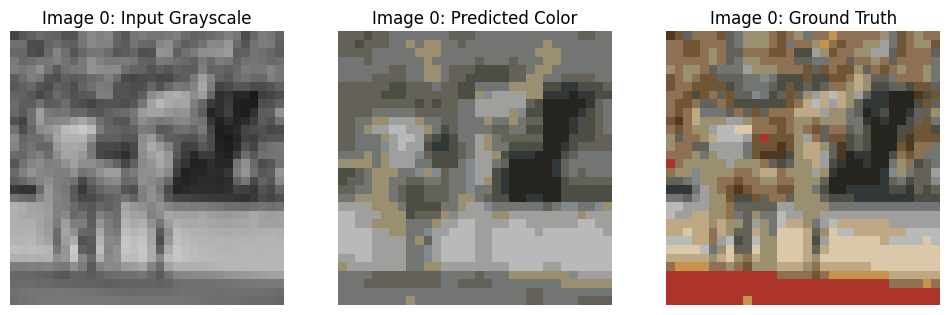

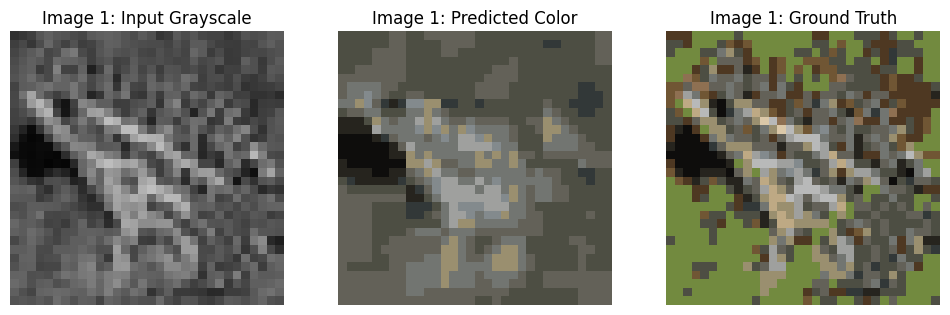

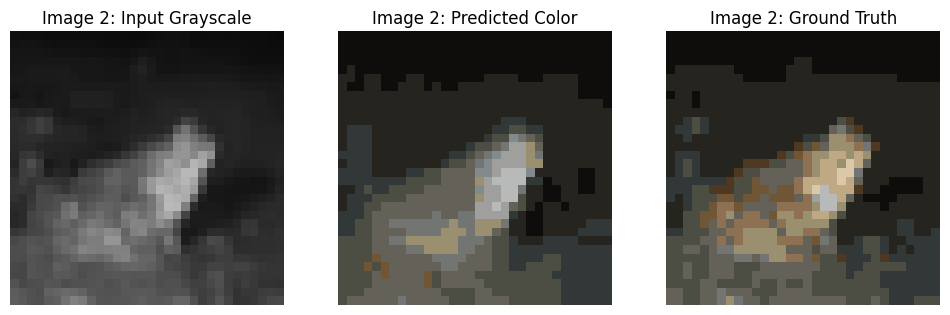

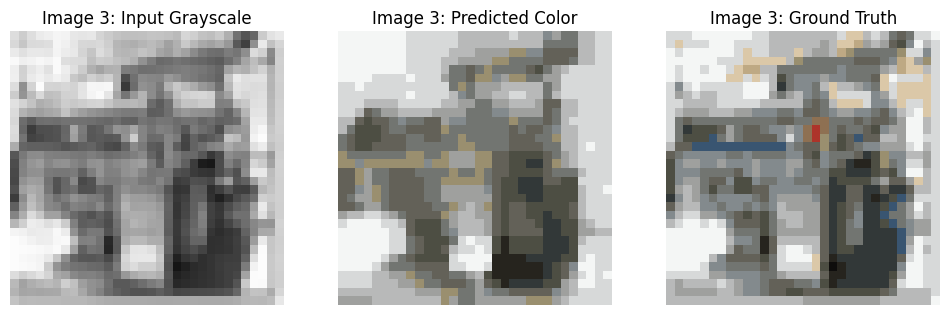

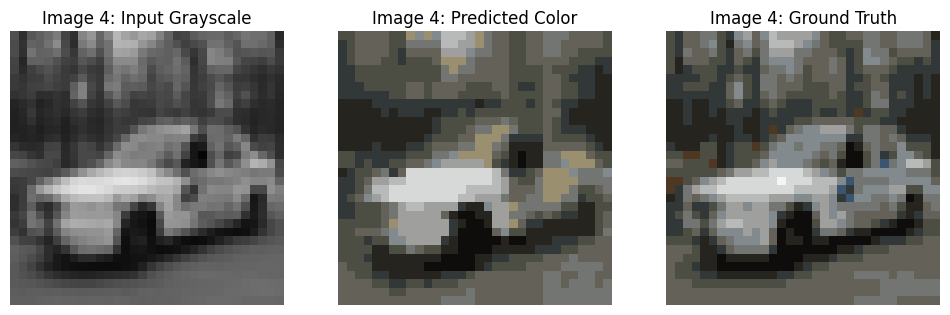

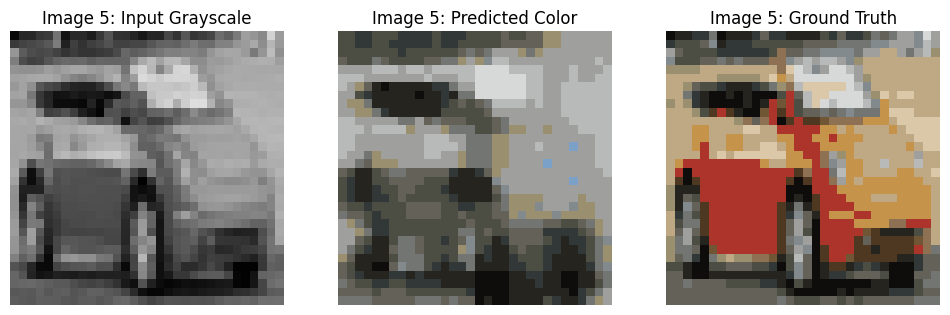

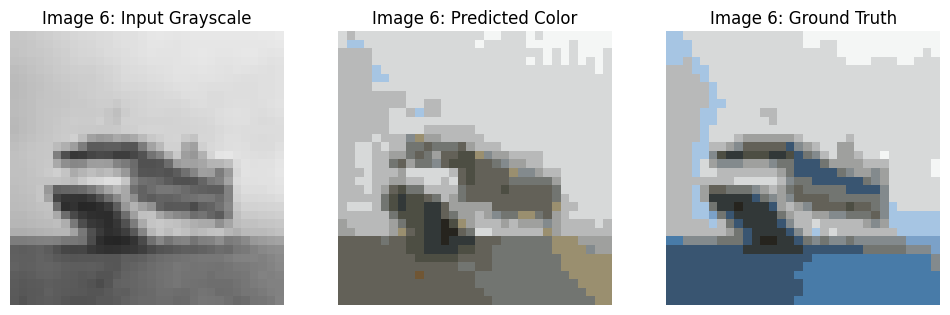

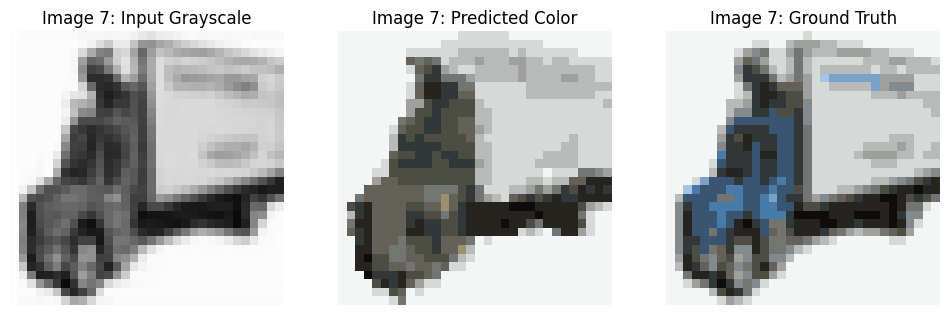

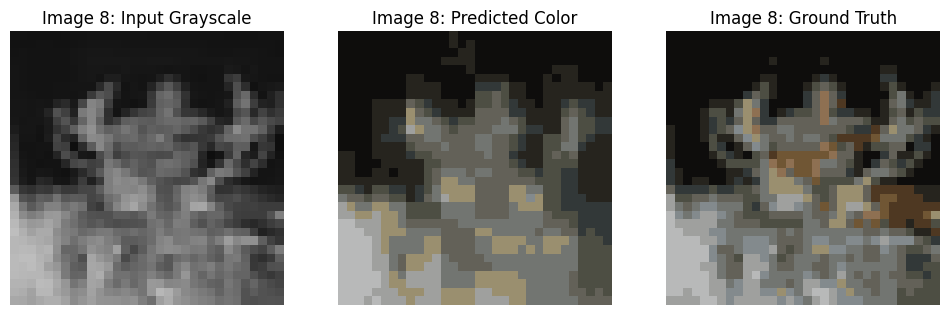

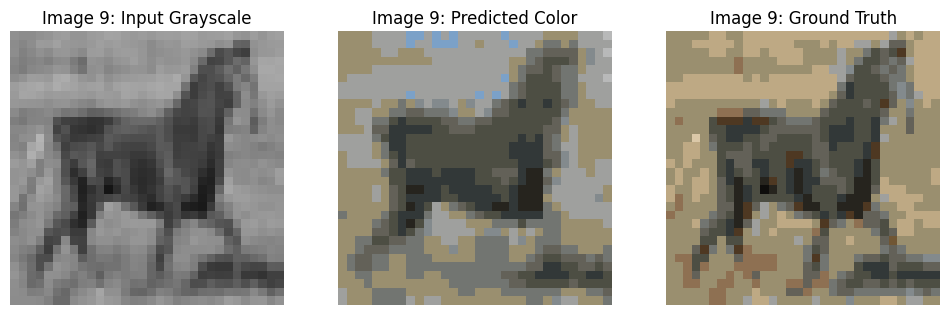

Logged example images.
Best model checkpoints/bs128_ks5_lr0.001_nf32_optSGD.pth saved to wandb.


wandb: Agent Starting Run: vgnhfrvd with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 8
wandb: 	optimizer: SGD


--- Starting Run: bs64_ks3_lr0.001_nf8_optSGD ---
Config: {'batch_size': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'num_filters': 8, 'optimizer': 'SGD'}
Checkpoints will be saved to checkpoints/bs64_ks3_lr0.001_nf8_optSGD.pth


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:06<00:00, 25.19it/s]


Finished Training for bs64_ks3_lr0.001_nf8_optSGD. Best Val Loss: 1.9890
Generating example colorizations...


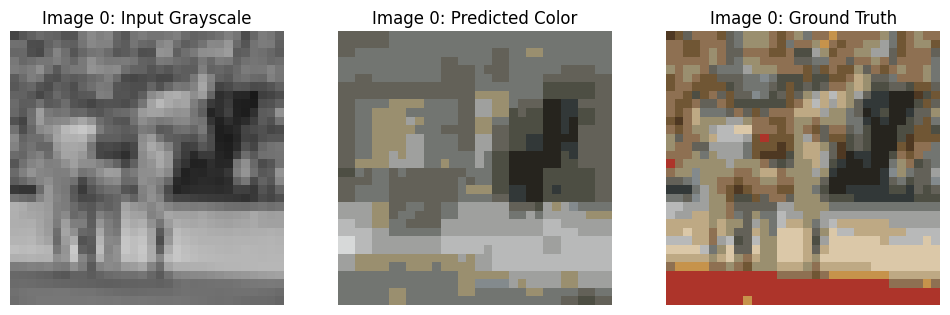

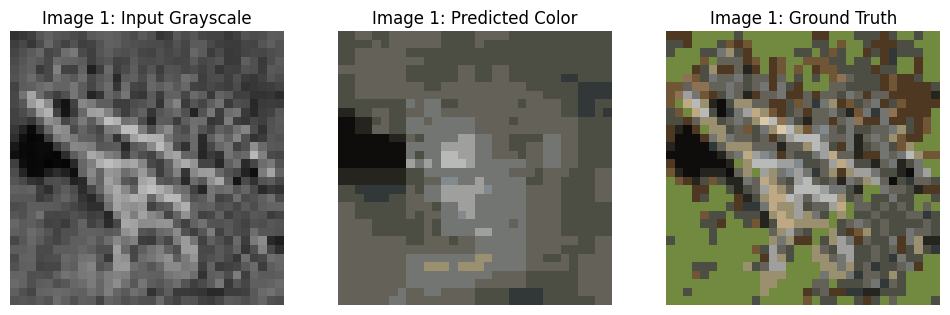

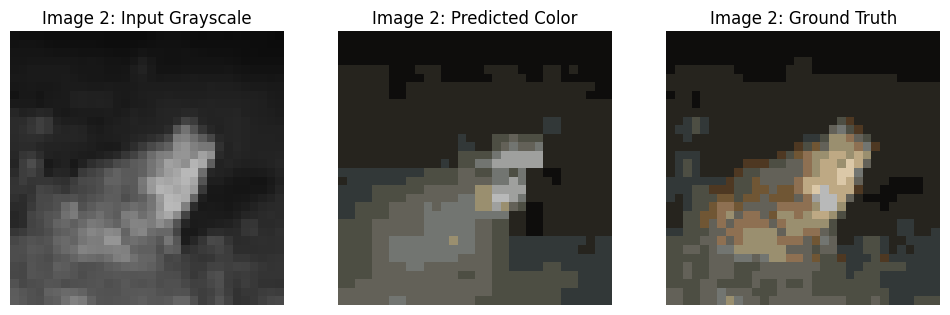

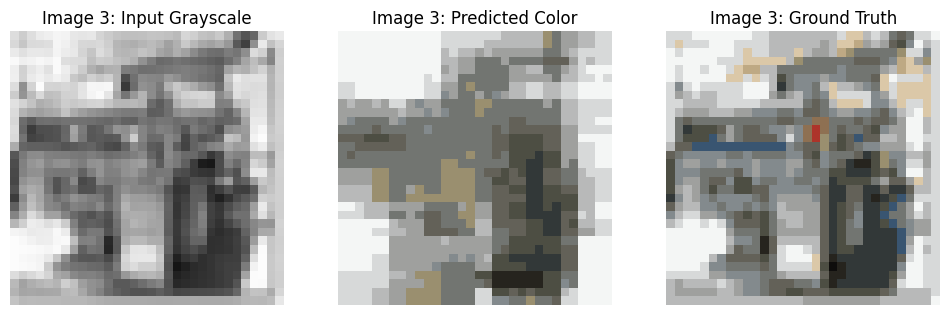

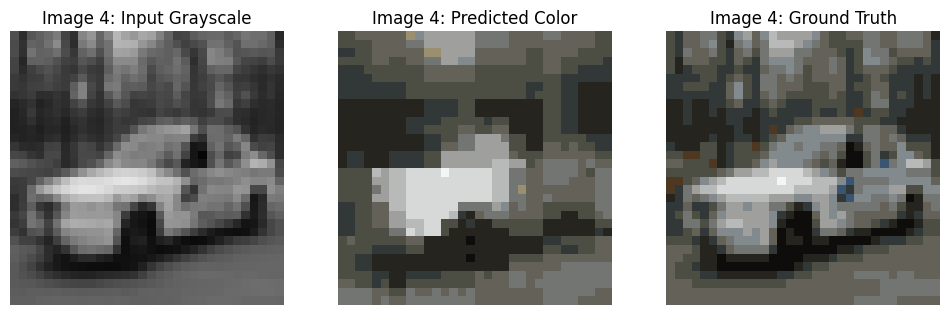

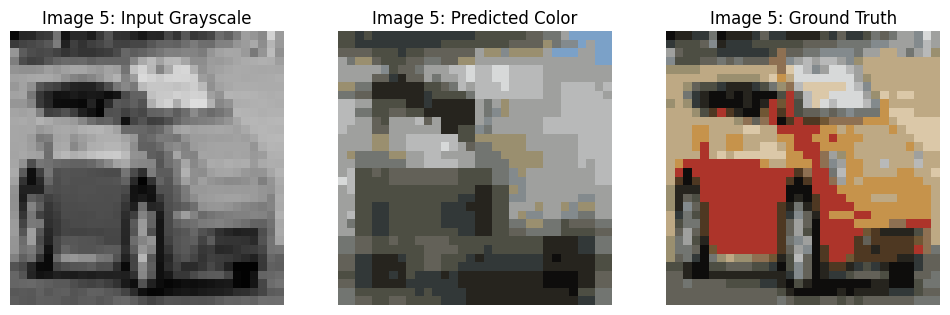

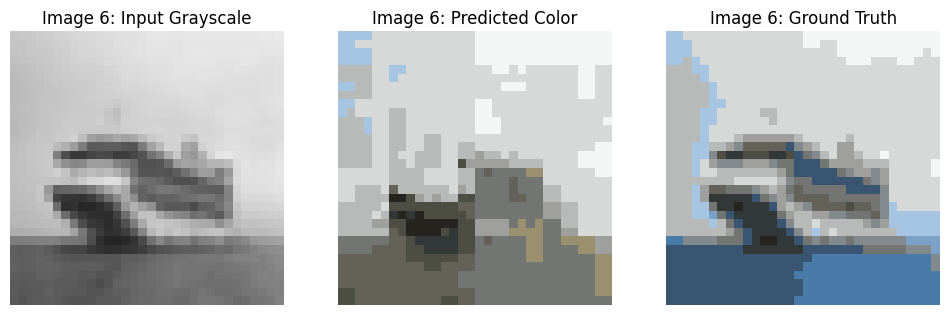

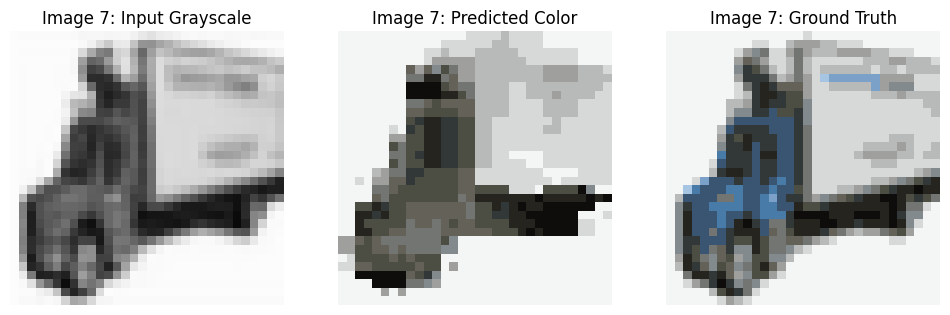

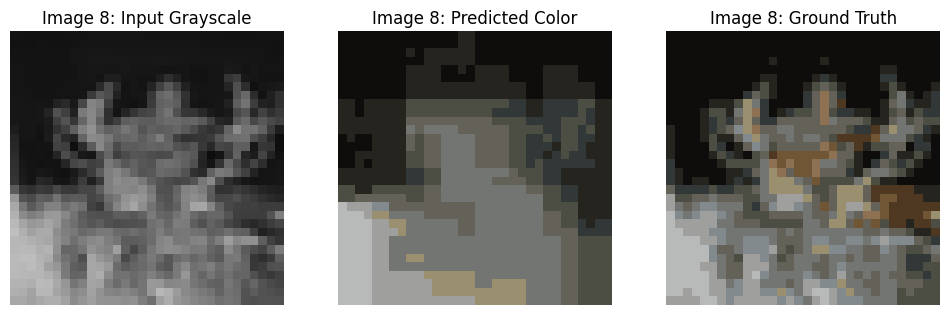

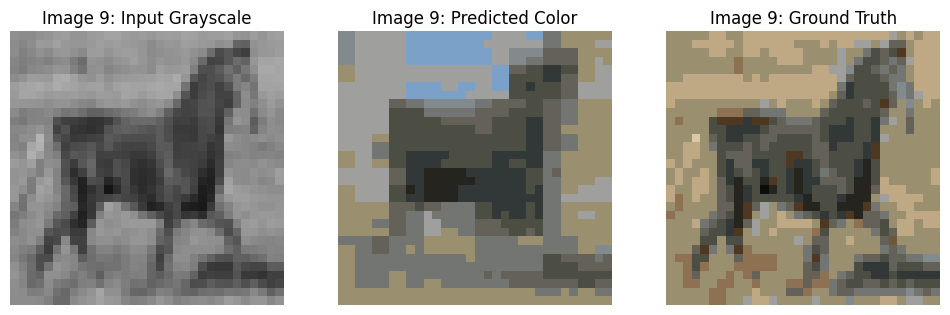

Logged example images.
Best model checkpoints/bs64_ks3_lr0.001_nf8_optSGD.pth saved to wandb.


In [23]:
# --- Make sure these are defined in the global scope ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dataset = val_subset  # Ensure this is set if not already

print("--- Defining Sweep Configuration ---")

sweep_config = {
    'name': 'cifar-colorization-sweep',
    'method': 'random',
    'metric': {
        'name': 'validation_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {'values': [1e-4, 3e-4, 1e-3, 3e-3]},
        'batch_size': {'values': [32, 64, 128]},
        'num_filters': {'values': [8, 16, 32]},
        'kernel_size': {'values': [3, 5]},
        'optimizer': {'values': ['Adam', 'SGD']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="q2-cifar")
print(f"\nSweep initialized. SWEEP_ID: {sweep_id}")
print("--- You can now run Cell 2 to start the agent ---")

def labels_to_rgb(label_map, centroids):
    label_map = label_map.cpu().numpy()
    rgb_image = centroids[label_map]
    return rgb_image.astype(np.uint8)

def grayscale_to_rgb(gray_tensor):
    gray_np = gray_tensor.squeeze(0).cpu().numpy()
    rgb_image = np.stack([gray_np, gray_np, gray_np], axis=-1)
    return (rgb_image * 255).astype(np.uint8)

def train_wrapper():
    run = wandb.init()
    config = wandb.config

    # --- Set run name to include all hyperparameters ---
    run_name = (
        f"bs{config.batch_size}_ks{config.kernel_size}_lr{config.learning_rate}_"
        f"nf{config.num_filters}_opt{config.optimizer}"
    )
    wandb.run.name = run_name
    print(f"--- Starting Run: {run_name} ---")
    print(f"Config: {dict(config)}")

    try:
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
    except NameError:
        print("Error: 'train_dataset' or 'val_dataset' not found.")
        print("Please make sure they are defined in your notebook's global scope before running the agent.")
        wandb.finish()
        return

    model = Model(
        num__filter=config.num_filters,
        num_input_channel=1,
        kernel_size=config.kernel_size,
        number_of_classes=24
    ).to(device)

    if config.optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    num_epochs = 25
    best_val_loss = float('inf')
    save_path = f'checkpoints/{run_name}.pth'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    print(f"Checkpoints will be saved to {save_path}")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        log_dict = {
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "validation_loss": avg_val_loss,
            "best_validation_loss": best_val_loss
        }
        log_dict.update(dict(config))
        wandb.log(log_dict)

    print(f"\nFinished Training for {run_name}. Best Val Loss: {best_val_loss:.4f}")

    print("Generating example colorizations...")
    model.load_state_dict(torch.load(save_path))
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(val_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)

    example_images = []
    for i in range(min(10, config.batch_size)):
        gray_input = inputs[i]
        ground_truth_labels = labels[i]
        pred_labels = predicted_labels[i]
        gray_rgb = grayscale_to_rgb(gray_input)
        truth_rgb = labels_to_rgb(ground_truth_labels, color_centroids)
        pred_rgb = labels_to_rgb(pred_labels, color_centroids)
        example_images.append(wandb.Image(gray_rgb, caption=f"Image {i}: Input Grayscale"))
        example_images.append(wandb.Image(pred_rgb, caption=f"Image {i}: Predicted Color"))
        example_images.append(wandb.Image(truth_rgb, caption=f"Image {i}: Ground Truth"))
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(gray_rgb, cmap='gray')
        plt.title(f"Image {i}: Input Grayscale")
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(pred_rgb)
        plt.title(f"Image {i}: Predicted Color")
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(truth_rgb)
        plt.title(f"Image {i}: Ground Truth")
        plt.axis('off')
        plt.show()

    wandb.log({"Colorization Examples": example_images})
    print("Logged example images.")
    wandb.save(save_path)
    print(f"Best model {save_path} saved to wandb.")
    wandb.finish()

print(f"\n--- Starting Wandb Agent for Sweep {sweep_id} ---")
print("This will run 20 times. You can stop this cell at any time.")
wandb.agent(sweep_id, function=train_wrapper, count=20)